# Lab 3 Report
## MNIST Classification with FCN

### Name: Owen Zhang

In [20]:
# Import necessary packages

%matplotlib inline

import matplotlib.pyplot as plt

import torch
import torchvision
import numpy as np

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [21]:
from IPython.display import Image # For displaying images in colab jupyter cell

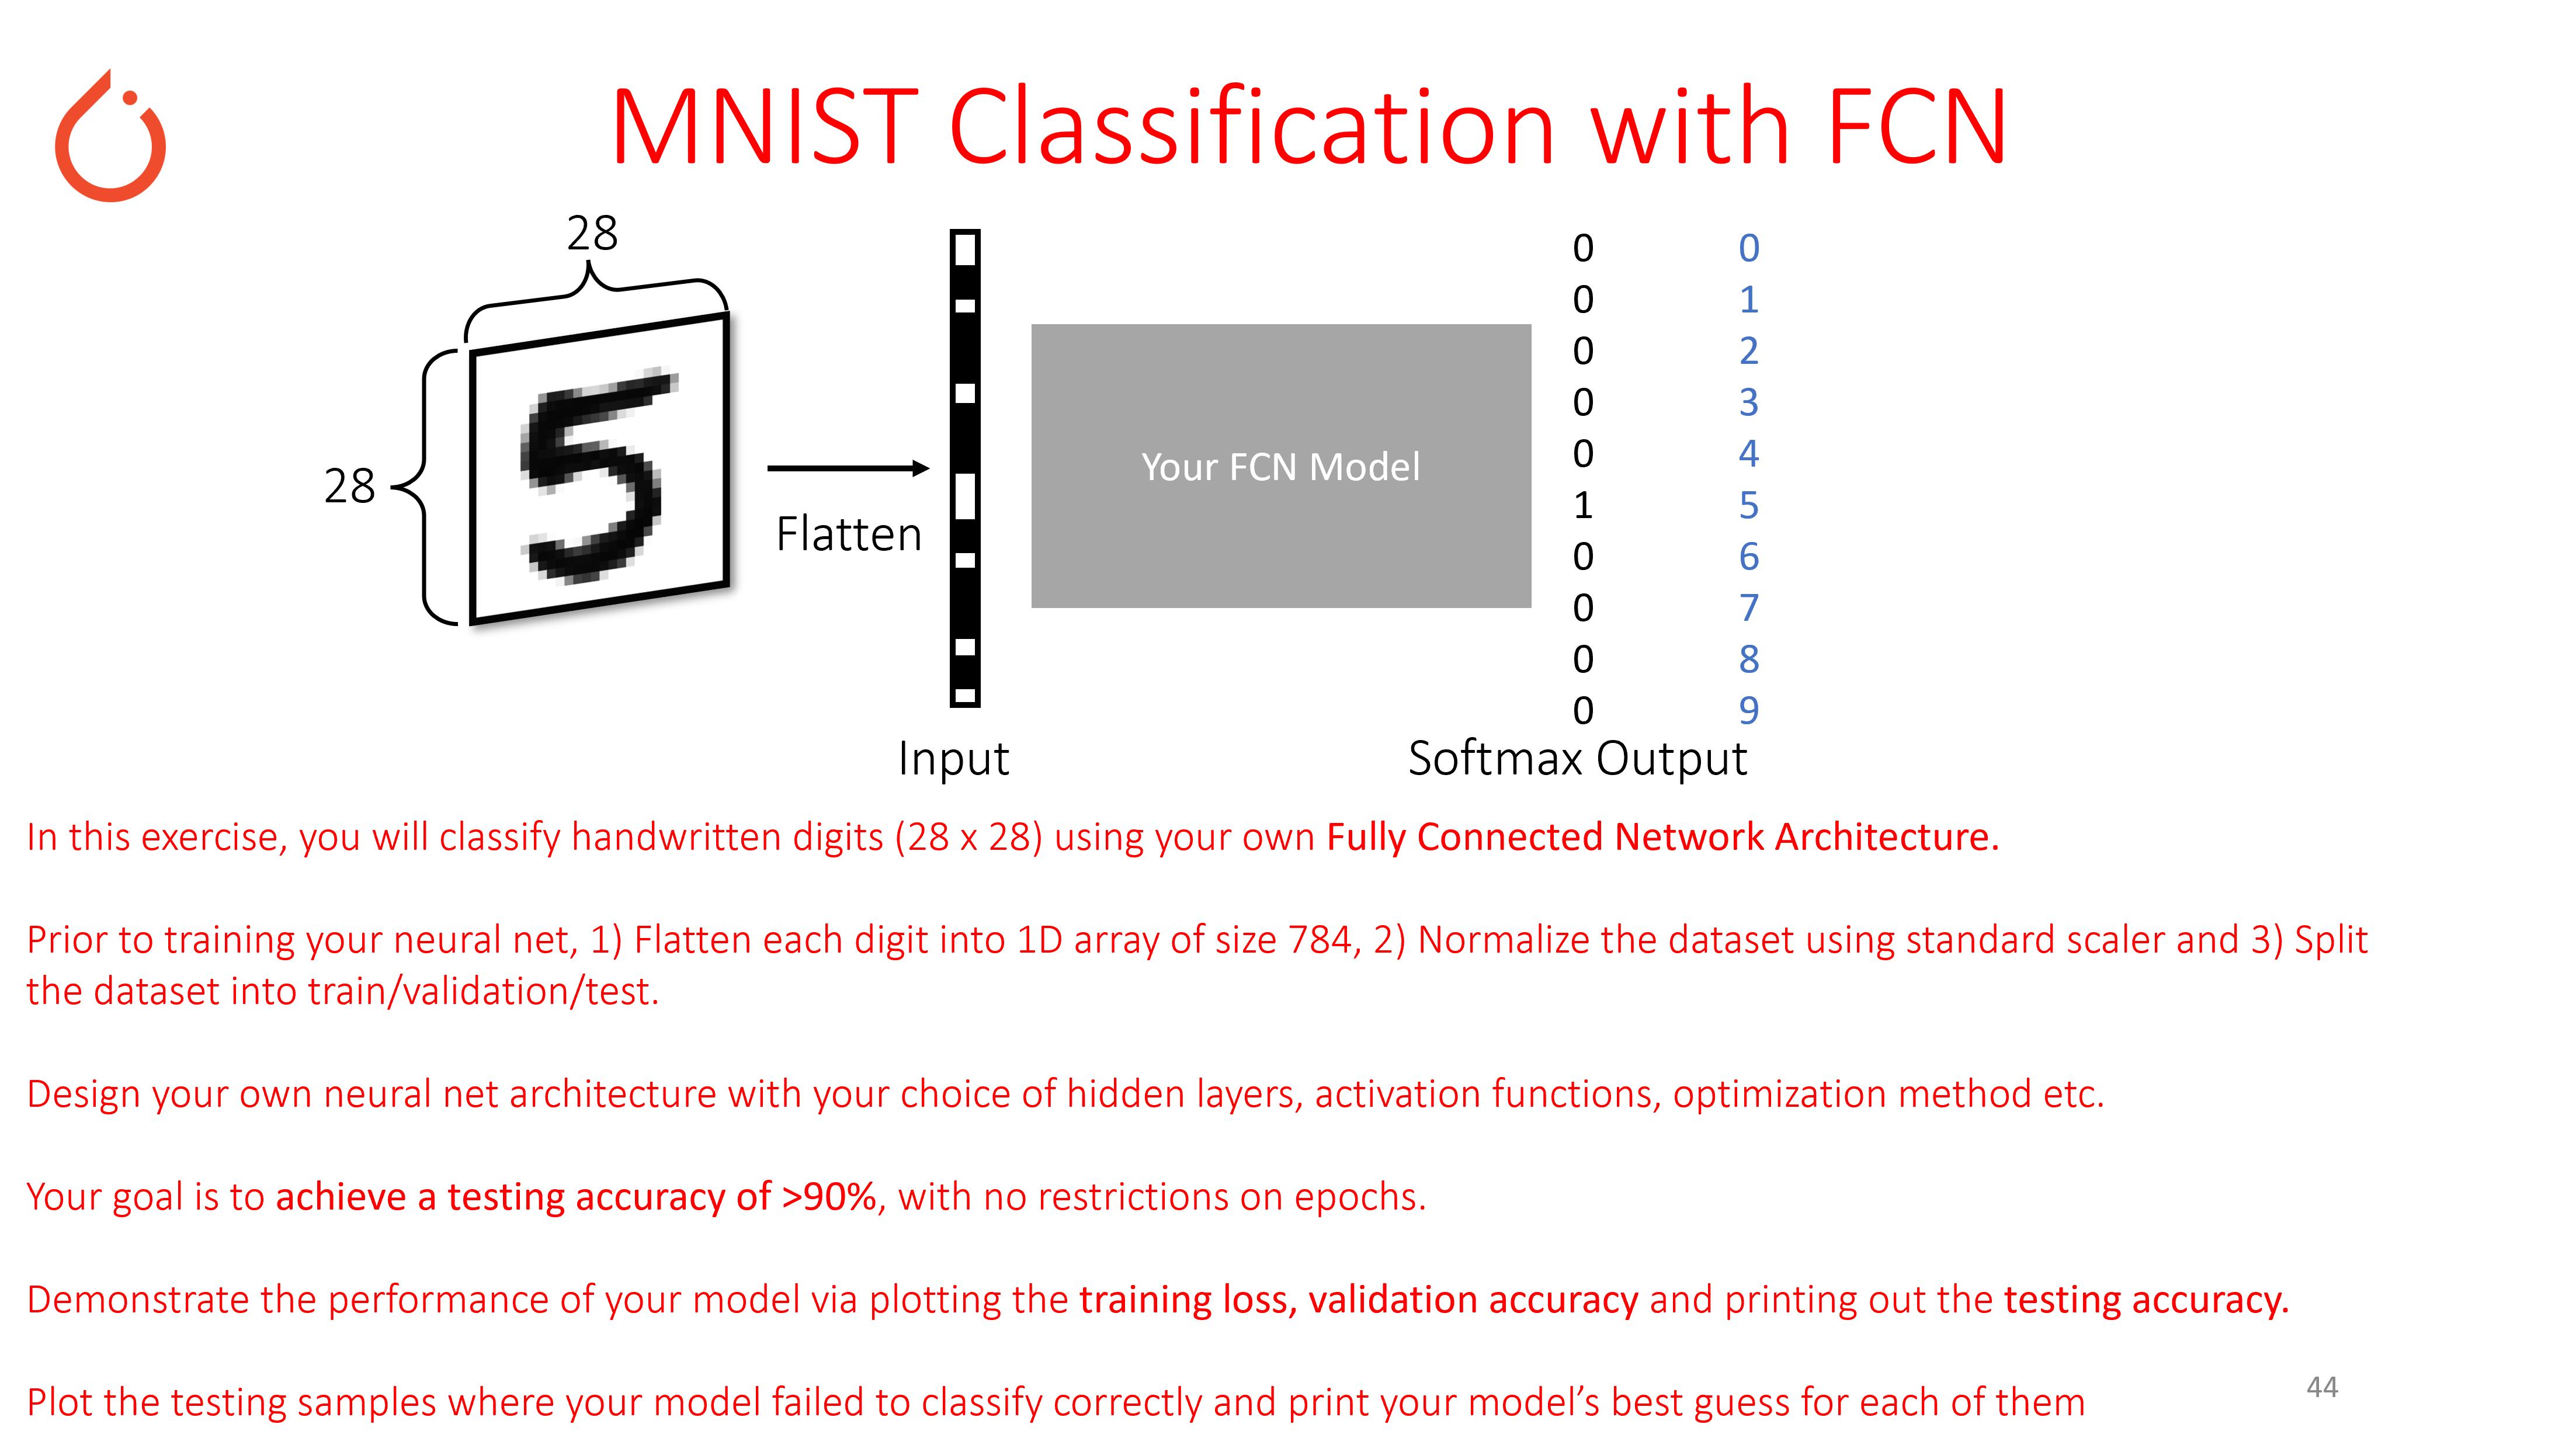

In [22]:
Image('lab3_exercise.PNG', width = 1000)

### Prepare Data

In [23]:
# Load MNIST Dataset in Numpy

# 1000 training samples where each sample feature is a greyscale image with shape (28, 28)
# 1000 training targets where each target is an integer indicating the true digit
mnist_train_features = np.load('mnist_train_features.npy')
mnist_train_targets = np.load('mnist_train_targets.npy')

# 100 testing samples + targets
mnist_test_features = np.load('mnist_test_features.npy')
mnist_test_targets = np.load('mnist_test_targets.npy')

# Print the dimensions of training sample features/targets
print(mnist_train_features.shape, mnist_train_targets.shape)
# Print the dimensions of testing sample features/targets
print(mnist_test_features.shape, mnist_test_targets.shape)

(1000, 28, 28) (1000,)
(100, 28, 28) (100,)


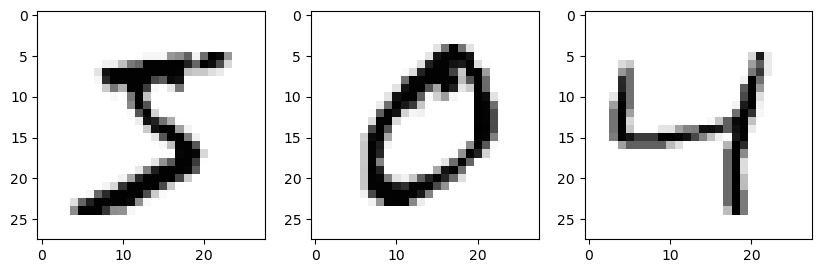

In [24]:
# Let's visualize some training samples

plt.figure(figsize = (10, 10))

plt.subplot(1,3,1)
plt.imshow(mnist_train_features[0], cmap = 'Greys')

plt.subplot(1,3,2)
plt.imshow(mnist_train_features[1], cmap = 'Greys')

plt.subplot(1,3,3)
plt.imshow(mnist_train_features[2], cmap = 'Greys')

In [25]:
# Reshape features via flattening the images
# This refers to reshape each sample from a 2d array to a 1d array.
# hint: np.reshape() function could be useful here

mnist_train_features = np.array([np.reshape(i, 784) for i in mnist_train_features])
mnist_test_features = np.array([np.reshape(i, 784) for i in mnist_test_features])

print(mnist_train_features.shape, mnist_test_features.shape)

(1000, 784) (100, 784)


In [26]:
# Scale the dataset according to standard scaling
def scale_data(arr):
    scaled = np.zeros(arr.shape)
    std = arr.std(axis = 0)
    mean = arr.mean(axis = 0)
    for i in range(np.size(arr, 0)):
        for j in range(np.size(arr, 1)):
            if std[j] != 0:
                scaled[i][j] = (arr[i][j] - mean[j])/(std[j])

    return scaled

mnist_train_features = scale_data(mnist_train_features)
mnist_test_features = scale_data(mnist_test_features)

print(mnist_train_targets)

[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7 3 8 6 9 0 5 6
 0 7 6 1 8 7 9 3 9 8 5 9 3 3 0 7 4 9 8 0 9 4 1 4 4 6 0 4 5 6 1 0 0 1 7 1 6
 3 0 2 1 1 7 9 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1 5 7 1 7 1 1 6 3 0 2 9
 3 1 1 0 4 9 2 0 0 2 0 2 7 1 8 6 4 1 6 3 4 5 9 1 3 3 8 5 4 7 7 4 2 8 5 8 6
 7 3 4 6 1 9 9 6 0 3 7 2 8 2 9 4 4 6 4 9 7 0 9 2 9 5 1 5 9 1 2 3 2 3 5 9 1
 7 6 2 8 2 2 5 0 7 4 9 7 8 3 2 1 1 8 3 6 1 0 3 1 0 0 1 7 2 7 3 0 4 6 5 2 6
 4 7 1 8 9 9 3 0 7 1 0 2 0 3 5 4 6 5 8 6 3 7 5 8 0 9 1 0 3 1 2 2 3 3 6 4 7
 5 0 6 2 7 9 8 5 9 2 1 1 4 4 5 6 4 1 2 5 3 9 3 9 0 5 9 6 5 7 4 1 3 4 0 4 8
 0 4 3 6 8 7 6 0 9 7 5 7 2 1 1 6 8 9 4 1 5 2 2 9 0 3 9 6 7 2 0 3 5 4 3 6 5
 8 9 5 4 7 4 2 7 3 4 8 9 1 9 2 8 7 9 1 8 7 4 1 3 1 1 0 2 3 9 4 9 2 1 6 8 4
 7 7 4 4 9 2 5 7 2 4 4 2 1 9 7 2 8 7 6 9 2 2 3 8 1 6 5 1 1 0 2 6 4 5 8 3 1
 5 1 9 2 7 4 4 4 8 1 5 8 9 5 6 7 9 9 3 7 0 9 0 6 6 2 3 9 0 7 5 4 8 0 9 4 1
 2 8 7 1 2 6 1 0 3 0 1 1 8 2 0 3 9 4 0 5 0 6 1 7 7 8 1 9 2 0 5 1 2 2 7 3 5
 4 9 7 1 8 3 9 6 0 3 1 1 

In [27]:
# Split training dataset into Train (90%), Validation (10%)

val_features = mnist_train_features[:int(0.1*len(mnist_train_features))]
val_targets = mnist_train_targets[:int(0.1*len(mnist_train_targets))]

train_features = mnist_train_features[int(0.1*len(mnist_train_features)):]
train_targets = mnist_train_targets[int(0.1*len(mnist_train_targets)):]

print(val_features.shape, val_targets.shape, train_features.shape, train_targets.shape)

(100, 784) (100,) (900, 784) (900,)


### Define Model

In [28]:
class mnistClassification(torch.nn.Module):
    
    def __init__(self, input_dim, h1, h2, output_dim): # Feel free to add hidden_dim as parameters here

        super(mnistClassification, self).__init__()
        
        self.layer1 = torch.nn.Linear(input_dim, h1)
        self.layer2 = torch.nn.Linear(h1, h2)
        self.layer3 = torch.nn.Linear(h2, output_dim)
        self.dropout = torch.nn.Dropout(p = 0.025)
        
    def forward(self, x):
        
        out1 = torch.nn.functional.relu(self.layer1(x))
        #out1 = self.dropout(out1)
        out2 = torch.nn.functional.relu(self.layer2(out1))
        #out2 = self.dropout(out2)
        out = torch.nn.functional.softmax(self.layer3(out2), dim = 1)
        
        return out

### Define Hyperparameters

In [29]:
# Initialize our neural network model with input and output dimensions
model = mnistClassification(input_dim = 784, h1 = 48, h2 = 24, output_dim = 10)

# Define the learning rate and epoch 
learning_rate = 0.04
epochs = 5000

# 900*784 is a pretty small amount of data so we will not use batches
# Define loss function and optimizer

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# Run this line if you have PyTorch GPU version
if torch.cuda.is_available():
    model.cuda()



### Identify Tracked Values

In [30]:
# Placeholders for training loss and validation accuracy during training
# Training loss should be tracked for each iteration (1 iteration -> single forward pass to the network)
# Validation accuracy should be evaluated every 'Epoch' (1 epoch -> full training dataset)
# If using batch gradient, 1 iteration = 1 epoch

train_loss_list = []
validation_accuracy_list = []

### Train Model

In [31]:
import tqdm

# Convert the training, validation, testing dataset (NumPy arrays) into torch tensors
test_inputs = torch.from_numpy(train_features).float()
test_targets = torch.from_numpy(train_targets)
validation_inputs = torch.from_numpy(val_features).float()
validation_targets = torch.from_numpy(val_targets)

# YOUR CODE HERE

# Training Loop ---------------------------------------------------------------------------------------

for epoch in tqdm.trange(epochs):
    optimizer.zero_grad()
    test_outputs = model(test_inputs)
    loss = loss_func(test_outputs, test_targets)
    train_loss_list.append(loss.item())
    loss.backward()
    optimizer.step()
    print('epoch {}, loss {}'.format(epoch, loss.item()))
    #test accuracy through validation
    val_outputs = model(validation_inputs).detach().numpy()
    correct = (np.argmax(val_outputs, axis=1) == val_targets).sum()
    validation_accuracy_list.append(correct/np.shape(val_outputs)[0]*100)
    print('epoch {}, accuracy {}'.format(epoch, validation_accuracy_list[-1]))


  0%|                                                  | 0/5000 [00:00<?, ?it/s]

epoch 0, loss 2.3029043674468994
epoch 0, accuracy 11.0
epoch 1, loss 2.3028440475463867
epoch 1, accuracy 11.0
epoch 2, loss 2.302783727645874
epoch 2, accuracy 11.0
epoch 3, loss 2.3027231693267822
epoch 3, accuracy 12.0
epoch 4, loss 2.3026623725891113
epoch 4, accuracy 12.0
epoch 5, loss 2.3026020526885986
epoch 5, accuracy 13.0
epoch 6, loss 2.302541732788086
epoch 6, accuracy 13.0
epoch 7, loss 2.302480697631836
epoch 7, accuracy 13.0
epoch 8, loss 2.302419900894165
epoch 8, accuracy 13.0
epoch 9, loss 2.302358865737915
epoch 9, accuracy 13.0
epoch 10, loss 2.302298069000244
epoch 10, accuracy 13.0
epoch 11, loss 2.302237033843994
epoch 11, accuracy 13.0
epoch 12, loss 2.3021764755249023
epoch 12, accuracy 13.0
epoch 13, loss 2.3021154403686523
epoch 13, accuracy 13.0


  0%|                                        | 15/5000 [00:00<00:34, 142.44it/s]

epoch 14, loss 2.302053928375244
epoch 14, accuracy 13.0
epoch 15, loss 2.301992654800415
epoch 15, accuracy 13.0


  1%|▏                                       | 30/5000 [00:00<00:35, 141.20it/s]

epoch 16, loss 2.301931142807007
epoch 16, accuracy 13.0
epoch 17, loss 2.3018693923950195
epoch 17, accuracy 13.0
epoch 18, loss 2.3018076419830322
epoch 18, accuracy 13.0
epoch 19, loss 2.301745653152466
epoch 19, accuracy 13.0
epoch 20, loss 2.3016834259033203
epoch 20, accuracy 13.0
epoch 21, loss 2.301621198654175
epoch 21, accuracy 13.0
epoch 22, loss 2.301558494567871
epoch 22, accuracy 13.0
epoch 23, loss 2.3014960289001465
epoch 23, accuracy 13.0
epoch 24, loss 2.3014328479766846
epoch 24, accuracy 13.0
epoch 25, loss 2.3013699054718018
epoch 25, accuracy 13.0
epoch 26, loss 2.30130672454834
epoch 26, accuracy 13.0
epoch 27, loss 2.301243543624878
epoch 27, accuracy 13.0
epoch 28, loss 2.3011794090270996
epoch 28, accuracy 13.0
epoch 29, loss 2.3011162281036377
epoch 29, accuracy 13.0
epoch 30, loss 2.3010523319244385
epoch 30, accuracy 13.0
epoch 31, loss 2.3009886741638184
epoch 31, accuracy 14.000000000000002
epoch 32, loss 2.3009252548217773
epoch 32, accuracy 14.000000000

  1%|▍                                       | 49/5000 [00:00<00:30, 161.84it/s]

epoch 48, loss 2.2998976707458496
epoch 48, accuracy 20.0
epoch 49, loss 2.299833059310913
epoch 49, accuracy 20.0
epoch 50, loss 2.2997686862945557
epoch 50, accuracy 20.0
epoch 51, loss 2.29970383644104
epoch 51, accuracy 20.0
epoch 52, loss 2.2996389865875244
epoch 52, accuracy 20.0
epoch 53, loss 2.2995738983154297
epoch 53, accuracy 20.0
epoch 54, loss 2.299508810043335
epoch 54, accuracy 20.0
epoch 55, loss 2.2994437217712402
epoch 55, accuracy 20.0
epoch 56, loss 2.299377918243408
epoch 56, accuracy 20.0
epoch 57, loss 2.2993123531341553
epoch 57, accuracy 21.0
epoch 58, loss 2.299246072769165
epoch 58, accuracy 21.0
epoch 59, loss 2.299180507659912
epoch 59, accuracy 21.0
epoch 60, loss 2.299114227294922
epoch 60, accuracy 21.0
epoch 61, loss 2.2990481853485107
epoch 61, accuracy 21.0
epoch 62, loss 2.2989819049835205
epoch 62, accuracy 21.0
epoch 63, loss 2.2989161014556885
epoch 63, accuracy 21.0
epoch 64, loss 2.29884934425354
epoch 64, accuracy 21.0


  1%|▌                                       | 66/5000 [00:00<00:30, 159.17it/s]

epoch 65, loss 2.2987828254699707
epoch 65, accuracy 21.0
epoch 66, loss 2.298715829849243
epoch 66, accuracy 21.0
epoch 67, loss 2.298649311065674
epoch 67, accuracy 21.0
epoch 68, loss 2.2985827922821045
epoch 68, accuracy 21.0
epoch 69, loss 2.298515796661377
epoch 69, accuracy 21.0
epoch 70, loss 2.2984492778778076
epoch 70, accuracy 21.0
epoch 71, loss 2.298381805419922
epoch 71, accuracy 21.0
epoch 72, loss 2.298314332962036
epoch 72, accuracy 21.0
epoch 73, loss 2.2982470989227295
epoch 73, accuracy 21.0
epoch 74, loss 2.2981796264648438
epoch 74, accuracy 21.0
epoch 75, loss 2.2981116771698
epoch 75, accuracy 21.0
epoch 76, loss 2.298044204711914
epoch 76, accuracy 21.0
epoch 77, loss 2.297976016998291
epoch 77, accuracy 21.0
epoch 78, loss 2.297908067703247
epoch 78, accuracy 21.0
epoch 79, loss 2.297839879989624
epoch 79, accuracy 21.0
epoch 80, loss 2.297771692276001
epoch 80, accuracy 21.0
epoch 81, loss 2.297703742980957
epoch 81, accuracy 21.0
epoch 82, loss 2.29763507843

  2%|▋                                       | 87/5000 [00:00<00:28, 174.46it/s]

epoch 85, loss 2.29742693901062
epoch 85, accuracy 22.0
epoch 86, loss 2.2973575592041016
epoch 86, accuracy 22.0
epoch 87, loss 2.2972872257232666
epoch 87, accuracy 22.0
epoch 88, loss 2.2972168922424316
epoch 88, accuracy 24.0
epoch 89, loss 2.2971465587615967
epoch 89, accuracy 24.0
epoch 90, loss 2.2970755100250244
epoch 90, accuracy 24.0
epoch 91, loss 2.2970049381256104
epoch 91, accuracy 25.0
epoch 92, loss 2.29693341255188
epoch 92, accuracy 25.0
epoch 93, loss 2.2968616485595703
epoch 93, accuracy 26.0
epoch 94, loss 2.29679012298584
epoch 94, accuracy 26.0
epoch 95, loss 2.296717643737793
epoch 95, accuracy 27.0
epoch 96, loss 2.296644926071167
epoch 96, accuracy 27.0
epoch 97, loss 2.296571969985962
epoch 97, accuracy 27.0
epoch 98, loss 2.2964987754821777
epoch 98, accuracy 27.0
epoch 99, loss 2.2964253425598145
epoch 99, accuracy 27.0
epoch 100, loss 2.296351194381714
epoch 100, accuracy 27.0
epoch 101, loss 2.2962772846221924
epoch 101, accuracy 27.0
epoch 102, loss 2.29

  2%|▊                                      | 106/5000 [00:00<00:27, 178.54it/s]

epoch 105, accuracy 27.0
epoch 106, loss 2.2959036827087402
epoch 106, accuracy 27.0
epoch 107, loss 2.295827627182007
epoch 107, accuracy 27.0
epoch 108, loss 2.2957515716552734
epoch 108, accuracy 27.0
epoch 109, loss 2.295675277709961
epoch 109, accuracy 27.0
epoch 110, loss 2.2955985069274902
epoch 110, accuracy 27.0
epoch 111, loss 2.2955212593078613
epoch 111, accuracy 27.0
epoch 112, loss 2.2954442501068115
epoch 112, accuracy 27.0
epoch 113, loss 2.2953665256500244
epoch 113, accuracy 27.0
epoch 114, loss 2.295288562774658
epoch 114, accuracy 27.0
epoch 115, loss 2.295210123062134
epoch 115, accuracy 27.0
epoch 116, loss 2.2951319217681885
epoch 116, accuracy 27.0
epoch 117, loss 2.295053005218506
epoch 117, accuracy 27.0
epoch 118, loss 2.294973611831665
epoch 118, accuracy 28.000000000000004
epoch 119, loss 2.2948944568634033
epoch 119, accuracy 28.000000000000004
epoch 120, loss 2.294814109802246
epoch 120, accuracy 28.000000000000004
epoch 121, loss 2.294734239578247
epoch 

  3%|▉                                      | 128/5000 [00:00<00:25, 189.97it/s]

epoch 126, accuracy 28.000000000000004
epoch 127, loss 2.2942442893981934
epoch 127, accuracy 28.000000000000004
epoch 128, loss 2.294161558151245
epoch 128, accuracy 28.000000000000004
epoch 129, loss 2.2940785884857178
epoch 129, accuracy 28.999999999999996
epoch 130, loss 2.293994903564453
epoch 130, accuracy 28.999999999999996


  3%|█▏                                     | 149/5000 [00:00<00:24, 196.13it/s]

epoch 131, loss 2.2939109802246094
epoch 131, accuracy 28.999999999999996
epoch 132, loss 2.2938263416290283
epoch 132, accuracy 28.999999999999996
epoch 133, loss 2.29374098777771
epoch 133, accuracy 28.999999999999996
epoch 134, loss 2.2936553955078125
epoch 134, accuracy 28.999999999999996
epoch 135, loss 2.2935690879821777
epoch 135, accuracy 28.999999999999996
epoch 136, loss 2.293483018875122
epoch 136, accuracy 28.999999999999996
epoch 137, loss 2.29339599609375
epoch 137, accuracy 28.999999999999996
epoch 138, loss 2.2933082580566406
epoch 138, accuracy 30.0
epoch 139, loss 2.2932207584381104
epoch 139, accuracy 30.0
epoch 140, loss 2.2931323051452637
epoch 140, accuracy 30.0
epoch 141, loss 2.293043613433838
epoch 141, accuracy 30.0
epoch 142, loss 2.292954683303833
epoch 142, accuracy 30.0
epoch 143, loss 2.2928647994995117
epoch 143, accuracy 30.0
epoch 144, loss 2.2927751541137695
epoch 144, accuracy 30.0
epoch 145, loss 2.29268479347229
epoch 145, accuracy 30.0
epoch 146, 

  3%|█▎                                     | 169/5000 [00:00<00:24, 194.60it/s]

epoch 168, loss 2.290454387664795
epoch 168, accuracy 32.0
epoch 169, loss 2.2903499603271484
epoch 169, accuracy 32.0
epoch 170, loss 2.2902445793151855
epoch 170, accuracy 31.0
epoch 171, loss 2.2901389598846436
epoch 171, accuracy 33.0
epoch 172, loss 2.290031909942627
epoch 172, accuracy 34.0
epoch 173, loss 2.289924144744873
epoch 173, accuracy 34.0
epoch 174, loss 2.289815902709961
epoch 174, accuracy 34.0
epoch 175, loss 2.2897069454193115
epoch 175, accuracy 34.0
epoch 176, loss 2.289597272872925
epoch 176, accuracy 34.0
epoch 177, loss 2.2894866466522217
epoch 177, accuracy 34.0
epoch 178, loss 2.2893755435943604
epoch 178, accuracy 34.0
epoch 179, loss 2.2892632484436035
epoch 179, accuracy 34.0
epoch 180, loss 2.2891504764556885
epoch 180, accuracy 34.0
epoch 181, loss 2.289036512374878
epoch 181, accuracy 34.0
epoch 182, loss 2.288922071456909
epoch 182, accuracy 36.0


  4%|█▍                                     | 189/5000 [00:01<00:27, 177.99it/s]

epoch 183, loss 2.288806676864624
epoch 183, accuracy 37.0
epoch 184, loss 2.2886900901794434
epoch 184, accuracy 37.0
epoch 185, loss 2.2885725498199463
epoch 185, accuracy 37.0
epoch 186, loss 2.288454294204712
epoch 186, accuracy 38.0
epoch 187, loss 2.288334846496582
epoch 187, accuracy 38.0
epoch 188, loss 2.288214683532715
epoch 188, accuracy 38.0
epoch 189, loss 2.2880938053131104
epoch 189, accuracy 38.0
epoch 190, loss 2.287971258163452
epoch 190, accuracy 38.0
epoch 191, loss 2.287848472595215
epoch 191, accuracy 38.0
epoch 192, loss 2.287724256515503
epoch 192, accuracy 38.0
epoch 193, loss 2.287599802017212
epoch 193, accuracy 38.0
epoch 194, loss 2.2874741554260254
epoch 194, accuracy 38.0
epoch 195, loss 2.287346839904785
epoch 195, accuracy 38.0
epoch 196, loss 2.2872180938720703
epoch 196, accuracy 38.0
epoch 197, loss 2.287088394165039
epoch 197, accuracy 38.0
epoch 198, loss 2.2869579792022705
epoch 198, accuracy 38.0
epoch 199, loss 2.2868263721466064
epoch 199, accu

  4%|█▋                                     | 209/5000 [00:01<00:26, 182.41it/s]

epoch 207, loss 2.2857308387756348
epoch 207, accuracy 38.0
epoch 208, loss 2.285588026046753
epoch 208, accuracy 38.0
epoch 209, loss 2.285444974899292
epoch 209, accuracy 38.0
epoch 210, loss 2.2853000164031982
epoch 210, accuracy 38.0
epoch 211, loss 2.285154104232788
epoch 211, accuracy 38.0
epoch 212, loss 2.2850069999694824
epoch 212, accuracy 38.0
epoch 213, loss 2.284858465194702
epoch 213, accuracy 38.0
epoch 214, loss 2.2847084999084473
epoch 214, accuracy 38.0
epoch 215, loss 2.2845571041107178
epoch 215, accuracy 38.0
epoch 216, loss 2.2844040393829346
epoch 216, accuracy 39.0
epoch 217, loss 2.2842490673065186
epoch 217, accuracy 39.0
epoch 218, loss 2.284092903137207


  5%|█▊                                     | 228/5000 [00:01<00:27, 174.25it/s]

epoch 218, accuracy 39.0
epoch 219, loss 2.283935308456421
epoch 219, accuracy 39.0
epoch 220, loss 2.283775568008423
epoch 220, accuracy 39.0
epoch 221, loss 2.283613920211792
epoch 221, accuracy 39.0
epoch 222, loss 2.2834513187408447
epoch 222, accuracy 39.0
epoch 223, loss 2.2832865715026855
epoch 223, accuracy 39.0
epoch 224, loss 2.2831201553344727
epoch 224, accuracy 39.0
epoch 225, loss 2.282951831817627
epoch 225, accuracy 39.0
epoch 226, loss 2.2827823162078857
epoch 226, accuracy 39.0
epoch 227, loss 2.2826108932495117
epoch 227, accuracy 39.0
epoch 228, loss 2.282437801361084
epoch 228, accuracy 39.0
epoch 229, loss 2.2822623252868652
epoch 229, accuracy 40.0
epoch 230, loss 2.282085418701172
epoch 230, accuracy 40.0
epoch 231, loss 2.2819061279296875
epoch 231, accuracy 40.0
epoch 232, loss 2.281724691390991
epoch 232, accuracy 40.0
epoch 233, loss 2.281541109085083
epoch 233, accuracy 40.0
epoch 234, loss 2.281355619430542
epoch 234, accuracy 40.0
epoch 235, loss 2.281167

  5%|█▉                                     | 246/5000 [00:01<00:31, 149.27it/s]

epoch 243, accuracy 40.0
epoch 244, loss 2.279378890991211
epoch 244, accuracy 40.0
epoch 245, loss 2.279167652130127
epoch 245, accuracy 40.0
epoch 246, loss 2.278954267501831
epoch 246, accuracy 40.0
epoch 247, loss 2.278738021850586
epoch 247, accuracy 39.0
epoch 248, loss 2.278519630432129
epoch 248, accuracy 39.0
epoch 249, loss 2.2782983779907227
epoch 249, accuracy 39.0
epoch 250, loss 2.2780745029449463
epoch 250, accuracy 39.0
epoch 251, loss 2.2778475284576416
epoch 251, accuracy 39.0
epoch 252, loss 2.2776176929473877
epoch 252, accuracy 39.0
epoch 253, loss 2.2773847579956055
epoch 253, accuracy 39.0
epoch 254, loss 2.277148962020874
epoch 254, accuracy 39.0
epoch 255, loss 2.276909828186035
epoch 255, accuracy 39.0
epoch 256, loss 2.2766666412353516
epoch 256, accuracy 39.0
epoch 257, loss 2.2764205932617188
epoch 257, accuracy 39.0
epoch 258, loss 2.2761714458465576
epoch 258, accuracy 39.0
epoch 259, loss 2.275918483734131
epoch 259, accuracy 39.0
epoch 260, loss 2.27566

  5%|██                                     | 263/5000 [00:01<00:31, 152.51it/s]

epoch 263, loss 2.2748701572418213
epoch 263, accuracy 40.0
epoch 264, loss 2.2745985984802246
epoch 264, accuracy 40.0
epoch 265, loss 2.2743232250213623
epoch 265, accuracy 40.0
epoch 266, loss 2.2740442752838135
epoch 266, accuracy 40.0
epoch 267, loss 2.2737605571746826
epoch 267, accuracy 40.0
epoch 268, loss 2.273472309112549
epoch 268, accuracy 40.0
epoch 269, loss 2.273179531097412
epoch 269, accuracy 40.0
epoch 270, loss 2.2728822231292725
epoch 270, accuracy 40.0
epoch 271, loss 2.272580146789551
epoch 271, accuracy 40.0
epoch 272, loss 2.272273302078247
epoch 272, accuracy 40.0


  6%|██▏                                    | 279/5000 [00:01<00:32, 145.17it/s]

epoch 273, loss 2.2719619274139404
epoch 273, accuracy 40.0
epoch 274, loss 2.2716453075408936
epoch 274, accuracy 40.0
epoch 275, loss 2.2713234424591064
epoch 275, accuracy 40.0
epoch 276, loss 2.270996332168579
epoch 276, accuracy 40.0
epoch 277, loss 2.2706634998321533
epoch 277, accuracy 40.0
epoch 278, loss 2.270324945449829
epoch 278, accuracy 40.0
epoch 279, loss 2.2699813842773438
epoch 279, accuracy 40.0
epoch 280, loss 2.26963210105896
epoch 280, accuracy 40.0
epoch 281, loss 2.2692768573760986
epoch 281, accuracy 40.0
epoch 282, loss 2.2689154148101807
epoch 282, accuracy 40.0
epoch 283, loss 2.268548011779785
epoch 283, accuracy 40.0
epoch 284, loss 2.268173933029175
epoch 284, accuracy 40.0
epoch 285, loss 2.2677934169769287
epoch 285, accuracy 40.0
epoch 286, loss 2.2674062252044678
epoch 286, accuracy 40.0
epoch 287, loss 2.2670116424560547
epoch 287, accuracy 40.0
epoch 288, loss 2.2666096687316895
epoch 288, accuracy 40.0
epoch 289, loss 2.266200304031372
epoch 289, a

  6%|██▎                                    | 294/5000 [00:01<00:33, 142.40it/s]

epoch 292, loss 2.264925718307495
epoch 292, accuracy 40.0
epoch 293, loss 2.2644848823547363
epoch 293, accuracy 40.0
epoch 294, loss 2.2640345096588135
epoch 294, accuracy 40.0
epoch 295, loss 2.263575553894043
epoch 295, accuracy 40.0
epoch 296, loss 2.2631070613861084
epoch 296, accuracy 40.0
epoch 297, loss 2.2626290321350098
epoch 297, accuracy 40.0
epoch 298, loss 2.262141227722168
epoch 298, accuracy 40.0
epoch 299, loss 2.261643171310425
epoch 299, accuracy 39.0
epoch 300, loss 2.261134624481201


  6%|██▍                                    | 309/5000 [00:01<00:35, 133.81it/s]

epoch 300, accuracy 39.0
epoch 301, loss 2.260615825653076
epoch 301, accuracy 39.0
epoch 302, loss 2.2600860595703125
epoch 302, accuracy 39.0
epoch 303, loss 2.25954532623291
epoch 303, accuracy 39.0
epoch 304, loss 2.258993148803711
epoch 304, accuracy 39.0
epoch 305, loss 2.2584290504455566
epoch 305, accuracy 39.0
epoch 306, loss 2.257852554321289
epoch 306, accuracy 39.0
epoch 307, loss 2.2572638988494873
epoch 307, accuracy 39.0
epoch 308, loss 2.2566628456115723
epoch 308, accuracy 39.0
epoch 309, loss 2.2560486793518066
epoch 309, accuracy 39.0
epoch 310, loss 2.2554214000701904
epoch 310, accuracy 39.0
epoch 311, loss 2.2547812461853027
epoch 311, accuracy 39.0
epoch 312, loss 2.2541275024414062
epoch 312, accuracy 39.0
epoch 313, loss 2.2534594535827637
epoch 313, accuracy 39.0
epoch 314, loss 2.2527761459350586
epoch 314, accuracy 39.0
epoch 315, loss 2.25207781791687
epoch 315, accuracy 39.0
epoch 316, loss 2.25136399269104
epoch 316, accuracy 39.0


  6%|██▌                                    | 323/5000 [00:02<00:34, 133.70it/s]

epoch 317, loss 2.2506346702575684
epoch 317, accuracy 39.0
epoch 318, loss 2.249889850616455
epoch 318, accuracy 39.0
epoch 319, loss 2.249128580093384
epoch 319, accuracy 38.0
epoch 320, loss 2.2483503818511963
epoch 320, accuracy 38.0
epoch 321, loss 2.2475554943084717
epoch 321, accuracy 38.0
epoch 322, loss 2.2467448711395264
epoch 322, accuracy 38.0
epoch 323, loss 2.2459166049957275
epoch 323, accuracy 38.0
epoch 324, loss 2.24507212638855
epoch 324, accuracy 38.0
epoch 325, loss 2.2442102432250977
epoch 325, accuracy 38.0
epoch 326, loss 2.24333119392395
epoch 326, accuracy 38.0


  7%|██▋                                    | 337/5000 [00:02<00:34, 134.65it/s]

epoch 327, loss 2.2424354553222656
epoch 327, accuracy 38.0
epoch 328, loss 2.2415223121643066
epoch 328, accuracy 38.0
epoch 329, loss 2.240591526031494
epoch 329, accuracy 38.0
epoch 330, loss 2.239642381668091
epoch 330, accuracy 38.0
epoch 331, loss 2.2386767864227295
epoch 331, accuracy 38.0
epoch 332, loss 2.2376935482025146
epoch 332, accuracy 38.0
epoch 333, loss 2.2366929054260254
epoch 333, accuracy 38.0
epoch 334, loss 2.2356746196746826
epoch 334, accuracy 38.0
epoch 335, loss 2.2346394062042236
epoch 335, accuracy 38.0
epoch 336, loss 2.233588457107544
epoch 336, accuracy 38.0
epoch 337, loss 2.2325215339660645
epoch 337, accuracy 38.0
epoch 338, loss 2.231438159942627
epoch 338, accuracy 38.0
epoch 339, loss 2.230339765548706
epoch 339, accuracy 38.0
epoch 340, loss 2.22922682762146
epoch 340, accuracy 38.0
epoch 341, loss 2.2280993461608887
epoch 341, accuracy 38.0
epoch 342, loss 2.226958751678467
epoch 342, accuracy 38.0
epoch 343, loss 2.2258057594299316
epoch 343, ac

  7%|██▋                                    | 352/5000 [00:02<00:33, 138.48it/s]

epoch 346, loss 2.222280979156494
epoch 346, accuracy 37.0
epoch 347, loss 2.2210874557495117
epoch 347, accuracy 37.0
epoch 348, loss 2.2198832035064697
epoch 348, accuracy 37.0
epoch 349, loss 2.2186717987060547
epoch 349, accuracy 37.0
epoch 350, loss 2.217453956604004
epoch 350, accuracy 37.0
epoch 351, loss 2.2162301540374756
epoch 351, accuracy 37.0
epoch 352, loss 2.2150003910064697
epoch 352, accuracy 37.0
epoch 353, loss 2.2137668132781982
epoch 353, accuracy 37.0
epoch 354, loss 2.212528944015503
epoch 354, accuracy 37.0
epoch 355, loss 2.2112884521484375
epoch 355, accuracy 37.0
epoch 356, loss 2.210045099258423
epoch 356, accuracy 37.0
epoch 357, loss 2.208801031112671
epoch 357, accuracy 37.0


  7%|██▉                                    | 372/5000 [00:02<00:30, 154.08it/s]

epoch 358, loss 2.2075562477111816
epoch 358, accuracy 37.0
epoch 359, loss 2.2063100337982178
epoch 359, accuracy 37.0
epoch 360, loss 2.205064058303833
epoch 360, accuracy 36.0
epoch 361, loss 2.2038190364837646
epoch 361, accuracy 36.0
epoch 362, loss 2.202575206756592
epoch 362, accuracy 36.0
epoch 363, loss 2.2013328075408936
epoch 363, accuracy 36.0
epoch 364, loss 2.2000937461853027
epoch 364, accuracy 36.0
epoch 365, loss 2.1988580226898193
epoch 365, accuracy 36.0
epoch 366, loss 2.1976242065429688
epoch 366, accuracy 36.0
epoch 367, loss 2.196394681930542
epoch 367, accuracy 36.0
epoch 368, loss 2.195168972015381
epoch 368, accuracy 35.0
epoch 369, loss 2.19394850730896
epoch 369, accuracy 35.0
epoch 370, loss 2.192732334136963
epoch 370, accuracy 35.0
epoch 371, loss 2.1915206909179688
epoch 371, accuracy 35.0
epoch 372, loss 2.190315008163452
epoch 372, accuracy 35.0
epoch 373, loss 2.189114809036255
epoch 373, accuracy 35.0
epoch 374, loss 2.187919855117798
epoch 374, accu

  8%|███▏                                   | 406/5000 [00:02<00:31, 144.09it/s]

epoch 385, loss 2.1751415729522705
epoch 385, accuracy 35.0
epoch 386, loss 2.1740150451660156
epoch 386, accuracy 35.0
epoch 387, loss 2.1728947162628174
epoch 387, accuracy 35.0
epoch 388, loss 2.171779155731201
epoch 388, accuracy 35.0
epoch 389, loss 2.170668601989746
epoch 389, accuracy 35.0
epoch 390, loss 2.1695632934570312
epoch 390, accuracy 35.0
epoch 391, loss 2.1684627532958984
epoch 391, accuracy 35.0
epoch 392, loss 2.1673667430877686
epoch 392, accuracy 34.0
epoch 393, loss 2.1662757396698
epoch 393, accuracy 34.0
epoch 394, loss 2.165189504623413
epoch 394, accuracy 34.0
epoch 395, loss 2.1641082763671875
epoch 395, accuracy 34.0
epoch 396, loss 2.163032054901123
epoch 396, accuracy 34.0
epoch 397, loss 2.1619601249694824
epoch 397, accuracy 34.0
epoch 398, loss 2.160892963409424
epoch 398, accuracy 34.0
epoch 399, loss 2.159830331802368
epoch 399, accuracy 34.0
epoch 400, loss 2.1587719917297363
epoch 400, accuracy 34.0
epoch 401, loss 2.15771746635437
epoch 401, accur

  9%|███▍                                   | 441/5000 [00:02<00:29, 157.16it/s]

epoch 421, loss 2.1374874114990234
epoch 421, accuracy 35.0
epoch 422, loss 2.136528491973877
epoch 422, accuracy 36.0
epoch 423, loss 2.135576009750366
epoch 423, accuracy 36.0
epoch 424, loss 2.1346287727355957
epoch 424, accuracy 36.0
epoch 425, loss 2.133687973022461
epoch 425, accuracy 36.0
epoch 426, loss 2.132753849029541
epoch 426, accuracy 36.0
epoch 427, loss 2.131826400756836
epoch 427, accuracy 36.0
epoch 428, loss 2.130906581878662
epoch 428, accuracy 36.0
epoch 429, loss 2.1299939155578613
epoch 429, accuracy 36.0
epoch 430, loss 2.129089593887329
epoch 430, accuracy 36.0
epoch 431, loss 2.1281933784484863
epoch 431, accuracy 36.0
epoch 432, loss 2.127305269241333
epoch 432, accuracy 36.0
epoch 433, loss 2.1264262199401855
epoch 433, accuracy 36.0
epoch 434, loss 2.1255555152893066
epoch 434, accuracy 37.0
epoch 435, loss 2.1246933937072754
epoch 435, accuracy 37.0
epoch 436, loss 2.123839855194092
epoch 436, accuracy 37.0
epoch 437, loss 2.1229958534240723
epoch 437, acc

 10%|███▋                                   | 479/5000 [00:03<00:26, 170.63it/s]

epoch 458, loss 2.1073379516601562
epoch 458, accuracy 40.0
epoch 459, loss 2.1066877841949463
epoch 459, accuracy 40.0
epoch 460, loss 2.106045961380005
epoch 460, accuracy 40.0
epoch 461, loss 2.10541033744812
epoch 461, accuracy 40.0
epoch 462, loss 2.104783296585083
epoch 462, accuracy 40.0
epoch 463, loss 2.104163408279419
epoch 463, accuracy 40.0
epoch 464, loss 2.103550672531128
epoch 464, accuracy 40.0
epoch 465, loss 2.102944850921631
epoch 465, accuracy 40.0
epoch 466, loss 2.1023457050323486
epoch 466, accuracy 40.0
epoch 467, loss 2.1017534732818604
epoch 467, accuracy 40.0
epoch 468, loss 2.101168155670166
epoch 468, accuracy 40.0
epoch 469, loss 2.1005890369415283
epoch 469, accuracy 40.0
epoch 470, loss 2.1000163555145264
epoch 470, accuracy 40.0
epoch 471, loss 2.099449396133423
epoch 471, accuracy 41.0
epoch 472, loss 2.0988881587982178
epoch 472, accuracy 41.0
epoch 473, loss 2.0983328819274902
epoch 473, accuracy 41.0
epoch 474, loss 2.097782611846924
epoch 474, accu

 10%|████                                   | 515/5000 [00:03<00:26, 170.86it/s]

epoch 495, loss 2.0872802734375
epoch 495, accuracy 41.0
epoch 496, loss 2.086817741394043
epoch 496, accuracy 41.0
epoch 497, loss 2.086358070373535
epoch 497, accuracy 41.0
epoch 498, loss 2.08590030670166
epoch 498, accuracy 41.0
epoch 499, loss 2.0854451656341553
epoch 499, accuracy 41.0
epoch 500, loss 2.0849921703338623
epoch 500, accuracy 41.0
epoch 501, loss 2.084540843963623
epoch 501, accuracy 41.0
epoch 502, loss 2.0840911865234375
epoch 502, accuracy 41.0
epoch 503, loss 2.083643674850464
epoch 503, accuracy 42.0
epoch 504, loss 2.083197832107544
epoch 504, accuracy 42.0
epoch 505, loss 2.0827531814575195
epoch 505, accuracy 43.0
epoch 506, loss 2.0823099613189697
epoch 506, accuracy 43.0
epoch 507, loss 2.0818681716918945
epoch 507, accuracy 43.0
epoch 508, loss 2.0814270973205566
epoch 508, accuracy 43.0
epoch 509, loss 2.080986976623535
epoch 509, accuracy 43.0
epoch 510, loss 2.080547571182251
epoch 510, accuracy 43.0
epoch 511, loss 2.080108880996704
epoch 511, accurac

 11%|████▏                                  | 533/5000 [00:03<00:44, 100.58it/s]

epoch 523, accuracy 46.0
epoch 524, loss 2.0744102001190186
epoch 524, accuracy 46.0
epoch 525, loss 2.0739684104919434
epoch 525, accuracy 46.0
epoch 526, loss 2.0735254287719727
epoch 526, accuracy 46.0
epoch 527, loss 2.073080539703369
epoch 527, accuracy 47.0
epoch 528, loss 2.0726349353790283
epoch 528, accuracy 48.0
epoch 529, loss 2.0721874237060547
epoch 529, accuracy 48.0
epoch 530, loss 2.0717382431030273
epoch 530, accuracy 48.0
epoch 531, loss 2.0712873935699463
epoch 531, accuracy 48.0
epoch 532, loss 2.0708353519439697
epoch 532, accuracy 48.0
epoch 533, loss 2.0703811645507812
epoch 533, accuracy 48.0
epoch 534, loss 2.069925308227539
epoch 534, accuracy 49.0
epoch 535, loss 2.0694665908813477
epoch 535, accuracy 49.0
epoch 536, loss 2.069005250930786
epoch 536, accuracy 49.0
epoch 537, loss 2.0685415267944336
epoch 537, accuracy 49.0
epoch 538, loss 2.06807541847229
epoch 538, accuracy 49.0
epoch 539, loss 2.06760573387146
epoch 539, accuracy 49.0
epoch 540, loss 2.0671

 11%|████▎                                  | 547/5000 [00:03<00:41, 107.74it/s]

epoch 546, loss 2.064225196838379
epoch 546, accuracy 49.0


 11%|████▍                                  | 566/5000 [00:03<00:35, 124.75it/s]

epoch 547, loss 2.063727855682373
epoch 547, accuracy 49.0
epoch 548, loss 2.0632269382476807
epoch 548, accuracy 49.0
epoch 549, loss 2.0627219676971436
epoch 549, accuracy 49.0
epoch 550, loss 2.062211513519287
epoch 550, accuracy 49.0
epoch 551, loss 2.061697244644165
epoch 551, accuracy 49.0
epoch 552, loss 2.0611770153045654
epoch 552, accuracy 49.0
epoch 553, loss 2.060652017593384
epoch 553, accuracy 49.0
epoch 554, loss 2.060122013092041
epoch 554, accuracy 49.0
epoch 555, loss 2.059587240219116
epoch 555, accuracy 49.0
epoch 556, loss 2.059046745300293
epoch 556, accuracy 49.0
epoch 557, loss 2.058500051498413
epoch 557, accuracy 49.0
epoch 558, loss 2.057947874069214
epoch 558, accuracy 49.0
epoch 559, loss 2.0573890209198
epoch 559, accuracy 49.0
epoch 560, loss 2.056823968887329
epoch 560, accuracy 49.0
epoch 561, loss 2.0562515258789062
epoch 561, accuracy 49.0
epoch 562, loss 2.055673360824585
epoch 562, accuracy 49.0
epoch 563, loss 2.0550875663757324
epoch 563, accuracy

 12%|████▋                                  | 603/5000 [00:03<00:29, 146.93it/s]


epoch 585, accuracy 49.0
epoch 586, loss 2.039212226867676
epoch 586, accuracy 49.0
epoch 587, loss 2.0383973121643066
epoch 587, accuracy 49.0
epoch 588, loss 2.0375704765319824
epoch 588, accuracy 50.0
epoch 589, loss 2.0367307662963867
epoch 589, accuracy 50.0
epoch 590, loss 2.0358786582946777
epoch 590, accuracy 50.0
epoch 591, loss 2.0350139141082764
epoch 591, accuracy 50.0
epoch 592, loss 2.0341362953186035
epoch 592, accuracy 50.0
epoch 593, loss 2.0332460403442383
epoch 593, accuracy 50.0
epoch 594, loss 2.0323424339294434
epoch 594, accuracy 50.0
epoch 595, loss 2.031425714492798
epoch 595, accuracy 50.0
epoch 596, loss 2.0304949283599854
epoch 596, accuracy 50.0
epoch 597, loss 2.029550552368164
epoch 597, accuracy 50.0
epoch 598, loss 2.028592824935913
epoch 598, accuracy 50.0
epoch 599, loss 2.027620792388916
epoch 599, accuracy 50.0
epoch 600, loss 2.0266339778900146
epoch 600, accuracy 49.0
epoch 601, loss 2.0256333351135254
epoch 601, accuracy 49.0
epoch 602, loss 2.0

 12%|████▊                                  | 622/5000 [00:04<00:27, 157.75it/s]

epoch 603, loss 2.0235886573791504
epoch 603, accuracy 50.0
epoch 604, loss 2.022545099258423
epoch 604, accuracy 50.0
epoch 605, loss 2.0214881896972656
epoch 605, accuracy 50.0
epoch 606, loss 2.0204172134399414
epoch 606, accuracy 50.0
epoch 607, loss 2.0193324089050293
epoch 607, accuracy 50.0
epoch 608, loss 2.0182342529296875
epoch 608, accuracy 50.0
epoch 609, loss 2.0171215534210205
epoch 609, accuracy 50.0
epoch 610, loss 2.0159950256347656
epoch 610, accuracy 49.0
epoch 611, loss 2.014854907989502
epoch 611, accuracy 49.0
epoch 612, loss 2.013702869415283
epoch 612, accuracy 48.0
epoch 613, loss 2.012537717819214
epoch 613, accuracy 48.0
epoch 614, loss 2.011359453201294
epoch 614, accuracy 48.0
epoch 615, loss 2.0101706981658936
epoch 615, accuracy 48.0
epoch 616, loss 2.0089704990386963
epoch 616, accuracy 48.0
epoch 617, loss 2.007760524749756
epoch 617, accuracy 48.0
epoch 618, loss 2.006540060043335
epoch 618, accuracy 49.0
epoch 619, loss 2.0053112506866455
epoch 619, a

 13%|████▉                                  | 640/5000 [00:04<00:26, 162.23it/s]

epoch 622, loss 2.001580238342285
epoch 622, accuracy 49.0
epoch 623, loss 2.000326156616211
epoch 623, accuracy 49.0
epoch 624, loss 1.9990679025650024
epoch 624, accuracy 49.0
epoch 625, loss 1.9978079795837402
epoch 625, accuracy 49.0
epoch 626, loss 1.996547818183899
epoch 626, accuracy 49.0
epoch 627, loss 1.995288372039795
epoch 627, accuracy 49.0
epoch 628, loss 1.994031310081482
epoch 628, accuracy 49.0
epoch 629, loss 1.9927773475646973
epoch 629, accuracy 49.0
epoch 630, loss 1.9915279150009155
epoch 630, accuracy 49.0
epoch 631, loss 1.9902853965759277
epoch 631, accuracy 49.0
epoch 632, loss 1.9890501499176025
epoch 632, accuracy 49.0
epoch 633, loss 1.9878242015838623
epoch 633, accuracy 49.0
epoch 634, loss 1.9866093397140503
epoch 634, accuracy 49.0
epoch 635, loss 1.985406756401062
epoch 635, accuracy 49.0
epoch 636, loss 1.9842158555984497
epoch 636, accuracy 49.0
epoch 637, loss 1.9830381870269775
epoch 637, accuracy 49.0
epoch 638, loss 1.9818754196166992
epoch 638, 

 13%|█████▏                                 | 658/5000 [00:04<00:26, 161.67it/s]

epoch 657, loss 1.9630351066589355
epoch 657, accuracy 51.0
epoch 658, loss 1.962218165397644
epoch 658, accuracy 51.0
epoch 659, loss 1.961417555809021
epoch 659, accuracy 51.0
epoch 660, loss 1.96063232421875
epoch 660, accuracy 51.0
epoch 661, loss 1.959862232208252
epoch 661, accuracy 51.0
epoch 662, loss 1.9591068029403687
epoch 662, accuracy 51.0
epoch 663, loss 1.9583659172058105
epoch 663, accuracy 51.0
epoch 664, loss 1.9576389789581299
epoch 664, accuracy 51.0
epoch 665, loss 1.9569268226623535
epoch 665, accuracy 51.0
epoch 666, loss 1.9562277793884277
epoch 666, accuracy 51.0
epoch 667, loss 1.9555422067642212
epoch 667, accuracy 51.0
epoch 668, loss 1.9548696279525757
epoch 668, accuracy 51.0
epoch 669, loss 1.954209566116333
epoch 669, accuracy 51.0
epoch 670, loss 1.9535611867904663
epoch 670, accuracy 51.0
epoch 671, loss 1.9529242515563965
epoch 671, accuracy 51.0
epoch 672, loss 1.9522987604141235
epoch 672, accuracy 51.0
epoch 673, loss 1.951683521270752
epoch 673, a

 14%|█████▎                                 | 678/5000 [00:04<00:25, 170.17it/s]

epoch 676, loss 1.9499017000198364
epoch 676, accuracy 51.0
epoch 677, loss 1.9493279457092285
epoch 677, accuracy 51.0
epoch 678, loss 1.9487638473510742
epoch 678, accuracy 51.0
epoch 679, loss 1.9482088088989258
epoch 679, accuracy 51.0
epoch 680, loss 1.947662591934204
epoch 680, accuracy 51.0
epoch 681, loss 1.9471250772476196
epoch 681, accuracy 51.0
epoch 682, loss 1.946595311164856
epoch 682, accuracy 51.0
epoch 683, loss 1.9460736513137817
epoch 683, accuracy 51.0
epoch 684, loss 1.9455598592758179
epoch 684, accuracy 51.0
epoch 685, loss 1.9450538158416748
epoch 685, accuracy 51.0
epoch 686, loss 1.9445550441741943
epoch 686, accuracy 51.0
epoch 687, loss 1.9440630674362183
epoch 687, accuracy 51.0
epoch 688, loss 1.9435780048370361
epoch 688, accuracy 51.0
epoch 689, loss 1.9430996179580688
epoch 689, accuracy 51.0
epoch 690, loss 1.9426270723342896
epoch 690, accuracy 51.0
epoch 691, loss 1.942160725593567
epoch 691, accuracy 51.0
epoch 692, loss 1.9417005777359009
epoch 69

 14%|█████▍                                 | 696/5000 [00:04<00:25, 170.29it/s]

epoch 694, loss 1.9407970905303955
epoch 694, accuracy 51.0
epoch 695, loss 1.940353274345398
epoch 695, accuracy 51.0
epoch 696, loss 1.9399148225784302
epoch 696, accuracy 51.0
epoch 697, loss 1.939481496810913
epoch 697, accuracy 51.0
epoch 698, loss 1.9390528202056885
epoch 698, accuracy 51.0
epoch 699, loss 1.9386287927627563
epoch 699, accuracy 51.0
epoch 700, loss 1.9382094144821167
epoch 700, accuracy 51.0
epoch 701, loss 1.9377939701080322
epoch 701, accuracy 51.0
epoch 702, loss 1.9373828172683716
epoch 702, accuracy 51.0
epoch 703, loss 1.9369757175445557
epoch 703, accuracy 51.0
epoch 704, loss 1.9365724325180054
epoch 704, accuracy 51.0
epoch 705, loss 1.9361732006072998
epoch 705, accuracy 51.0
epoch 706, loss 1.935777187347412
epoch 706, accuracy 51.0
epoch 707, loss 1.9353845119476318
epoch 707, accuracy 51.0
epoch 708, loss 1.9349945783615112
epoch 708, accuracy 51.0
epoch 709, loss 1.9346084594726562
epoch 709, accuracy 51.0
epoch 710, loss 1.9342248439788818
epoch 71

 14%|█████▌                                 | 715/5000 [00:04<00:24, 174.57it/s]

epoch 713, loss 1.9330918788909912
epoch 713, accuracy 51.0
epoch 714, loss 1.932719349861145
epoch 714, accuracy 51.0
epoch 715, loss 1.9323492050170898
epoch 715, accuracy 51.0
epoch 716, loss 1.9319814443588257
epoch 716, accuracy 51.0
epoch 717, loss 1.931615948677063
epoch 717, accuracy 51.0
epoch 718, loss 1.931252360343933
epoch 718, accuracy 51.0
epoch 719, loss 1.9308910369873047
epoch 719, accuracy 51.0
epoch 720, loss 1.9305318593978882
epoch 720, accuracy 51.0
epoch 721, loss 1.9301749467849731
epoch 721, accuracy 51.0
epoch 722, loss 1.9298195838928223
epoch 722, accuracy 51.0
epoch 723, loss 1.9294660091400146
epoch 723, accuracy 51.0
epoch 724, loss 1.9291139841079712
epoch 724, accuracy 51.0
epoch 725, loss 1.928763508796692
epoch 725, accuracy 51.0
epoch 726, loss 1.9284144639968872
epoch 726, accuracy 51.0
epoch 727, loss 1.9280667304992676
epoch 727, accuracy 51.0
epoch 728, loss 1.9277198314666748
epoch 728, accuracy 51.0
epoch 729, loss 1.9273737668991089
epoch 729

 15%|█████▋                                 | 733/5000 [00:04<00:24, 173.92it/s]

epoch 730, accuracy 51.0
epoch 731, loss 1.9266841411590576
epoch 731, accuracy 51.0
epoch 732, loss 1.9263397455215454
epoch 732, accuracy 51.0
epoch 733, loss 1.9259960651397705
epoch 733, accuracy 51.0
epoch 734, loss 1.925653100013733
epoch 734, accuracy 51.0
epoch 735, loss 1.9253103733062744
epoch 735, accuracy 51.0
epoch 736, loss 1.924967885017395
epoch 736, accuracy 51.0
epoch 737, loss 1.9246256351470947
epoch 737, accuracy 51.0
epoch 738, loss 1.9242836236953735
epoch 738, accuracy 51.0
epoch 739, loss 1.923941731452942
epoch 739, accuracy 51.0
epoch 740, loss 1.9235998392105103
epoch 740, accuracy 51.0
epoch 741, loss 1.9232580661773682
epoch 741, accuracy 51.0
epoch 742, loss 1.9229159355163574
epoch 742, accuracy 51.0
epoch 743, loss 1.9225735664367676
epoch 743, accuracy 51.0
epoch 744, loss 1.9222304821014404
epoch 744, accuracy 52.0
epoch 745, loss 1.9218871593475342
epoch 745, accuracy 52.0
epoch 746, loss 1.9215431213378906
epoch 746, accuracy 52.0
epoch 747, loss 1.

 15%|█████▊                                 | 753/5000 [00:04<00:23, 178.00it/s]

epoch 750, accuracy 53.0
epoch 751, loss 1.9198137521743774
epoch 751, accuracy 53.0
epoch 752, loss 1.91946542263031
epoch 752, accuracy 53.0
epoch 753, loss 1.9191162586212158
epoch 753, accuracy 53.0
epoch 754, loss 1.9187655448913574
epoch 754, accuracy 53.0
epoch 755, loss 1.9184130430221558
epoch 755, accuracy 53.0
epoch 756, loss 1.9180585145950317
epoch 756, accuracy 53.0
epoch 757, loss 1.9177026748657227
epoch 757, accuracy 53.0
epoch 758, loss 1.9173455238342285
epoch 758, accuracy 53.0
epoch 759, loss 1.9169870615005493
epoch 759, accuracy 54.0
epoch 760, loss 1.9166269302368164
epoch 760, accuracy 54.0
epoch 761, loss 1.9162657260894775
epoch 761, accuracy 54.0
epoch 762, loss 1.9159022569656372
epoch 762, accuracy 54.0
epoch 763, loss 1.9155365228652954
epoch 763, accuracy 54.0
epoch 764, loss 1.9151688814163208
epoch 764, accuracy 54.0
epoch 765, loss 1.9147992134094238
epoch 765, accuracy 54.0
epoch 766, loss 1.9144275188446045
epoch 766, accuracy 54.0
epoch 767, loss 1

 15%|██████                                 | 772/5000 [00:04<00:23, 179.16it/s]

epoch 769, loss 1.9132962226867676
epoch 769, accuracy 54.0
epoch 770, loss 1.9129139184951782
epoch 770, accuracy 55.00000000000001
epoch 771, loss 1.9125291109085083
epoch 771, accuracy 55.00000000000001
epoch 772, loss 1.9121416807174683
epoch 772, accuracy 55.00000000000001
epoch 773, loss 1.9117512702941895
epoch 773, accuracy 55.00000000000001
epoch 774, loss 1.9113576412200928
epoch 774, accuracy 55.00000000000001
epoch 775, loss 1.9109606742858887
epoch 775, accuracy 55.00000000000001
epoch 776, loss 1.910560131072998
epoch 776, accuracy 55.00000000000001
epoch 777, loss 1.910156011581421
epoch 777, accuracy 55.00000000000001
epoch 778, loss 1.9097480773925781
epoch 778, accuracy 56.99999999999999
epoch 779, loss 1.9093365669250488
epoch 779, accuracy 56.99999999999999
epoch 780, loss 1.9089208841323853
epoch 780, accuracy 56.99999999999999
epoch 781, loss 1.908501386642456
epoch 781, accuracy 56.99999999999999
epoch 782, loss 1.9080780744552612
epoch 782, accuracy 56.999999999

 16%|██████▏                                | 792/5000 [00:05<00:22, 184.72it/s]

epoch 789, loss 1.9049991369247437
epoch 789, accuracy 57.99999999999999
epoch 790, loss 1.904542088508606
epoch 790, accuracy 57.99999999999999
epoch 791, loss 1.9040806293487549
epoch 791, accuracy 57.99999999999999
epoch 792, loss 1.9036146402359009
epoch 792, accuracy 57.99999999999999
epoch 793, loss 1.9031437635421753
epoch 793, accuracy 57.99999999999999
epoch 794, loss 1.9026695489883423
epoch 794, accuracy 57.99999999999999
epoch 795, loss 1.9021903276443481
epoch 795, accuracy 57.99999999999999
epoch 796, loss 1.901706576347351
epoch 796, accuracy 57.99999999999999
epoch 797, loss 1.9012179374694824
epoch 797, accuracy 57.99999999999999
epoch 798, loss 1.900725245475769
epoch 798, accuracy 57.99999999999999
epoch 799, loss 1.9002279043197632
epoch 799, accuracy 57.99999999999999
epoch 800, loss 1.899726152420044
epoch 800, accuracy 57.99999999999999
epoch 801, loss 1.8992202281951904
epoch 801, accuracy 57.99999999999999
epoch 802, loss 1.8987098932266235
epoch 802, accuracy 

 16%|██████▎                                | 811/5000 [00:05<00:22, 186.01it/s]

epoch 809, loss 1.8950222730636597
epoch 809, accuracy 59.0
epoch 810, loss 1.8944804668426514
epoch 810, accuracy 59.0
epoch 811, loss 1.8939355611801147
epoch 811, accuracy 59.0
epoch 812, loss 1.893388032913208
epoch 812, accuracy 59.0
epoch 813, loss 1.892837405204773
epoch 813, accuracy 59.0
epoch 814, loss 1.8922849893569946
epoch 814, accuracy 59.0
epoch 815, loss 1.8917309045791626
epoch 815, accuracy 59.0
epoch 816, loss 1.891175627708435
epoch 816, accuracy 59.0
epoch 817, loss 1.890618085861206
epoch 817, accuracy 60.0
epoch 818, loss 1.890058994293213
epoch 818, accuracy 60.0
epoch 819, loss 1.8894990682601929
epoch 819, accuracy 60.0
epoch 820, loss 1.888938069343567
epoch 820, accuracy 60.0
epoch 821, loss 1.8883761167526245
epoch 821, accuracy 60.0
epoch 822, loss 1.8878132104873657
epoch 822, accuracy 60.0
epoch 823, loss 1.8872495889663696
epoch 823, accuracy 60.0
epoch 824, loss 1.886686086654663
epoch 824, accuracy 61.0
epoch 825, loss 1.8861221075057983
epoch 825, a

 17%|██████▍                                | 832/5000 [00:05<00:21, 192.50it/s]

epoch 830, loss 1.8833086490631104
epoch 830, accuracy 61.0
epoch 831, loss 1.882747769355774
epoch 831, accuracy 61.0
epoch 832, loss 1.8821884393692017
epoch 832, accuracy 61.0
epoch 833, loss 1.881630301475525
epoch 833, accuracy 62.0
epoch 834, loss 1.881072998046875
epoch 834, accuracy 62.0
epoch 835, loss 1.8805171251296997
epoch 835, accuracy 62.0
epoch 836, loss 1.8799628019332886
epoch 836, accuracy 62.0
epoch 837, loss 1.8794102668762207
epoch 837, accuracy 62.0
epoch 838, loss 1.8788598775863647
epoch 838, accuracy 62.0
epoch 839, loss 1.8783113956451416
epoch 839, accuracy 62.0
epoch 840, loss 1.8777644634246826
epoch 840, accuracy 62.0
epoch 841, loss 1.8772192001342773
epoch 841, accuracy 62.0
epoch 842, loss 1.8766757249832153
epoch 842, accuracy 62.0
epoch 843, loss 1.8761346340179443
epoch 843, accuracy 62.0
epoch 844, loss 1.8755943775177002
epoch 844, accuracy 62.0
epoch 845, loss 1.8750563859939575
epoch 845, accuracy 62.0
epoch 846, loss 1.874520182609558
epoch 846

 17%|██████▋                                | 852/5000 [00:05<00:21, 189.20it/s]

epoch 849, accuracy 62.0
epoch 850, loss 1.8723939657211304
epoch 850, accuracy 62.0
epoch 851, loss 1.8718675374984741
epoch 851, accuracy 62.0
epoch 852, loss 1.871342658996582
epoch 852, accuracy 61.0
epoch 853, loss 1.8708199262619019
epoch 853, accuracy 61.0
epoch 854, loss 1.8702993392944336
epoch 854, accuracy 61.0
epoch 855, loss 1.8697805404663086
epoch 855, accuracy 61.0
epoch 856, loss 1.8692632913589478
epoch 856, accuracy 61.0
epoch 857, loss 1.8687479496002197
epoch 857, accuracy 61.0
epoch 858, loss 1.8682342767715454
epoch 858, accuracy 61.0
epoch 859, loss 1.8677219152450562
epoch 859, accuracy 62.0
epoch 860, loss 1.8672099113464355
epoch 860, accuracy 62.0
epoch 861, loss 1.8667001724243164
epoch 861, accuracy 62.0
epoch 862, loss 1.8661919832229614
epoch 862, accuracy 62.0
epoch 863, loss 1.865685224533081
epoch 863, accuracy 62.0
epoch 864, loss 1.865179419517517
epoch 864, accuracy 62.0
epoch 865, loss 1.8646749258041382
epoch 865, accuracy 62.0
epoch 866, loss 1.

 17%|██████▊                                | 872/5000 [00:05<00:21, 192.29it/s]

epoch 869, loss 1.862673044204712
epoch 869, accuracy 63.0
epoch 870, loss 1.8621762990951538
epoch 870, accuracy 64.0
epoch 871, loss 1.8616808652877808
epoch 871, accuracy 65.0
epoch 872, loss 1.8611876964569092
epoch 872, accuracy 65.0
epoch 873, loss 1.8606959581375122
epoch 873, accuracy 65.0
epoch 874, loss 1.860205054283142
epoch 874, accuracy 65.0
epoch 875, loss 1.859715223312378
epoch 875, accuracy 65.0
epoch 876, loss 1.8592246770858765
epoch 876, accuracy 65.0
epoch 877, loss 1.8587349653244019
epoch 877, accuracy 65.0
epoch 878, loss 1.8582466840744019
epoch 878, accuracy 65.0
epoch 879, loss 1.8577592372894287
epoch 879, accuracy 65.0
epoch 880, loss 1.8572720289230347
epoch 880, accuracy 65.0
epoch 881, loss 1.8567851781845093
epoch 881, accuracy 65.0
epoch 882, loss 1.8562995195388794
epoch 882, accuracy 65.0
epoch 883, loss 1.855815052986145
epoch 883, accuracy 65.0
epoch 884, loss 1.8553311824798584
epoch 884, accuracy 65.0
epoch 885, loss 1.8548475503921509
epoch 885

 18%|██████▉                                | 892/5000 [00:05<00:22, 186.43it/s]

epoch 888, loss 1.8534015417099
epoch 888, accuracy 65.0
epoch 889, loss 1.852920413017273
epoch 889, accuracy 65.0
epoch 890, loss 1.8524398803710938
epoch 890, accuracy 65.0
epoch 891, loss 1.8519595861434937
epoch 891, accuracy 65.0
epoch 892, loss 1.8514798879623413
epoch 892, accuracy 65.0
epoch 893, loss 1.851000189781189
epoch 893, accuracy 65.0
epoch 894, loss 1.8505197763442993
epoch 894, accuracy 65.0
epoch 895, loss 1.8500386476516724
epoch 895, accuracy 65.0
epoch 896, loss 1.8495570421218872
epoch 896, accuracy 65.0
epoch 897, loss 1.8490759134292603
epoch 897, accuracy 65.0
epoch 898, loss 1.8485945463180542
epoch 898, accuracy 65.0
epoch 899, loss 1.848113775253296
epoch 899, accuracy 65.0
epoch 900, loss 1.8476332426071167
epoch 900, accuracy 65.0
epoch 901, loss 1.8471524715423584
epoch 901, accuracy 65.0
epoch 902, loss 1.8466719388961792
epoch 902, accuracy 65.0
epoch 903, loss 1.8461915254592896
epoch 903, accuracy 65.0
epoch 904, loss 1.8457108736038208
epoch 904, 

 18%|███████                                | 913/5000 [00:05<00:21, 192.65it/s]

epoch 908, loss 1.8437848091125488
epoch 908, accuracy 65.0
epoch 909, loss 1.8433030843734741
epoch 909, accuracy 65.0
epoch 910, loss 1.8428205251693726
epoch 910, accuracy 65.0
epoch 911, loss 1.8423374891281128
epoch 911, accuracy 65.0
epoch 912, loss 1.8418540954589844
epoch 912, accuracy 66.0
epoch 913, loss 1.8413699865341187
epoch 913, accuracy 66.0
epoch 914, loss 1.8408854007720947
epoch 914, accuracy 65.0
epoch 915, loss 1.8403998613357544
epoch 915, accuracy 64.0
epoch 916, loss 1.839913249015808
epoch 916, accuracy 65.0
epoch 917, loss 1.8394262790679932
epoch 917, accuracy 65.0
epoch 918, loss 1.8389382362365723
epoch 918, accuracy 65.0
epoch 919, loss 1.8384495973587036
epoch 919, accuracy 65.0
epoch 920, loss 1.837959885597229
epoch 920, accuracy 65.0
epoch 921, loss 1.837469458580017
epoch 921, accuracy 65.0
epoch 922, loss 1.8369786739349365
epoch 922, accuracy 65.0
epoch 923, loss 1.8364869356155396
epoch 923, accuracy 65.0
epoch 924, loss 1.8359944820404053
epoch 92

 19%|███████▎                               | 935/5000 [00:05<00:20, 199.72it/s]

epoch 932, loss 1.832014799118042
epoch 932, accuracy 66.0
epoch 933, loss 1.8315123319625854
epoch 933, accuracy 66.0
epoch 934, loss 1.831008791923523
epoch 934, accuracy 66.0
epoch 935, loss 1.8305037021636963
epoch 935, accuracy 66.0
epoch 936, loss 1.8299968242645264
epoch 936, accuracy 66.0
epoch 937, loss 1.8294886350631714
epoch 937, accuracy 66.0
epoch 938, loss 1.8289788961410522
epoch 938, accuracy 66.0
epoch 939, loss 1.8284677267074585
epoch 939, accuracy 66.0
epoch 940, loss 1.827954888343811
epoch 940, accuracy 66.0
epoch 941, loss 1.827440857887268
epoch 941, accuracy 66.0
epoch 942, loss 1.8269246816635132
epoch 942, accuracy 66.0
epoch 943, loss 1.8264063596725464
epoch 943, accuracy 66.0
epoch 944, loss 1.825886607170105
epoch 944, accuracy 66.0
epoch 945, loss 1.8253653049468994
epoch 945, accuracy 66.0
epoch 946, loss 1.824842095375061
epoch 946, accuracy 67.0
epoch 947, loss 1.8243168592453003
epoch 947, accuracy 67.0
epoch 948, loss 1.823790192604065
epoch 948, a

 19%|███████▍                               | 957/5000 [00:05<00:19, 204.14it/s]

epoch 953, loss 1.8211263418197632
epoch 953, accuracy 67.0
epoch 954, loss 1.8205868005752563
epoch 954, accuracy 67.0
epoch 955, loss 1.8200454711914062
epoch 955, accuracy 67.0
epoch 956, loss 1.8195024728775024
epoch 956, accuracy 67.0
epoch 957, loss 1.8189570903778076
epoch 957, accuracy 67.0
epoch 958, loss 1.8184099197387695
epoch 958, accuracy 67.0
epoch 959, loss 1.81786048412323
epoch 959, accuracy 67.0
epoch 960, loss 1.8173092603683472
epoch 960, accuracy 67.0
epoch 961, loss 1.8167561292648315
epoch 961, accuracy 67.0
epoch 962, loss 1.816200613975525
epoch 962, accuracy 67.0
epoch 963, loss 1.8156434297561646
epoch 963, accuracy 67.0
epoch 964, loss 1.8150845766067505
epoch 964, accuracy 67.0
epoch 965, loss 1.8145244121551514
epoch 965, accuracy 67.0
epoch 966, loss 1.8139630556106567
epoch 966, accuracy 67.0
epoch 967, loss 1.8133999109268188
epoch 967, accuracy 67.0
epoch 968, loss 1.8128349781036377
epoch 968, accuracy 67.0
epoch 969, loss 1.8122692108154297
epoch 96

 20%|███████▋                               | 978/5000 [00:05<00:19, 203.79it/s]

epoch 975, accuracy 67.0
epoch 976, loss 1.8082770109176636
epoch 976, accuracy 67.0
epoch 977, loss 1.8077020645141602
epoch 977, accuracy 67.0
epoch 978, loss 1.8071262836456299
epoch 978, accuracy 67.0
epoch 979, loss 1.806549310684204
epoch 979, accuracy 67.0
epoch 980, loss 1.8059710264205933
epoch 980, accuracy 67.0
epoch 981, loss 1.805391550064087
epoch 981, accuracy 67.0
epoch 982, loss 1.8048114776611328
epoch 982, accuracy 67.0
epoch 983, loss 1.80423104763031
epoch 983, accuracy 66.0
epoch 984, loss 1.8036502599716187
epoch 984, accuracy 66.0
epoch 985, loss 1.803068995475769
epoch 985, accuracy 66.0
epoch 986, loss 1.8024872541427612
epoch 986, accuracy 66.0
epoch 987, loss 1.8019051551818848
epoch 987, accuracy 66.0
epoch 988, loss 1.8013224601745605
epoch 988, accuracy 66.0
epoch 989, loss 1.800740122795105
epoch 989, accuracy 66.0
epoch 990, loss 1.800157904624939
epoch 990, accuracy 66.0
epoch 991, loss 1.799575686454773
epoch 991, accuracy 66.0
epoch 992, loss 1.79899

 20%|███████▊                               | 999/5000 [00:06<00:20, 195.81it/s]

epoch 993, loss 1.7984119653701782
epoch 993, accuracy 66.0
epoch 994, loss 1.797830581665039
epoch 994, accuracy 66.0
epoch 995, loss 1.7972500324249268
epoch 995, accuracy 66.0
epoch 996, loss 1.796669840812683
epoch 996, accuracy 66.0
epoch 997, loss 1.7960903644561768
epoch 997, accuracy 66.0
epoch 998, loss 1.7955116033554077
epoch 998, accuracy 66.0
epoch 999, loss 1.7949342727661133
epoch 999, accuracy 66.0
epoch 1000, loss 1.7943575382232666
epoch 1000, accuracy 66.0
epoch 1001, loss 1.7937815189361572
epoch 1001, accuracy 66.0
epoch 1002, loss 1.793206810951233
epoch 1002, accuracy 66.0
epoch 1003, loss 1.792633056640625
epoch 1003, accuracy 66.0
epoch 1004, loss 1.7920608520507812
epoch 1004, accuracy 66.0
epoch 1005, loss 1.7914899587631226
epoch 1005, accuracy 66.0
epoch 1006, loss 1.7909202575683594
epoch 1006, accuracy 66.0
epoch 1007, loss 1.7903519868850708
epoch 1007, accuracy 66.0
epoch 1008, loss 1.7897851467132568
epoch 1008, accuracy 66.0
epoch 1009, loss 1.7892200

 20%|███████▊                              | 1020/5000 [00:06<00:20, 197.78it/s]

epoch 1013, accuracy 68.0
epoch 1014, loss 1.7864251136779785
epoch 1014, accuracy 68.0
epoch 1015, loss 1.785872220993042
epoch 1015, accuracy 68.0
epoch 1016, loss 1.7853213548660278
epoch 1016, accuracy 68.0
epoch 1017, loss 1.7847728729248047
epoch 1017, accuracy 68.0
epoch 1018, loss 1.7842259407043457
epoch 1018, accuracy 68.0
epoch 1019, loss 1.7836811542510986
epoch 1019, accuracy 68.0
epoch 1020, loss 1.7831380367279053
epoch 1020, accuracy 68.0
epoch 1021, loss 1.782597303390503
epoch 1021, accuracy 68.0
epoch 1022, loss 1.7820582389831543
epoch 1022, accuracy 68.0
epoch 1023, loss 1.7815216779708862
epoch 1023, accuracy 68.0
epoch 1024, loss 1.7809877395629883
epoch 1024, accuracy 68.0
epoch 1025, loss 1.7804558277130127
epoch 1025, accuracy 68.0
epoch 1026, loss 1.7799265384674072
epoch 1026, accuracy 68.0
epoch 1027, loss 1.7793989181518555
epoch 1027, accuracy 68.0
epoch 1028, loss 1.7788734436035156
epoch 1028, accuracy 68.0
epoch 1029, loss 1.7783502340316772
epoch 1029

 21%|███████▉                              | 1040/5000 [00:06<00:20, 195.64it/s]

epoch 1034, loss 1.77576744556427
epoch 1034, accuracy 68.0
epoch 1035, loss 1.775256872177124
epoch 1035, accuracy 68.0
epoch 1036, loss 1.77474844455719
epoch 1036, accuracy 68.0
epoch 1037, loss 1.7742420434951782
epoch 1037, accuracy 68.0
epoch 1038, loss 1.7737374305725098
epoch 1038, accuracy 68.0
epoch 1039, loss 1.7732349634170532
epoch 1039, accuracy 68.0
epoch 1040, loss 1.77273428440094
epoch 1040, accuracy 68.0
epoch 1041, loss 1.77223539352417
epoch 1041, accuracy 68.0
epoch 1042, loss 1.7717385292053223
epoch 1042, accuracy 68.0
epoch 1043, loss 1.7712434530258179
epoch 1043, accuracy 68.0
epoch 1044, loss 1.7707502841949463
epoch 1044, accuracy 68.0
epoch 1045, loss 1.7702585458755493
epoch 1045, accuracy 68.0
epoch 1046, loss 1.7697677612304688
epoch 1046, accuracy 68.0
epoch 1047, loss 1.769278645515442
epoch 1047, accuracy 68.0
epoch 1048, loss 1.7687911987304688
epoch 1048, accuracy 68.0
epoch 1049, loss 1.7683055400848389
epoch 1049, accuracy 68.0
epoch 1050, loss 1

 21%|████████                              | 1060/5000 [00:06<00:22, 178.98it/s]

epoch 1050, accuracy 68.0
epoch 1051, loss 1.767338514328003
epoch 1051, accuracy 68.0
epoch 1052, loss 1.7668566703796387
epoch 1052, accuracy 68.0
epoch 1053, loss 1.7663764953613281
epoch 1053, accuracy 68.0
epoch 1054, loss 1.7658973932266235
epoch 1054, accuracy 68.0
epoch 1055, loss 1.7654200792312622
epoch 1055, accuracy 68.0
epoch 1056, loss 1.7649439573287964
epoch 1056, accuracy 68.0
epoch 1057, loss 1.7644692659378052
epoch 1057, accuracy 68.0
epoch 1058, loss 1.7639955282211304
epoch 1058, accuracy 68.0
epoch 1059, loss 1.7635225057601929
epoch 1059, accuracy 68.0
epoch 1060, loss 1.7630500793457031
epoch 1060, accuracy 68.0
epoch 1061, loss 1.7625788450241089
epoch 1061, accuracy 69.0
epoch 1062, loss 1.7621084451675415
epoch 1062, accuracy 69.0
epoch 1063, loss 1.7616384029388428
epoch 1063, accuracy 69.0
epoch 1064, loss 1.761169672012329
epoch 1064, accuracy 69.0
epoch 1065, loss 1.7607016563415527
epoch 1065, accuracy 69.0


 22%|████████▏                             | 1081/5000 [00:06<00:21, 185.32it/s]

epoch 1066, loss 1.7602343559265137
epoch 1066, accuracy 69.0
epoch 1067, loss 1.7597674131393433
epoch 1067, accuracy 69.0
epoch 1068, loss 1.7593010663986206
epoch 1068, accuracy 69.0
epoch 1069, loss 1.7588351964950562
epoch 1069, accuracy 69.0
epoch 1070, loss 1.7583696842193604
epoch 1070, accuracy 69.0
epoch 1071, loss 1.7579046487808228
epoch 1071, accuracy 69.0
epoch 1072, loss 1.757439374923706
epoch 1072, accuracy 69.0
epoch 1073, loss 1.7569721937179565
epoch 1073, accuracy 69.0
epoch 1074, loss 1.7565052509307861
epoch 1074, accuracy 70.0
epoch 1075, loss 1.7560385465621948
epoch 1075, accuracy 70.0
epoch 1076, loss 1.755571961402893
epoch 1076, accuracy 70.0
epoch 1077, loss 1.7551054954528809
epoch 1077, accuracy 70.0
epoch 1078, loss 1.754638910293579
epoch 1078, accuracy 70.0
epoch 1079, loss 1.7541730403900146
epoch 1079, accuracy 70.0
epoch 1080, loss 1.7537074089050293
epoch 1080, accuracy 70.0
epoch 1081, loss 1.7532411813735962
epoch 1081, accuracy 70.0
epoch 1082,

 22%|████████▎                             | 1100/5000 [00:06<00:21, 185.54it/s]

epoch 1088, loss 1.7499654293060303
epoch 1088, accuracy 70.0
epoch 1089, loss 1.749495267868042
epoch 1089, accuracy 70.0
epoch 1090, loss 1.749024748802185
epoch 1090, accuracy 70.0
epoch 1091, loss 1.7485535144805908
epoch 1091, accuracy 70.0
epoch 1092, loss 1.7480815649032593
epoch 1092, accuracy 70.0
epoch 1093, loss 1.7476089000701904
epoch 1093, accuracy 70.0
epoch 1094, loss 1.7471354007720947
epoch 1094, accuracy 70.0
epoch 1095, loss 1.7466611862182617
epoch 1095, accuracy 70.0
epoch 1096, loss 1.7461860179901123
epoch 1096, accuracy 70.0
epoch 1097, loss 1.7457096576690674
epoch 1097, accuracy 70.0
epoch 1098, loss 1.7452329397201538
epoch 1098, accuracy 70.0
epoch 1099, loss 1.7447547912597656
epoch 1099, accuracy 70.0
epoch 1100, loss 1.7442758083343506
epoch 1100, accuracy 70.0
epoch 1101, loss 1.7437959909439087
epoch 1101, accuracy 70.0
epoch 1102, loss 1.7433151006698608
epoch 1102, accuracy 70.0
epoch 1103, loss 1.7428326606750488
epoch 1103, accuracy 70.0
epoch 1104

 22%|████████▌                             | 1119/5000 [00:06<00:22, 169.80it/s]

epoch 1106, loss 1.7413780689239502
epoch 1106, accuracy 70.0
epoch 1107, loss 1.7408907413482666
epoch 1107, accuracy 70.0
epoch 1108, loss 1.7404019832611084
epoch 1108, accuracy 70.0
epoch 1109, loss 1.7399123907089233
epoch 1109, accuracy 70.0
epoch 1110, loss 1.7394206523895264
epoch 1110, accuracy 70.0
epoch 1111, loss 1.7389270067214966
epoch 1111, accuracy 70.0
epoch 1112, loss 1.7384309768676758
epoch 1112, accuracy 70.0
epoch 1113, loss 1.7379335165023804
epoch 1113, accuracy 70.0
epoch 1114, loss 1.7374337911605835
epoch 1114, accuracy 71.0
epoch 1115, loss 1.7369319200515747
epoch 1115, accuracy 71.0
epoch 1116, loss 1.7364269495010376
epoch 1116, accuracy 71.0
epoch 1117, loss 1.735919713973999
epoch 1117, accuracy 71.0
epoch 1118, loss 1.735410213470459
epoch 1118, accuracy 71.0


 23%|████████▋                             | 1140/5000 [00:06<00:21, 179.86it/s]

epoch 1119, loss 1.7348977327346802
epoch 1119, accuracy 71.0
epoch 1120, loss 1.734383225440979
epoch 1120, accuracy 71.0
epoch 1121, loss 1.733866810798645
epoch 1121, accuracy 71.0
epoch 1122, loss 1.73334801197052
epoch 1122, accuracy 71.0
epoch 1123, loss 1.7328271865844727
epoch 1123, accuracy 71.0
epoch 1124, loss 1.7323046922683716
epoch 1124, accuracy 71.0
epoch 1125, loss 1.7317800521850586
epoch 1125, accuracy 71.0
epoch 1126, loss 1.7312533855438232
epoch 1126, accuracy 71.0
epoch 1127, loss 1.73072350025177
epoch 1127, accuracy 71.0
epoch 1128, loss 1.7301907539367676
epoch 1128, accuracy 71.0
epoch 1129, loss 1.7296555042266846
epoch 1129, accuracy 71.0
epoch 1130, loss 1.7291178703308105
epoch 1130, accuracy 71.0
epoch 1131, loss 1.7285778522491455
epoch 1131, accuracy 71.0
epoch 1132, loss 1.7280354499816895
epoch 1132, accuracy 71.0
epoch 1133, loss 1.7274906635284424
epoch 1133, accuracy 71.0
epoch 1134, loss 1.726942777633667
epoch 1134, accuracy 71.0
epoch 1135, los

 23%|████████▊                             | 1159/5000 [00:06<00:21, 182.04it/s]

epoch 1144, loss 1.7213367223739624
epoch 1144, accuracy 71.0
epoch 1145, loss 1.7207645177841187
epoch 1145, accuracy 71.0
epoch 1146, loss 1.720190405845642
epoch 1146, accuracy 71.0
epoch 1147, loss 1.7196145057678223
epoch 1147, accuracy 72.0
epoch 1148, loss 1.7190370559692383
epoch 1148, accuracy 72.0
epoch 1149, loss 1.718457818031311
epoch 1149, accuracy 72.0
epoch 1150, loss 1.7178764343261719
epoch 1150, accuracy 72.0
epoch 1151, loss 1.7172937393188477
epoch 1151, accuracy 72.0
epoch 1152, loss 1.716709017753601
epoch 1152, accuracy 72.0
epoch 1153, loss 1.7161213159561157
epoch 1153, accuracy 72.0
epoch 1154, loss 1.7155325412750244
epoch 1154, accuracy 72.0
epoch 1155, loss 1.7149418592453003
epoch 1155, accuracy 72.0
epoch 1156, loss 1.7143498659133911
epoch 1156, accuracy 72.0
epoch 1157, loss 1.7137565612792969
epoch 1157, accuracy 72.0
epoch 1158, loss 1.7131621837615967
epoch 1158, accuracy 72.0
epoch 1159, loss 1.7125669717788696
epoch 1159, accuracy 72.0


 24%|████████▉                             | 1178/5000 [00:07<00:21, 179.64it/s]

epoch 1160, loss 1.7119721174240112
epoch 1160, accuracy 72.0
epoch 1161, loss 1.7113763093948364
epoch 1161, accuracy 72.0
epoch 1162, loss 1.710779070854187
epoch 1162, accuracy 72.0
epoch 1163, loss 1.710181713104248
epoch 1163, accuracy 72.0
epoch 1164, loss 1.7095832824707031
epoch 1164, accuracy 72.0
epoch 1165, loss 1.7089844942092896
epoch 1165, accuracy 72.0
epoch 1166, loss 1.7083848714828491
epoch 1166, accuracy 72.0
epoch 1167, loss 1.7077852487564087
epoch 1167, accuracy 72.0
epoch 1168, loss 1.7071857452392578
epoch 1168, accuracy 72.0
epoch 1169, loss 1.7065863609313965
epoch 1169, accuracy 72.0
epoch 1170, loss 1.7059863805770874
epoch 1170, accuracy 72.0
epoch 1171, loss 1.7053860425949097
epoch 1171, accuracy 72.0
epoch 1172, loss 1.7047864198684692
epoch 1172, accuracy 72.0
epoch 1173, loss 1.7041869163513184
epoch 1173, accuracy 72.0
epoch 1174, loss 1.7035889625549316
epoch 1174, accuracy 72.0
epoch 1175, loss 1.702991247177124
epoch 1175, accuracy 72.0
epoch 1176,

 24%|█████████▏                            | 1217/5000 [00:07<00:20, 183.00it/s]

epoch 1196, loss 1.6906940937042236
epoch 1196, accuracy 74.0
epoch 1197, loss 1.6901218891143799
epoch 1197, accuracy 74.0
epoch 1198, loss 1.6895509958267212
epoch 1198, accuracy 75.0
epoch 1199, loss 1.688980221748352
epoch 1199, accuracy 75.0
epoch 1200, loss 1.6884100437164307
epoch 1200, accuracy 75.0
epoch 1201, loss 1.6878414154052734
epoch 1201, accuracy 75.0
epoch 1202, loss 1.6872739791870117
epoch 1202, accuracy 75.0
epoch 1203, loss 1.6867072582244873
epoch 1203, accuracy 75.0
epoch 1204, loss 1.6861412525177002
epoch 1204, accuracy 75.0
epoch 1205, loss 1.685576319694519
epoch 1205, accuracy 75.0
epoch 1206, loss 1.6850122213363647
epoch 1206, accuracy 75.0
epoch 1207, loss 1.6844485998153687
epoch 1207, accuracy 75.0
epoch 1208, loss 1.683886170387268
epoch 1208, accuracy 75.0
epoch 1209, loss 1.6833245754241943
epoch 1209, accuracy 75.0
epoch 1210, loss 1.6827635765075684
epoch 1210, accuracy 75.0
epoch 1211, loss 1.6822019815444946
epoch 1211, accuracy 75.0
epoch 1212,

 25%|█████████▍                            | 1236/5000 [00:07<00:21, 177.72it/s]

epoch 1233, loss 1.6699423789978027
epoch 1233, accuracy 76.0
epoch 1234, loss 1.6693832874298096
epoch 1234, accuracy 76.0
epoch 1235, loss 1.6688240766525269
epoch 1235, accuracy 76.0
epoch 1236, loss 1.6682653427124023
epoch 1236, accuracy 76.0
epoch 1237, loss 1.6677056550979614
epoch 1237, accuracy 76.0
epoch 1238, loss 1.667145848274231
epoch 1238, accuracy 76.0
epoch 1239, loss 1.6665855646133423
epoch 1239, accuracy 76.0
epoch 1240, loss 1.6660246849060059
epoch 1240, accuracy 76.0
epoch 1241, loss 1.6654633283615112
epoch 1241, accuracy 76.0
epoch 1242, loss 1.6649011373519897
epoch 1242, accuracy 76.0
epoch 1243, loss 1.6643378734588623
epoch 1243, accuracy 76.0
epoch 1244, loss 1.6637743711471558
epoch 1244, accuracy 76.0
epoch 1245, loss 1.6632097959518433
epoch 1245, accuracy 76.0
epoch 1246, loss 1.6626445055007935
epoch 1246, accuracy 76.0
epoch 1247, loss 1.6620784997940063
epoch 1247, accuracy 77.0
epoch 1248, loss 1.6615118980407715
epoch 1248, accuracy 77.0
epoch 124

 25%|█████████▌                            | 1256/5000 [00:07<00:20, 180.75it/s]

epoch 1255, loss 1.6575220823287964
epoch 1255, accuracy 77.0
epoch 1256, loss 1.6569483280181885
epoch 1256, accuracy 77.0
epoch 1257, loss 1.6563737392425537
epoch 1257, accuracy 78.0
epoch 1258, loss 1.6557981967926025
epoch 1258, accuracy 78.0
epoch 1259, loss 1.6552220582962036
epoch 1259, accuracy 78.0
epoch 1260, loss 1.6546450853347778
epoch 1260, accuracy 78.0
epoch 1261, loss 1.6540673971176147
epoch 1261, accuracy 78.0
epoch 1262, loss 1.6534888744354248
epoch 1262, accuracy 78.0
epoch 1263, loss 1.6529101133346558
epoch 1263, accuracy 78.0
epoch 1264, loss 1.6523303985595703
epoch 1264, accuracy 78.0
epoch 1265, loss 1.651749849319458
epoch 1265, accuracy 78.0
epoch 1266, loss 1.6511685848236084
epoch 1266, accuracy 78.0
epoch 1267, loss 1.6505872011184692
epoch 1267, accuracy 78.0
epoch 1268, loss 1.6500051021575928
epoch 1268, accuracy 78.0
epoch 1269, loss 1.6494232416152954
epoch 1269, accuracy 78.0
epoch 1270, loss 1.6488404273986816
epoch 1270, accuracy 78.0
epoch 127

 26%|█████████▋                            | 1277/5000 [00:07<00:19, 186.73it/s]

epoch 1273, loss 1.6470884084701538
epoch 1273, accuracy 79.0
epoch 1274, loss 1.6465034484863281
epoch 1274, accuracy 79.0
epoch 1275, loss 1.6459182500839233
epoch 1275, accuracy 79.0
epoch 1276, loss 1.64533269405365
epoch 1276, accuracy 79.0
epoch 1277, loss 1.6447467803955078
epoch 1277, accuracy 80.0
epoch 1278, loss 1.6441609859466553
epoch 1278, accuracy 80.0
epoch 1279, loss 1.6435747146606445
epoch 1279, accuracy 80.0
epoch 1280, loss 1.642987847328186
epoch 1280, accuracy 80.0
epoch 1281, loss 1.642400860786438
epoch 1281, accuracy 80.0
epoch 1282, loss 1.64181387424469
epoch 1282, accuracy 80.0
epoch 1283, loss 1.6412262916564941
epoch 1283, accuracy 80.0
epoch 1284, loss 1.6406387090682983
epoch 1284, accuracy 80.0
epoch 1285, loss 1.6400518417358398
epoch 1285, accuracy 80.0
epoch 1286, loss 1.6394654512405396
epoch 1286, accuracy 80.0
epoch 1287, loss 1.6388795375823975
epoch 1287, accuracy 80.0
epoch 1288, loss 1.6382941007614136
epoch 1288, accuracy 80.0
epoch 1289, lo

 26%|█████████▊                            | 1296/5000 [00:07<00:19, 186.96it/s]

epoch 1295, loss 1.6342166662216187
epoch 1295, accuracy 80.0
epoch 1296, loss 1.6336368322372437
epoch 1296, accuracy 81.0
epoch 1297, loss 1.633057951927185
epoch 1297, accuracy 81.0
epoch 1298, loss 1.6324799060821533
epoch 1298, accuracy 81.0
epoch 1299, loss 1.6319029331207275
epoch 1299, accuracy 81.0
epoch 1300, loss 1.6313265562057495
epoch 1300, accuracy 81.0
epoch 1301, loss 1.6307508945465088
epoch 1301, accuracy 81.0
epoch 1302, loss 1.6301755905151367
epoch 1302, accuracy 81.0
epoch 1303, loss 1.6296006441116333
epoch 1303, accuracy 81.0
epoch 1304, loss 1.6290276050567627
epoch 1304, accuracy 81.0
epoch 1305, loss 1.6284550428390503
epoch 1305, accuracy 81.0
epoch 1306, loss 1.6278835535049438
epoch 1306, accuracy 81.0
epoch 1307, loss 1.6273107528686523
epoch 1307, accuracy 81.0
epoch 1308, loss 1.6267386674880981
epoch 1308, accuracy 81.0
epoch 1309, loss 1.626167893409729
epoch 1309, accuracy 81.0
epoch 1310, loss 1.625598669052124
epoch 1310, accuracy 81.0
epoch 1311,

 26%|█████████▉                            | 1315/5000 [00:07<00:19, 186.89it/s]

epoch 1313, loss 1.6238993406295776
epoch 1313, accuracy 81.0
epoch 1314, loss 1.6233359575271606
epoch 1314, accuracy 81.0
epoch 1315, loss 1.6227740049362183
epoch 1315, accuracy 81.0
epoch 1316, loss 1.6222137212753296
epoch 1316, accuracy 81.0
epoch 1317, loss 1.6216548681259155
epoch 1317, accuracy 81.0
epoch 1318, loss 1.6210975646972656
epoch 1318, accuracy 81.0
epoch 1319, loss 1.6205416917800903
epoch 1319, accuracy 81.0
epoch 1320, loss 1.6199876070022583
epoch 1320, accuracy 81.0
epoch 1321, loss 1.6194349527359009
epoch 1321, accuracy 81.0
epoch 1322, loss 1.6188830137252808
epoch 1322, accuracy 81.0
epoch 1323, loss 1.6183321475982666
epoch 1323, accuracy 81.0
epoch 1324, loss 1.6177833080291748
epoch 1324, accuracy 82.0
epoch 1325, loss 1.6172360181808472
epoch 1325, accuracy 82.0
epoch 1326, loss 1.616690754890442
epoch 1326, accuracy 82.0
epoch 1327, loss 1.6161478757858276
epoch 1327, accuracy 82.0
epoch 1328, loss 1.6156072616577148
epoch 1328, accuracy 82.0
epoch 132

 27%|██████████▏                           | 1334/5000 [00:07<00:21, 173.80it/s]

epoch 1330, loss 1.614532232284546
epoch 1330, accuracy 82.0
epoch 1331, loss 1.613997220993042
epoch 1331, accuracy 82.0
epoch 1332, loss 1.61346435546875
epoch 1332, accuracy 82.0
epoch 1333, loss 1.6129335165023804
epoch 1333, accuracy 82.0
epoch 1334, loss 1.6124038696289062
epoch 1334, accuracy 82.0
epoch 1335, loss 1.6118755340576172
epoch 1335, accuracy 82.0
epoch 1336, loss 1.6113499402999878
epoch 1336, accuracy 82.0
epoch 1337, loss 1.6108267307281494
epoch 1337, accuracy 82.0
epoch 1338, loss 1.610305905342102
epoch 1338, accuracy 82.0
epoch 1339, loss 1.6097866296768188
epoch 1339, accuracy 82.0
epoch 1340, loss 1.6092700958251953
epoch 1340, accuracy 82.0
epoch 1341, loss 1.608756184577942
epoch 1341, accuracy 82.0
epoch 1342, loss 1.6082448959350586
epoch 1342, accuracy 82.0
epoch 1343, loss 1.6077362298965454


 27%|██████████▎                           | 1352/5000 [00:08<00:22, 160.17it/s]

epoch 1343, accuracy 82.0
epoch 1344, loss 1.6072297096252441
epoch 1344, accuracy 82.0
epoch 1345, loss 1.6067255735397339
epoch 1345, accuracy 82.0
epoch 1346, loss 1.606223464012146
epoch 1346, accuracy 82.0
epoch 1347, loss 1.6057238578796387
epoch 1347, accuracy 82.0
epoch 1348, loss 1.6052266359329224
epoch 1348, accuracy 83.0
epoch 1349, loss 1.6047321557998657
epoch 1349, accuracy 82.0
epoch 1350, loss 1.6042400598526
epoch 1350, accuracy 82.0
epoch 1351, loss 1.6037499904632568
epoch 1351, accuracy 82.0
epoch 1352, loss 1.6032623052597046
epoch 1352, accuracy 82.0
epoch 1353, loss 1.6027764081954956
epoch 1353, accuracy 82.0
epoch 1354, loss 1.6022917032241821
epoch 1354, accuracy 82.0
epoch 1355, loss 1.6018095016479492
epoch 1355, accuracy 82.0
epoch 1356, loss 1.6013294458389282
epoch 1356, accuracy 82.0
epoch 1357, loss 1.6008520126342773
epoch 1357, accuracy 82.0
epoch 1358, loss 1.600377082824707
epoch 1358, accuracy 82.0
epoch 1359, loss 1.5999047756195068
epoch 1359, a

 27%|██████████▍                           | 1370/5000 [00:08<00:22, 164.35it/s]

epoch 1360, loss 1.599434733390808
epoch 1360, accuracy 82.0
epoch 1361, loss 1.5989669561386108
epoch 1361, accuracy 82.0
epoch 1362, loss 1.5985020399093628
epoch 1362, accuracy 82.0
epoch 1363, loss 1.5980403423309326
epoch 1363, accuracy 82.0
epoch 1364, loss 1.5975812673568726
epoch 1364, accuracy 82.0
epoch 1365, loss 1.597124695777893
epoch 1365, accuracy 82.0
epoch 1366, loss 1.5966709852218628
epoch 1366, accuracy 82.0
epoch 1367, loss 1.5962198972702026
epoch 1367, accuracy 82.0
epoch 1368, loss 1.595771312713623
epoch 1368, accuracy 82.0
epoch 1369, loss 1.5953248739242554
epoch 1369, accuracy 82.0
epoch 1370, loss 1.5948810577392578
epoch 1370, accuracy 83.0
epoch 1371, loss 1.5944397449493408
epoch 1371, accuracy 83.0
epoch 1372, loss 1.5940008163452148
epoch 1372, accuracy 83.0
epoch 1373, loss 1.5935640335083008
epoch 1373, accuracy 83.0
epoch 1374, loss 1.5931305885314941
epoch 1374, accuracy 83.0


 28%|██████████▌                           | 1387/5000 [00:08<00:22, 158.63it/s]

epoch 1375, loss 1.592699408531189
epoch 1375, accuracy 83.0
epoch 1376, loss 1.5922702550888062
epoch 1376, accuracy 83.0
epoch 1377, loss 1.5918431282043457
epoch 1377, accuracy 83.0
epoch 1378, loss 1.591417908668518
epoch 1378, accuracy 83.0
epoch 1379, loss 1.5909953117370605
epoch 1379, accuracy 83.0
epoch 1380, loss 1.590575098991394
epoch 1380, accuracy 83.0
epoch 1381, loss 1.5901575088500977
epoch 1381, accuracy 83.0
epoch 1382, loss 1.5897421836853027
epoch 1382, accuracy 83.0
epoch 1383, loss 1.589329719543457
epoch 1383, accuracy 83.0
epoch 1384, loss 1.5889195203781128
epoch 1384, accuracy 83.0
epoch 1385, loss 1.5885118246078491
epoch 1385, accuracy 83.0
epoch 1386, loss 1.5881065130233765
epoch 1386, accuracy 83.0
epoch 1387, loss 1.5877037048339844
epoch 1387, accuracy 83.0
epoch 1388, loss 1.5873030424118042
epoch 1388, accuracy 83.0
epoch 1389, loss 1.5869048833847046
epoch 1389, accuracy 83.0
epoch 1390, loss 1.586509108543396
epoch 1390, accuracy 83.0
epoch 1391, l

 28%|██████████▋                           | 1405/5000 [00:08<00:22, 162.94it/s]

epoch 1392, loss 1.5857245922088623
epoch 1392, accuracy 83.0
epoch 1393, loss 1.5853347778320312
epoch 1393, accuracy 83.0
epoch 1394, loss 1.5849472284317017
epoch 1394, accuracy 83.0
epoch 1395, loss 1.5845621824264526
epoch 1395, accuracy 83.0
epoch 1396, loss 1.5841786861419678
epoch 1396, accuracy 83.0
epoch 1397, loss 1.5837974548339844
epoch 1397, accuracy 83.0
epoch 1398, loss 1.5834184885025024
epoch 1398, accuracy 83.0
epoch 1399, loss 1.583042025566101
epoch 1399, accuracy 83.0
epoch 1400, loss 1.5826672315597534
epoch 1400, accuracy 83.0
epoch 1401, loss 1.5822949409484863
epoch 1401, accuracy 83.0
epoch 1402, loss 1.5819250345230103
epoch 1402, accuracy 83.0
epoch 1403, loss 1.581556797027588
epoch 1403, accuracy 83.0
epoch 1404, loss 1.5811913013458252
epoch 1404, accuracy 83.0
epoch 1405, loss 1.5808274745941162
epoch 1405, accuracy 83.0
epoch 1406, loss 1.5804656744003296
epoch 1406, accuracy 83.0
epoch 1407, loss 1.5801060199737549
epoch 1407, accuracy 83.0
epoch 1408

 28%|██████████▊                           | 1422/5000 [00:08<00:24, 143.55it/s]

epoch 1419, loss 1.5759483575820923
epoch 1419, accuracy 83.0
epoch 1420, loss 1.5756139755249023
epoch 1420, accuracy 83.0
epoch 1421, loss 1.575282096862793
epoch 1421, accuracy 83.0
epoch 1422, loss 1.5749517679214478
epoch 1422, accuracy 83.0
epoch 1423, loss 1.5746233463287354
epoch 1423, accuracy 83.0
epoch 1424, loss 1.5742967128753662
epoch 1424, accuracy 83.0
epoch 1425, loss 1.5739717483520508
epoch 1425, accuracy 83.0
epoch 1426, loss 1.5736486911773682
epoch 1426, accuracy 83.0
epoch 1427, loss 1.5733275413513184
epoch 1427, accuracy 83.0
epoch 1428, loss 1.5730079412460327
epoch 1428, accuracy 83.0
epoch 1429, loss 1.5726902484893799
epoch 1429, accuracy 83.0
epoch 1430, loss 1.5723735094070435
epoch 1430, accuracy 83.0
epoch 1431, loss 1.572058081626892
epoch 1431, accuracy 83.0
epoch 1432, loss 1.5717445611953735
epoch 1432, accuracy 83.0
epoch 1433, loss 1.5714329481124878


 29%|██████████▉                           | 1438/5000 [00:08<00:24, 146.03it/s]

epoch 1433, accuracy 83.0
epoch 1434, loss 1.571122646331787
epoch 1434, accuracy 83.0
epoch 1435, loss 1.5708144903182983
epoch 1435, accuracy 83.0
epoch 1436, loss 1.5705077648162842
epoch 1436, accuracy 83.0
epoch 1437, loss 1.5702029466629028
epoch 1437, accuracy 83.0
epoch 1438, loss 1.569899320602417
epoch 1438, accuracy 83.0
epoch 1439, loss 1.569597601890564
epoch 1439, accuracy 83.0
epoch 1440, loss 1.569297432899475
epoch 1440, accuracy 83.0
epoch 1441, loss 1.56899893283844
epoch 1441, accuracy 83.0
epoch 1442, loss 1.568702220916748
epoch 1442, accuracy 83.0
epoch 1443, loss 1.5684069395065308
epoch 1443, accuracy 83.0
epoch 1444, loss 1.5681133270263672
epoch 1444, accuracy 83.0
epoch 1445, loss 1.56782066822052
epoch 1445, accuracy 83.0
epoch 1446, loss 1.567529559135437
epoch 1446, accuracy 83.0
epoch 1447, loss 1.5672399997711182
epoch 1447, accuracy 83.0
epoch 1448, loss 1.5669524669647217
epoch 1448, accuracy 83.0
epoch 1449, loss 1.5666660070419312
epoch 1449, accura

 29%|███████████                           | 1458/5000 [00:08<00:22, 159.32it/s]

epoch 1454, loss 1.5652570724487305
epoch 1454, accuracy 83.0
epoch 1455, loss 1.5649797916412354
epoch 1455, accuracy 83.0
epoch 1456, loss 1.5647035837173462
epoch 1456, accuracy 83.0
epoch 1457, loss 1.5644288063049316
epoch 1457, accuracy 83.0
epoch 1458, loss 1.564155101776123
epoch 1458, accuracy 83.0
epoch 1459, loss 1.5638827085494995
epoch 1459, accuracy 83.0
epoch 1460, loss 1.5636119842529297
epoch 1460, accuracy 83.0
epoch 1461, loss 1.5633424520492554
epoch 1461, accuracy 83.0
epoch 1462, loss 1.5630747079849243
epoch 1462, accuracy 83.0
epoch 1463, loss 1.5628079175949097
epoch 1463, accuracy 83.0
epoch 1464, loss 1.5625426769256592
epoch 1464, accuracy 83.0
epoch 1465, loss 1.5622788667678833
epoch 1465, accuracy 83.0
epoch 1466, loss 1.5620163679122925
epoch 1466, accuracy 83.0
epoch 1467, loss 1.5617551803588867
epoch 1467, accuracy 83.0
epoch 1468, loss 1.5614955425262451
epoch 1468, accuracy 83.0
epoch 1469, loss 1.5612367391586304
epoch 1469, accuracy 83.0


 30%|███████████▏                          | 1475/5000 [00:08<00:21, 161.29it/s]

epoch 1470, loss 1.5609796047210693
epoch 1470, accuracy 84.0
epoch 1471, loss 1.5607234239578247
epoch 1471, accuracy 84.0
epoch 1472, loss 1.5604689121246338
epoch 1472, accuracy 84.0
epoch 1473, loss 1.560215711593628
epoch 1473, accuracy 84.0
epoch 1474, loss 1.559963345527649
epoch 1474, accuracy 84.0
epoch 1475, loss 1.5597124099731445
epoch 1475, accuracy 84.0
epoch 1476, loss 1.5594627857208252
epoch 1476, accuracy 84.0
epoch 1477, loss 1.5592141151428223
epoch 1477, accuracy 84.0
epoch 1478, loss 1.558966875076294
epoch 1478, accuracy 84.0
epoch 1479, loss 1.5587208271026611
epoch 1479, accuracy 84.0
epoch 1480, loss 1.5584759712219238
epoch 1480, accuracy 84.0
epoch 1481, loss 1.5582321882247925
epoch 1481, accuracy 84.0
epoch 1482, loss 1.5579893589019775
epoch 1482, accuracy 84.0
epoch 1483, loss 1.5577480792999268
epoch 1483, accuracy 84.0
epoch 1484, loss 1.557507872581482
epoch 1484, accuracy 84.0
epoch 1485, loss 1.5572689771652222
epoch 1485, accuracy 84.0
epoch 1486, 

 30%|███████████▎                          | 1494/5000 [00:08<00:20, 168.17it/s]

epoch 1491, loss 1.555859088897705
epoch 1491, accuracy 84.0
epoch 1492, loss 1.5556282997131348
epoch 1492, accuracy 84.0
epoch 1493, loss 1.5553985834121704
epoch 1493, accuracy 84.0
epoch 1494, loss 1.5551700592041016
epoch 1494, accuracy 84.0
epoch 1495, loss 1.5549428462982178
epoch 1495, accuracy 84.0
epoch 1496, loss 1.55471670627594
epoch 1496, accuracy 84.0
epoch 1497, loss 1.554491639137268
epoch 1497, accuracy 84.0
epoch 1498, loss 1.554267406463623
epoch 1498, accuracy 84.0
epoch 1499, loss 1.554044485092163
epoch 1499, accuracy 84.0
epoch 1500, loss 1.55382239818573
epoch 1500, accuracy 84.0
epoch 1501, loss 1.5536015033721924
epoch 1501, accuracy 84.0
epoch 1502, loss 1.5533814430236816
epoch 1502, accuracy 84.0
epoch 1503, loss 1.5531624555587769
epoch 1503, accuracy 84.0
epoch 1504, loss 1.5529446601867676
epoch 1504, accuracy 84.0
epoch 1505, loss 1.5527278184890747
epoch 1505, accuracy 84.0
epoch 1506, loss 1.5525119304656982
epoch 1506, accuracy 84.0


 30%|███████████▍                          | 1512/5000 [00:09<00:20, 169.20it/s]

epoch 1507, loss 1.5522971153259277
epoch 1507, accuracy 84.0
epoch 1508, loss 1.5520833730697632
epoch 1508, accuracy 84.0
epoch 1509, loss 1.5518702268600464
epoch 1509, accuracy 84.0
epoch 1510, loss 1.551658272743225
epoch 1510, accuracy 84.0
epoch 1511, loss 1.5514473915100098
epoch 1511, accuracy 84.0
epoch 1512, loss 1.5512372255325317
epoch 1512, accuracy 84.0
epoch 1513, loss 1.5510283708572388
epoch 1513, accuracy 85.0
epoch 1514, loss 1.5508203506469727
epoch 1514, accuracy 85.0
epoch 1515, loss 1.5506131649017334
epoch 1515, accuracy 85.0
epoch 1516, loss 1.5504070520401
epoch 1516, accuracy 85.0
epoch 1517, loss 1.5502020120620728
epoch 1517, accuracy 85.0
epoch 1518, loss 1.549997329711914
epoch 1518, accuracy 85.0
epoch 1519, loss 1.5497941970825195
epoch 1519, accuracy 85.0
epoch 1520, loss 1.5495916604995728
epoch 1520, accuracy 85.0
epoch 1521, loss 1.5493900775909424
epoch 1521, accuracy 85.0
epoch 1522, loss 1.5491894483566284
epoch 1522, accuracy 85.0
epoch 1523, l

 31%|███████████▋                          | 1530/5000 [00:09<00:20, 169.86it/s]

epoch 1527, loss 1.5481971502304077
epoch 1527, accuracy 85.0
epoch 1528, loss 1.5480012893676758
epoch 1528, accuracy 85.0
epoch 1529, loss 1.5478054285049438
epoch 1529, accuracy 85.0
epoch 1530, loss 1.5476104021072388
epoch 1530, accuracy 85.0
epoch 1531, loss 1.5474164485931396
epoch 1531, accuracy 85.0
epoch 1532, loss 1.5472233295440674
epoch 1532, accuracy 85.0
epoch 1533, loss 1.5470309257507324
epoch 1533, accuracy 85.0
epoch 1534, loss 1.5468395948410034
epoch 1534, accuracy 85.0
epoch 1535, loss 1.5466489791870117
epoch 1535, accuracy 86.0
epoch 1536, loss 1.5464593172073364
epoch 1536, accuracy 86.0
epoch 1537, loss 1.5462702512741089
epoch 1537, accuracy 86.0
epoch 1538, loss 1.5460822582244873
epoch 1538, accuracy 86.0
epoch 1539, loss 1.5458946228027344
epoch 1539, accuracy 86.0
epoch 1540, loss 1.545708179473877
epoch 1540, accuracy 86.0
epoch 1541, loss 1.5455222129821777
epoch 1541, accuracy 86.0
epoch 1542, loss 1.545337200164795
epoch 1542, accuracy 86.0
epoch 1543

 31%|███████████▊                          | 1549/5000 [00:09<00:19, 173.36it/s]

epoch 1544, loss 1.5449693202972412
epoch 1544, accuracy 86.0
epoch 1545, loss 1.5447864532470703
epoch 1545, accuracy 86.0
epoch 1546, loss 1.5446043014526367
epoch 1546, accuracy 86.0
epoch 1547, loss 1.5444233417510986
epoch 1547, accuracy 86.0
epoch 1548, loss 1.5442427396774292
epoch 1548, accuracy 86.0
epoch 1549, loss 1.5440632104873657
epoch 1549, accuracy 86.0
epoch 1550, loss 1.54388427734375
epoch 1550, accuracy 86.0
epoch 1551, loss 1.5437060594558716
epoch 1551, accuracy 86.0
epoch 1552, loss 1.5435287952423096
epoch 1552, accuracy 86.0
epoch 1553, loss 1.5433518886566162
epoch 1553, accuracy 86.0
epoch 1554, loss 1.5431755781173706
epoch 1554, accuracy 86.0
epoch 1555, loss 1.5430002212524414
epoch 1555, accuracy 86.0
epoch 1556, loss 1.5428255796432495
epoch 1556, accuracy 86.0
epoch 1557, loss 1.5426514148712158
epoch 1557, accuracy 86.0
epoch 1558, loss 1.5424778461456299
epoch 1558, accuracy 86.0
epoch 1559, loss 1.5423052310943604
epoch 1559, accuracy 86.0
epoch 1560

 31%|███████████▉                          | 1568/5000 [00:09<00:19, 178.04it/s]

epoch 1566, loss 1.5411138534545898
epoch 1566, accuracy 86.0
epoch 1567, loss 1.5409460067749023
epoch 1567, accuracy 87.0
epoch 1568, loss 1.5407789945602417
epoch 1568, accuracy 87.0
epoch 1569, loss 1.5406129360198975
epoch 1569, accuracy 87.0
epoch 1570, loss 1.5404467582702637
epoch 1570, accuracy 87.0
epoch 1571, loss 1.540281891822815
epoch 1571, accuracy 87.0
epoch 1572, loss 1.5401175022125244
epoch 1572, accuracy 87.0
epoch 1573, loss 1.5399537086486816
epoch 1573, accuracy 87.0
epoch 1574, loss 1.539790391921997
epoch 1574, accuracy 87.0
epoch 1575, loss 1.5396281480789185
epoch 1575, accuracy 87.0
epoch 1576, loss 1.5394660234451294
epoch 1576, accuracy 87.0
epoch 1577, loss 1.539304494857788
epoch 1577, accuracy 87.0
epoch 1578, loss 1.539143443107605
epoch 1578, accuracy 87.0
epoch 1579, loss 1.5389827489852905
epoch 1579, accuracy 87.0
epoch 1580, loss 1.5388225317001343
epoch 1580, accuracy 87.0


 32%|████████████                          | 1586/5000 [00:09<00:19, 174.98it/s]

epoch 1581, loss 1.5386631488800049
epoch 1581, accuracy 87.0
epoch 1582, loss 1.5385043621063232
epoch 1582, accuracy 87.0
epoch 1583, loss 1.5383456945419312
epoch 1583, accuracy 87.0
epoch 1584, loss 1.5381876230239868
epoch 1584, accuracy 87.0
epoch 1585, loss 1.5380300283432007
epoch 1585, accuracy 87.0
epoch 1586, loss 1.5378730297088623
epoch 1586, accuracy 87.0
epoch 1587, loss 1.5377163887023926
epoch 1587, accuracy 87.0
epoch 1588, loss 1.5375603437423706
epoch 1588, accuracy 87.0
epoch 1589, loss 1.5374048948287964
epoch 1589, accuracy 87.0
epoch 1590, loss 1.5372495651245117
epoch 1590, accuracy 87.0
epoch 1591, loss 1.5370945930480957
epoch 1591, accuracy 87.0
epoch 1592, loss 1.5369399785995483
epoch 1592, accuracy 87.0
epoch 1593, loss 1.5367857217788696
epoch 1593, accuracy 87.0
epoch 1594, loss 1.5366321802139282
epoch 1594, accuracy 87.0
epoch 1595, loss 1.5364789962768555
epoch 1595, accuracy 87.0
epoch 1596, loss 1.5363261699676514
epoch 1596, accuracy 87.0
epoch 15

 32%|████████████▏                         | 1604/5000 [00:09<00:19, 172.12it/s]

epoch 1600, accuracy 87.0
epoch 1601, loss 1.535570502281189
epoch 1601, accuracy 87.0
epoch 1602, loss 1.5354204177856445
epoch 1602, accuracy 87.0
epoch 1603, loss 1.5352708101272583
epoch 1603, accuracy 87.0
epoch 1604, loss 1.535122036933899
epoch 1604, accuracy 87.0
epoch 1605, loss 1.5349735021591187
epoch 1605, accuracy 87.0
epoch 1606, loss 1.5348254442214966
epoch 1606, accuracy 87.0
epoch 1607, loss 1.5346779823303223
epoch 1607, accuracy 87.0
epoch 1608, loss 1.5345308780670166
epoch 1608, accuracy 87.0
epoch 1609, loss 1.5343841314315796
epoch 1609, accuracy 87.0
epoch 1610, loss 1.5342378616333008
epoch 1610, accuracy 87.0
epoch 1611, loss 1.5340920686721802
epoch 1611, accuracy 87.0
epoch 1612, loss 1.5339465141296387
epoch 1612, accuracy 87.0
epoch 1613, loss 1.5338014364242554
epoch 1613, accuracy 87.0
epoch 1614, loss 1.5336568355560303
epoch 1614, accuracy 87.0


 32%|████████████▎                         | 1622/5000 [00:09<00:19, 170.32it/s]

epoch 1615, loss 1.5335129499435425
epoch 1615, accuracy 87.0
epoch 1616, loss 1.5333694219589233
epoch 1616, accuracy 87.0
epoch 1617, loss 1.533226490020752
epoch 1617, accuracy 87.0
epoch 1618, loss 1.533083438873291
epoch 1618, accuracy 87.0
epoch 1619, loss 1.5329413414001465
epoch 1619, accuracy 87.0
epoch 1620, loss 1.5327993631362915
epoch 1620, accuracy 87.0
epoch 1621, loss 1.5326578617095947
epoch 1621, accuracy 87.0
epoch 1622, loss 1.5325168371200562
epoch 1622, accuracy 87.0
epoch 1623, loss 1.5323764085769653
epoch 1623, accuracy 87.0
epoch 1624, loss 1.5322364568710327
epoch 1624, accuracy 87.0
epoch 1625, loss 1.5320969820022583
epoch 1625, accuracy 87.0
epoch 1626, loss 1.5319578647613525
epoch 1626, accuracy 87.0
epoch 1627, loss 1.5318193435668945
epoch 1627, accuracy 87.0
epoch 1628, loss 1.5316812992095947
epoch 1628, accuracy 87.0
epoch 1629, loss 1.531543493270874
epoch 1629, accuracy 87.0
epoch 1630, loss 1.5314065217971802
epoch 1630, accuracy 87.0
epoch 1631,

 33%|████████████▍                         | 1640/5000 [00:09<00:19, 171.17it/s]

epoch 1635, loss 1.5307241678237915
epoch 1635, accuracy 87.0
epoch 1636, loss 1.5305888652801514
epoch 1636, accuracy 87.0
epoch 1637, loss 1.530454158782959
epoch 1637, accuracy 87.0
epoch 1638, loss 1.5303199291229248
epoch 1638, accuracy 87.0
epoch 1639, loss 1.5301859378814697
epoch 1639, accuracy 87.0
epoch 1640, loss 1.5300525426864624
epoch 1640, accuracy 87.0
epoch 1641, loss 1.5299196243286133
epoch 1641, accuracy 87.0
epoch 1642, loss 1.5297871828079224
epoch 1642, accuracy 87.0
epoch 1643, loss 1.5296550989151
epoch 1643, accuracy 87.0
epoch 1644, loss 1.529523491859436
epoch 1644, accuracy 87.0
epoch 1645, loss 1.5293922424316406
epoch 1645, accuracy 87.0
epoch 1646, loss 1.5292617082595825
epoch 1646, accuracy 87.0
epoch 1647, loss 1.529131531715393
epoch 1647, accuracy 87.0
epoch 1648, loss 1.5290015935897827
epoch 1648, accuracy 87.0
epoch 1649, loss 1.528872013092041
epoch 1649, accuracy 87.0
epoch 1650, loss 1.5287429094314575
epoch 1650, accuracy 87.0
epoch 1651, los

 33%|████████████▌                         | 1660/5000 [00:09<00:18, 177.23it/s]

epoch 1653, loss 1.5283586978912354
epoch 1653, accuracy 87.0
epoch 1654, loss 1.5282313823699951
epoch 1654, accuracy 87.0
epoch 1655, loss 1.5281046628952026
epoch 1655, accuracy 87.0
epoch 1656, loss 1.5279783010482788
epoch 1656, accuracy 87.0
epoch 1657, loss 1.5278524160385132
epoch 1657, accuracy 87.0
epoch 1658, loss 1.5277267694473267
epoch 1658, accuracy 87.0
epoch 1659, loss 1.5276018381118774
epoch 1659, accuracy 87.0
epoch 1660, loss 1.5274772644042969
epoch 1660, accuracy 87.0
epoch 1661, loss 1.527353286743164
epoch 1661, accuracy 87.0
epoch 1662, loss 1.5272293090820312
epoch 1662, accuracy 87.0
epoch 1663, loss 1.5271061658859253
epoch 1663, accuracy 87.0
epoch 1664, loss 1.526983380317688
epoch 1664, accuracy 87.0
epoch 1665, loss 1.5268610715866089
epoch 1665, accuracy 87.0
epoch 1666, loss 1.5267390012741089
epoch 1666, accuracy 87.0
epoch 1667, loss 1.5266175270080566
epoch 1667, accuracy 87.0
epoch 1668, loss 1.5264962911605835
epoch 1668, accuracy 87.0
epoch 1669

 34%|████████████▊                         | 1678/5000 [00:10<00:19, 173.19it/s]

epoch 1672, loss 1.5260158777236938
epoch 1672, accuracy 87.0
epoch 1673, loss 1.5258967876434326
epoch 1673, accuracy 87.0
epoch 1674, loss 1.5257781744003296
epoch 1674, accuracy 87.0
epoch 1675, loss 1.5256597995758057
epoch 1675, accuracy 87.0
epoch 1676, loss 1.5255420207977295
epoch 1676, accuracy 87.0
epoch 1677, loss 1.5254244804382324
epoch 1677, accuracy 87.0
epoch 1678, loss 1.5253076553344727
epoch 1678, accuracy 87.0
epoch 1679, loss 1.5251909494400024
epoch 1679, accuracy 87.0
epoch 1680, loss 1.5250747203826904
epoch 1680, accuracy 87.0
epoch 1681, loss 1.524958848953247
epoch 1681, accuracy 87.0
epoch 1682, loss 1.5248439311981201
epoch 1682, accuracy 87.0
epoch 1683, loss 1.5247288942337036
epoch 1683, accuracy 87.0
epoch 1684, loss 1.5246143341064453
epoch 1684, accuracy 87.0
epoch 1685, loss 1.5245004892349243
epoch 1685, accuracy 87.0
epoch 1686, loss 1.5243867635726929
epoch 1686, accuracy 87.0
epoch 1687, loss 1.5242736339569092
epoch 1687, accuracy 87.0


 34%|████████████▉                         | 1696/5000 [00:10<00:19, 173.49it/s]

epoch 1688, loss 1.5241611003875732
epoch 1688, accuracy 87.0
epoch 1689, loss 1.524048924446106
epoch 1689, accuracy 87.0
epoch 1690, loss 1.5239372253417969
epoch 1690, accuracy 87.0
epoch 1691, loss 1.523826003074646
epoch 1691, accuracy 87.0
epoch 1692, loss 1.5237152576446533
epoch 1692, accuracy 87.0
epoch 1693, loss 1.5236049890518188
epoch 1693, accuracy 87.0
epoch 1694, loss 1.5234951972961426
epoch 1694, accuracy 87.0
epoch 1695, loss 1.5233854055404663
epoch 1695, accuracy 87.0
epoch 1696, loss 1.5232759714126587
epoch 1696, accuracy 87.0
epoch 1697, loss 1.5231668949127197
epoch 1697, accuracy 87.0
epoch 1698, loss 1.523058295249939
epoch 1698, accuracy 87.0
epoch 1699, loss 1.5229499340057373
epoch 1699, accuracy 87.0
epoch 1700, loss 1.5228415727615356
epoch 1700, accuracy 87.0
epoch 1701, loss 1.5227344036102295
epoch 1701, accuracy 87.0
epoch 1702, loss 1.5226272344589233
epoch 1702, accuracy 87.0
epoch 1703, loss 1.5225203037261963
epoch 1703, accuracy 87.0
epoch 1704,

 34%|█████████████                         | 1714/5000 [00:10<00:20, 162.58it/s]

epoch 1709, loss 1.521885633468628
epoch 1709, accuracy 87.0
epoch 1710, loss 1.5217808485031128
epoch 1710, accuracy 87.0
epoch 1711, loss 1.5216765403747559
epoch 1711, accuracy 88.0
epoch 1712, loss 1.5215723514556885
epoch 1712, accuracy 88.0
epoch 1713, loss 1.5214685201644897
epoch 1713, accuracy 88.0
epoch 1714, loss 1.5213651657104492
epoch 1714, accuracy 88.0
epoch 1715, loss 1.5212615728378296
epoch 1715, accuracy 88.0
epoch 1716, loss 1.5211586952209473
epoch 1716, accuracy 88.0
epoch 1717, loss 1.521056056022644
epoch 1717, accuracy 88.0
epoch 1718, loss 1.5209537744522095
epoch 1718, accuracy 88.0


 35%|█████████████▏                        | 1731/5000 [00:10<00:19, 164.26it/s]

epoch 1719, loss 1.520851731300354
epoch 1719, accuracy 88.0
epoch 1720, loss 1.5207499265670776
epoch 1720, accuracy 88.0
epoch 1721, loss 1.5206485986709595
epoch 1721, accuracy 88.0
epoch 1722, loss 1.5205475091934204
epoch 1722, accuracy 88.0
epoch 1723, loss 1.520446538925171
epoch 1723, accuracy 88.0
epoch 1724, loss 1.5203464031219482
epoch 1724, accuracy 88.0
epoch 1725, loss 1.5202460289001465
epoch 1725, accuracy 88.0
epoch 1726, loss 1.520146131515503
epoch 1726, accuracy 88.0
epoch 1727, loss 1.5200464725494385
epoch 1727, accuracy 88.0
epoch 1728, loss 1.5199469327926636
epoch 1728, accuracy 88.0
epoch 1729, loss 1.5198476314544678
epoch 1729, accuracy 88.0
epoch 1730, loss 1.5197486877441406
epoch 1730, accuracy 88.0
epoch 1731, loss 1.5196497440338135
epoch 1731, accuracy 88.0
epoch 1732, loss 1.5195512771606445
epoch 1732, accuracy 88.0
epoch 1733, loss 1.519453525543213
epoch 1733, accuracy 88.0
epoch 1734, loss 1.5193556547164917
epoch 1734, accuracy 88.0
epoch 1735, 

 35%|█████████████▎                        | 1749/5000 [00:10<00:19, 167.97it/s]

epoch 1740, loss 1.5187749862670898
epoch 1740, accuracy 88.0
epoch 1741, loss 1.518679141998291
epoch 1741, accuracy 88.0
epoch 1742, loss 1.5185836553573608
epoch 1742, accuracy 88.0
epoch 1743, loss 1.5184881687164307
epoch 1743, accuracy 88.0
epoch 1744, loss 1.5183931589126587
epoch 1744, accuracy 88.0
epoch 1745, loss 1.5182981491088867
epoch 1745, accuracy 88.0
epoch 1746, loss 1.5182034969329834
epoch 1746, accuracy 88.0
epoch 1747, loss 1.5181087255477905
epoch 1747, accuracy 88.0
epoch 1748, loss 1.5180143117904663
epoch 1748, accuracy 88.0
epoch 1749, loss 1.5179200172424316
epoch 1749, accuracy 88.0
epoch 1750, loss 1.5178261995315552
epoch 1750, accuracy 88.0
epoch 1751, loss 1.5177325010299683
epoch 1751, accuracy 88.0
epoch 1752, loss 1.5176390409469604
epoch 1752, accuracy 88.0
epoch 1753, loss 1.5175459384918213
epoch 1753, accuracy 88.0
epoch 1754, loss 1.5174528360366821
epoch 1754, accuracy 88.0
epoch 1755, loss 1.5173604488372803
epoch 1755, accuracy 88.0
epoch 175

 35%|█████████████▍                        | 1769/5000 [00:10<00:18, 174.05it/s]

epoch 1757, loss 1.517175555229187
epoch 1757, accuracy 88.0
epoch 1758, loss 1.517083764076233
epoch 1758, accuracy 88.0
epoch 1759, loss 1.5169923305511475
epoch 1759, accuracy 88.0
epoch 1760, loss 1.5169011354446411
epoch 1760, accuracy 88.0
epoch 1761, loss 1.516809344291687
epoch 1761, accuracy 88.0
epoch 1762, loss 1.516717553138733
epoch 1762, accuracy 88.0
epoch 1763, loss 1.516626238822937
epoch 1763, accuracy 88.0
epoch 1764, loss 1.5165349245071411
epoch 1764, accuracy 88.0
epoch 1765, loss 1.5164439678192139
epoch 1765, accuracy 88.0
epoch 1766, loss 1.5163533687591553
epoch 1766, accuracy 88.0
epoch 1767, loss 1.5162626504898071
epoch 1767, accuracy 88.0
epoch 1768, loss 1.5161720514297485
epoch 1768, accuracy 88.0
epoch 1769, loss 1.5160819292068481
epoch 1769, accuracy 88.0
epoch 1770, loss 1.5159918069839478
epoch 1770, accuracy 88.0
epoch 1771, loss 1.5159019231796265
epoch 1771, accuracy 88.0
epoch 1772, loss 1.5158123970031738
epoch 1772, accuracy 88.0
epoch 1773, l

 36%|█████████████▌                        | 1787/5000 [00:10<00:18, 174.53it/s]

epoch 1778, loss 1.5152796506881714
epoch 1778, accuracy 88.0
epoch 1779, loss 1.5151915550231934
epoch 1779, accuracy 88.0
epoch 1780, loss 1.515103816986084
epoch 1780, accuracy 88.0
epoch 1781, loss 1.5150165557861328
epoch 1781, accuracy 88.0
epoch 1782, loss 1.514929175376892
epoch 1782, accuracy 88.0
epoch 1783, loss 1.51484215259552
epoch 1783, accuracy 88.0
epoch 1784, loss 1.514755129814148
epoch 1784, accuracy 88.0
epoch 1785, loss 1.5146688222885132
epoch 1785, accuracy 88.0
epoch 1786, loss 1.5145823955535889
epoch 1786, accuracy 88.0
epoch 1787, loss 1.514496088027954
epoch 1787, accuracy 88.0
epoch 1788, loss 1.5144102573394775
epoch 1788, accuracy 88.0
epoch 1789, loss 1.514324426651001
epoch 1789, accuracy 88.0
epoch 1790, loss 1.5142391920089722
epoch 1790, accuracy 88.0
epoch 1791, loss 1.5141539573669434
epoch 1791, accuracy 88.0
epoch 1792, loss 1.5140687227249146
epoch 1792, accuracy 88.0
epoch 1793, loss 1.5139838457107544
epoch 1793, accuracy 88.0


 36%|█████████████▋                        | 1805/5000 [00:10<00:18, 176.02it/s]

epoch 1794, loss 1.5138989686965942
epoch 1794, accuracy 88.0
epoch 1795, loss 1.5138139724731445
epoch 1795, accuracy 88.0
epoch 1796, loss 1.5137296915054321
epoch 1796, accuracy 88.0
epoch 1797, loss 1.5136455297470093
epoch 1797, accuracy 88.0
epoch 1798, loss 1.513561725616455
epoch 1798, accuracy 88.0
epoch 1799, loss 1.5134780406951904
epoch 1799, accuracy 88.0
epoch 1800, loss 1.5133944749832153
epoch 1800, accuracy 88.0
epoch 1801, loss 1.5133113861083984
epoch 1801, accuracy 88.0
epoch 1802, loss 1.5132282972335815
epoch 1802, accuracy 88.0
epoch 1803, loss 1.5131455659866333
epoch 1803, accuracy 88.0
epoch 1804, loss 1.5130633115768433
epoch 1804, accuracy 88.0
epoch 1805, loss 1.5129806995391846
epoch 1805, accuracy 88.0
epoch 1806, loss 1.5128986835479736
epoch 1806, accuracy 88.0
epoch 1807, loss 1.5128167867660522
epoch 1807, accuracy 88.0
epoch 1808, loss 1.5127348899841309
epoch 1808, accuracy 88.0
epoch 1809, loss 1.5126535892486572
epoch 1809, accuracy 88.0
epoch 181

 36%|█████████████▊                        | 1824/5000 [00:10<00:17, 178.89it/s]

epoch 1815, loss 1.5121697187423706
epoch 1815, accuracy 88.0
epoch 1816, loss 1.5120896100997925
epoch 1816, accuracy 88.0
epoch 1817, loss 1.512009859085083
epoch 1817, accuracy 88.0
epoch 1818, loss 1.5119304656982422
epoch 1818, accuracy 88.0
epoch 1819, loss 1.51185142993927
epoch 1819, accuracy 88.0
epoch 1820, loss 1.5117727518081665
epoch 1820, accuracy 88.0
epoch 1821, loss 1.511694312095642
epoch 1821, accuracy 88.0
epoch 1822, loss 1.5116161108016968
epoch 1822, accuracy 88.0
epoch 1823, loss 1.511537790298462
epoch 1823, accuracy 88.0
epoch 1824, loss 1.5114600658416748
epoch 1824, accuracy 88.0
epoch 1825, loss 1.5113822221755981
epoch 1825, accuracy 88.0
epoch 1826, loss 1.5113048553466797
epoch 1826, accuracy 88.0
epoch 1827, loss 1.5112277269363403
epoch 1827, accuracy 88.0
epoch 1828, loss 1.511150598526001
epoch 1828, accuracy 88.0
epoch 1829, loss 1.5110738277435303
epoch 1829, accuracy 88.0
epoch 1830, loss 1.5109974145889282
epoch 1830, accuracy 88.0
epoch 1831, lo

 37%|██████████████                        | 1843/5000 [00:10<00:17, 181.35it/s]

epoch 1832, accuracy 88.0
epoch 1833, loss 1.5107693672180176
epoch 1833, accuracy 88.0
epoch 1834, loss 1.510694146156311
epoch 1834, accuracy 88.0
epoch 1835, loss 1.5106189250946045
epoch 1835, accuracy 88.0
epoch 1836, loss 1.5105441808700562
epoch 1836, accuracy 88.0
epoch 1837, loss 1.5104691982269287
epoch 1837, accuracy 88.0
epoch 1838, loss 1.5103946924209595
epoch 1838, accuracy 88.0
epoch 1839, loss 1.5103205442428589
epoch 1839, accuracy 88.0
epoch 1840, loss 1.5102462768554688
epoch 1840, accuracy 88.0
epoch 1841, loss 1.5101724863052368
epoch 1841, accuracy 88.0
epoch 1842, loss 1.5100986957550049
epoch 1842, accuracy 88.0
epoch 1843, loss 1.5100252628326416
epoch 1843, accuracy 88.0
epoch 1844, loss 1.5099523067474365
epoch 1844, accuracy 88.0
epoch 1845, loss 1.5098791122436523
epoch 1845, accuracy 88.0
epoch 1846, loss 1.5098061561584473
epoch 1846, accuracy 88.0
epoch 1847, loss 1.5097335577011108
epoch 1847, accuracy 88.0
epoch 1848, loss 1.509661316871643
epoch 1848

 37%|██████████████▏                       | 1862/5000 [00:11<00:17, 180.97it/s]

epoch 1854, loss 1.5092318058013916
epoch 1854, accuracy 89.0
epoch 1855, loss 1.5091609954833984
epoch 1855, accuracy 89.0
epoch 1856, loss 1.5090903043746948
epoch 1856, accuracy 89.0
epoch 1857, loss 1.5090197324752808
epoch 1857, accuracy 89.0
epoch 1858, loss 1.5089495182037354
epoch 1858, accuracy 89.0
epoch 1859, loss 1.508879542350769
epoch 1859, accuracy 89.0
epoch 1860, loss 1.5088094472885132
epoch 1860, accuracy 89.0
epoch 1861, loss 1.5087398290634155
epoch 1861, accuracy 89.0
epoch 1862, loss 1.5086700916290283
epoch 1862, accuracy 89.0
epoch 1863, loss 1.5086007118225098
epoch 1863, accuracy 89.0
epoch 1864, loss 1.5085318088531494
epoch 1864, accuracy 89.0
epoch 1865, loss 1.5084627866744995
epoch 1865, accuracy 89.0
epoch 1866, loss 1.5083938837051392
epoch 1866, accuracy 89.0
epoch 1867, loss 1.508325219154358
epoch 1867, accuracy 89.0
epoch 1868, loss 1.5082567930221558
epoch 1868, accuracy 89.0


 38%|██████████████▎                       | 1881/5000 [00:11<00:17, 178.88it/s]

epoch 1869, loss 1.5081886053085327
epoch 1869, accuracy 89.0
epoch 1870, loss 1.5081207752227783
epoch 1870, accuracy 89.0
epoch 1871, loss 1.508052945137024
epoch 1871, accuracy 89.0
epoch 1872, loss 1.5079854726791382
epoch 1872, accuracy 89.0
epoch 1873, loss 1.507917881011963
epoch 1873, accuracy 89.0
epoch 1874, loss 1.5078506469726562
epoch 1874, accuracy 89.0
epoch 1875, loss 1.50778329372406
epoch 1875, accuracy 89.0
epoch 1876, loss 1.507716417312622
epoch 1876, accuracy 89.0
epoch 1877, loss 1.5076497793197632
epoch 1877, accuracy 89.0
epoch 1878, loss 1.5075833797454834
epoch 1878, accuracy 89.0
epoch 1879, loss 1.5075170993804932
epoch 1879, accuracy 89.0
epoch 1880, loss 1.5074505805969238
epoch 1880, accuracy 89.0
epoch 1881, loss 1.5073851346969604
epoch 1881, accuracy 89.0
epoch 1882, loss 1.5073192119598389
epoch 1882, accuracy 89.0
epoch 1883, loss 1.5072537660598755
epoch 1883, accuracy 89.0
epoch 1884, loss 1.5071882009506226
epoch 1884, accuracy 89.0
epoch 1885, l

 38%|██████████████▍                       | 1900/5000 [00:11<00:17, 180.68it/s]

epoch 1890, loss 1.506799578666687
epoch 1890, accuracy 89.0
epoch 1891, loss 1.5067354440689087
epoch 1891, accuracy 89.0
epoch 1892, loss 1.50667142868042
epoch 1892, accuracy 89.0
epoch 1893, loss 1.5066075325012207
epoch 1893, accuracy 89.0
epoch 1894, loss 1.5065442323684692
epoch 1894, accuracy 89.0
epoch 1895, loss 1.5064809322357178
epoch 1895, accuracy 89.0
epoch 1896, loss 1.5064178705215454
epoch 1896, accuracy 89.0
epoch 1897, loss 1.506354808807373
epoch 1897, accuracy 89.0
epoch 1898, loss 1.5062922239303589
epoch 1898, accuracy 89.0
epoch 1899, loss 1.5062295198440552
epoch 1899, accuracy 89.0
epoch 1900, loss 1.5061672925949097
epoch 1900, accuracy 89.0
epoch 1901, loss 1.5061050653457642
epoch 1901, accuracy 89.0
epoch 1902, loss 1.5060430765151978
epoch 1902, accuracy 89.0
epoch 1903, loss 1.505981206893921
epoch 1903, accuracy 89.0
epoch 1904, loss 1.505919337272644
epoch 1904, accuracy 89.0
epoch 1905, loss 1.5058578252792358
epoch 1905, accuracy 89.0


 38%|██████████████▌                       | 1919/5000 [00:11<00:17, 177.49it/s]

epoch 1906, loss 1.5057966709136963
epoch 1906, accuracy 89.0
epoch 1907, loss 1.5057352781295776
epoch 1907, accuracy 89.0
epoch 1908, loss 1.5056742429733276
epoch 1908, accuracy 89.0
epoch 1909, loss 1.5056135654449463
epoch 1909, accuracy 89.0
epoch 1910, loss 1.5055530071258545
epoch 1910, accuracy 89.0
epoch 1911, loss 1.5054925680160522
epoch 1911, accuracy 89.0
epoch 1912, loss 1.505432367324829
epoch 1912, accuracy 89.0
epoch 1913, loss 1.505372405052185
epoch 1913, accuracy 89.0
epoch 1914, loss 1.505312442779541
epoch 1914, accuracy 89.0
epoch 1915, loss 1.5052528381347656
epoch 1915, accuracy 89.0
epoch 1916, loss 1.5051931142807007
epoch 1916, accuracy 89.0
epoch 1917, loss 1.5051337480545044
epoch 1917, accuracy 89.0
epoch 1918, loss 1.5050747394561768
epoch 1918, accuracy 89.0
epoch 1919, loss 1.5050156116485596
epoch 1919, accuracy 89.0
epoch 1920, loss 1.5049567222595215
epoch 1920, accuracy 89.0
epoch 1921, loss 1.5048978328704834
epoch 1921, accuracy 89.0
epoch 1922,

 39%|██████████████▋                       | 1937/5000 [00:11<00:17, 178.03it/s]

epoch 1926, loss 1.5046064853668213
epoch 1926, accuracy 89.0
epoch 1927, loss 1.50454843044281
epoch 1927, accuracy 89.0
epoch 1928, loss 1.5044907331466675
epoch 1928, accuracy 89.0
epoch 1929, loss 1.504433274269104
epoch 1929, accuracy 89.0
epoch 1930, loss 1.50437593460083
epoch 1930, accuracy 89.0
epoch 1931, loss 1.5043185949325562
epoch 1931, accuracy 89.0
epoch 1932, loss 1.50426185131073
epoch 1932, accuracy 89.0
epoch 1933, loss 1.5042047500610352
epoch 1933, accuracy 89.0
epoch 1934, loss 1.5041481256484985
epoch 1934, accuracy 89.0
epoch 1935, loss 1.5040913820266724
epoch 1935, accuracy 89.0
epoch 1936, loss 1.5040351152420044
epoch 1936, accuracy 89.0
epoch 1937, loss 1.5039788484573364
epoch 1937, accuracy 89.0
epoch 1938, loss 1.503922700881958
epoch 1938, accuracy 89.0
epoch 1939, loss 1.5038666725158691
epoch 1939, accuracy 89.0
epoch 1940, loss 1.5038107633590698
epoch 1940, accuracy 89.0
epoch 1941, loss 1.5037553310394287
epoch 1941, accuracy 89.0
epoch 1942, loss

 39%|██████████████▊                       | 1957/5000 [00:11<00:16, 182.65it/s]

epoch 1943, accuracy 89.0
epoch 1944, loss 1.5035890340805054
epoch 1944, accuracy 89.0
epoch 1945, loss 1.5035338401794434
epoch 1945, accuracy 89.0
epoch 1946, loss 1.5034791231155396
epoch 1946, accuracy 89.0
epoch 1947, loss 1.5034241676330566
epoch 1947, accuracy 89.0
epoch 1948, loss 1.5033695697784424
epoch 1948, accuracy 89.0
epoch 1949, loss 1.5033152103424072
epoch 1949, accuracy 89.0
epoch 1950, loss 1.503260612487793
epoch 1950, accuracy 89.0
epoch 1951, loss 1.5032063722610474
epoch 1951, accuracy 89.0
epoch 1952, loss 1.5031527280807495
epoch 1952, accuracy 89.0
epoch 1953, loss 1.5030986070632935
epoch 1953, accuracy 89.0
epoch 1954, loss 1.5030447244644165
epoch 1954, accuracy 89.0
epoch 1955, loss 1.5029913187026978
epoch 1955, accuracy 89.0
epoch 1956, loss 1.5029375553131104
epoch 1956, accuracy 89.0
epoch 1957, loss 1.5028842687606812
epoch 1957, accuracy 89.0
epoch 1958, loss 1.5028311014175415
epoch 1958, accuracy 89.0
epoch 1959, loss 1.502778172492981
epoch 1959

 40%|███████████████                       | 1976/5000 [00:11<00:16, 184.65it/s]

epoch 1967, loss 1.5023579597473145
epoch 1967, accuracy 89.0
epoch 1968, loss 1.5023059844970703
epoch 1968, accuracy 89.0
epoch 1969, loss 1.5022542476654053
epoch 1969, accuracy 89.0
epoch 1970, loss 1.5022027492523193
epoch 1970, accuracy 89.0
epoch 1971, loss 1.5021511316299438
epoch 1971, accuracy 89.0
epoch 1972, loss 1.5020995140075684
epoch 1972, accuracy 89.0
epoch 1973, loss 1.502048373222351
epoch 1973, accuracy 89.0
epoch 1974, loss 1.5019971132278442
epoch 1974, accuracy 89.0
epoch 1975, loss 1.5019460916519165
epoch 1975, accuracy 89.0
epoch 1976, loss 1.5018951892852783
epoch 1976, accuracy 89.0
epoch 1977, loss 1.5018444061279297
epoch 1977, accuracy 89.0
epoch 1978, loss 1.5017938613891602
epoch 1978, accuracy 89.0
epoch 1979, loss 1.5017434358596802
epoch 1979, accuracy 89.0
epoch 1980, loss 1.5016930103302002
epoch 1980, accuracy 90.0
epoch 1981, loss 1.5016427040100098


 40%|███████████████▏                      | 1995/5000 [00:11<00:16, 184.41it/s]

epoch 1981, accuracy 90.0
epoch 1982, loss 1.5015926361083984
epoch 1982, accuracy 90.0
epoch 1983, loss 1.5015424489974976
epoch 1983, accuracy 90.0
epoch 1984, loss 1.5014925003051758
epoch 1984, accuracy 90.0
epoch 1985, loss 1.5014429092407227
epoch 1985, accuracy 90.0
epoch 1986, loss 1.5013930797576904
epoch 1986, accuracy 90.0
epoch 1987, loss 1.5013433694839478
epoch 1987, accuracy 90.0
epoch 1988, loss 1.5012937784194946
epoch 1988, accuracy 90.0
epoch 1989, loss 1.5012444257736206
epoch 1989, accuracy 90.0
epoch 1990, loss 1.5011950731277466
epoch 1990, accuracy 90.0
epoch 1991, loss 1.5011459589004517
epoch 1991, accuracy 90.0
epoch 1992, loss 1.5010970830917358
epoch 1992, accuracy 90.0
epoch 1993, loss 1.5010480880737305
epoch 1993, accuracy 90.0
epoch 1994, loss 1.5009994506835938
epoch 1994, accuracy 90.0
epoch 1995, loss 1.5009509325027466
epoch 1995, accuracy 90.0
epoch 1996, loss 1.5009021759033203
epoch 1996, accuracy 90.0
epoch 1997, loss 1.5008538961410522
epoch 19

 40%|███████████████▎                      | 2014/5000 [00:11<00:16, 181.34it/s]

epoch 2004, loss 1.5005179643630981
epoch 2004, accuracy 90.0
epoch 2005, loss 1.5004703998565674
epoch 2005, accuracy 90.0
epoch 2006, loss 1.5004231929779053
epoch 2006, accuracy 90.0
epoch 2007, loss 1.500375747680664
epoch 2007, accuracy 90.0
epoch 2008, loss 1.5003286600112915
epoch 2008, accuracy 90.0
epoch 2009, loss 1.5002816915512085
epoch 2009, accuracy 90.0
epoch 2010, loss 1.5002347230911255
epoch 2010, accuracy 90.0
epoch 2011, loss 1.500187873840332
epoch 2011, accuracy 90.0
epoch 2012, loss 1.5001413822174072
epoch 2012, accuracy 90.0
epoch 2013, loss 1.5000946521759033
epoch 2013, accuracy 90.0
epoch 2014, loss 1.5000481605529785
epoch 2014, accuracy 90.0
epoch 2015, loss 1.5000020265579224
epoch 2015, accuracy 90.0
epoch 2016, loss 1.4999557733535767
epoch 2016, accuracy 90.0
epoch 2017, loss 1.49990975856781
epoch 2017, accuracy 90.0


 41%|███████████████▍                      | 2033/5000 [00:12<00:16, 177.67it/s]

epoch 2018, loss 1.4998637437820435
epoch 2018, accuracy 90.0
epoch 2019, loss 1.4998180866241455
epoch 2019, accuracy 90.0
epoch 2020, loss 1.499772310256958
epoch 2020, accuracy 90.0
epoch 2021, loss 1.499726414680481
epoch 2021, accuracy 90.0
epoch 2022, loss 1.4996812343597412
epoch 2022, accuracy 90.0
epoch 2023, loss 1.4996356964111328
epoch 2023, accuracy 90.0
epoch 2024, loss 1.499590516090393
epoch 2024, accuracy 90.0
epoch 2025, loss 1.4995455741882324
epoch 2025, accuracy 90.0
epoch 2026, loss 1.4995005130767822
epoch 2026, accuracy 90.0
epoch 2027, loss 1.4994555711746216
epoch 2027, accuracy 90.0
epoch 2028, loss 1.4994107484817505
epoch 2028, accuracy 90.0
epoch 2029, loss 1.499366044998169
epoch 2029, accuracy 90.0
epoch 2030, loss 1.4993215799331665
epoch 2030, accuracy 90.0
epoch 2031, loss 1.499277114868164
epoch 2031, accuracy 90.0
epoch 2032, loss 1.4992328882217407
epoch 2032, accuracy 90.0
epoch 2033, loss 1.4991885423660278
epoch 2033, accuracy 90.0
epoch 2034, l

 41%|███████████████▌                      | 2052/5000 [00:12<00:16, 179.36it/s]

epoch 2040, loss 1.4988820552825928
epoch 2040, accuracy 90.0
epoch 2041, loss 1.498839020729065
epoch 2041, accuracy 90.0
epoch 2042, loss 1.4987956285476685
epoch 2042, accuracy 90.0
epoch 2043, loss 1.4987521171569824
epoch 2043, accuracy 90.0
epoch 2044, loss 1.4987088441848755
epoch 2044, accuracy 90.0
epoch 2045, loss 1.4986661672592163
epoch 2045, accuracy 90.0
epoch 2046, loss 1.4986233711242676
epoch 2046, accuracy 90.0
epoch 2047, loss 1.4985804557800293
epoch 2047, accuracy 90.0
epoch 2048, loss 1.4985378980636597
epoch 2048, accuracy 90.0
epoch 2049, loss 1.4984954595565796
epoch 2049, accuracy 90.0
epoch 2050, loss 1.4984527826309204
epoch 2050, accuracy 90.0
epoch 2051, loss 1.4984104633331299
epoch 2051, accuracy 90.0
epoch 2052, loss 1.4983686208724976
epoch 2052, accuracy 90.0
epoch 2053, loss 1.4983264207839966
epoch 2053, accuracy 90.0


 41%|███████████████▋                      | 2070/5000 [00:12<00:16, 178.62it/s]

epoch 2054, loss 1.4982843399047852
epoch 2054, accuracy 90.0
epoch 2055, loss 1.4982426166534424
epoch 2055, accuracy 90.0
epoch 2056, loss 1.4982010126113892
epoch 2056, accuracy 90.0
epoch 2057, loss 1.4981592893600464
epoch 2057, accuracy 90.0
epoch 2058, loss 1.4981178045272827
epoch 2058, accuracy 90.0
epoch 2059, loss 1.498076319694519
epoch 2059, accuracy 90.0
epoch 2060, loss 1.4980350732803345
epoch 2060, accuracy 90.0
epoch 2061, loss 1.4979939460754395
epoch 2061, accuracy 90.0
epoch 2062, loss 1.4979526996612549
epoch 2062, accuracy 90.0
epoch 2063, loss 1.497911810874939
epoch 2063, accuracy 90.0
epoch 2064, loss 1.497870922088623
epoch 2064, accuracy 90.0
epoch 2065, loss 1.4978302717208862
epoch 2065, accuracy 90.0
epoch 2066, loss 1.4977893829345703
epoch 2066, accuracy 91.0
epoch 2067, loss 1.497748851776123
epoch 2067, accuracy 91.0
epoch 2068, loss 1.4977084398269653
epoch 2068, accuracy 91.0
epoch 2069, loss 1.4976680278778076
epoch 2069, accuracy 91.0
epoch 2070, 

 42%|███████████████▊                      | 2088/5000 [00:12<00:16, 176.55it/s]

epoch 2078, loss 1.4973084926605225
epoch 2078, accuracy 91.0
epoch 2079, loss 1.4972689151763916
epoch 2079, accuracy 91.0
epoch 2080, loss 1.4972290992736816
epoch 2080, accuracy 91.0
epoch 2081, loss 1.4971897602081299
epoch 2081, accuracy 91.0
epoch 2082, loss 1.4971503019332886
epoch 2082, accuracy 91.0
epoch 2083, loss 1.4971110820770264
epoch 2083, accuracy 91.0
epoch 2084, loss 1.4970718622207642
epoch 2084, accuracy 91.0
epoch 2085, loss 1.4970327615737915
epoch 2085, accuracy 91.0
epoch 2086, loss 1.496993899345398
epoch 2086, accuracy 91.0
epoch 2087, loss 1.496955156326294
epoch 2087, accuracy 91.0
epoch 2088, loss 1.49691641330719
epoch 2088, accuracy 91.0
epoch 2089, loss 1.4968777894973755
epoch 2089, accuracy 91.0


 42%|████████████████                      | 2106/5000 [00:12<00:16, 170.99it/s]

epoch 2090, loss 1.496839165687561
epoch 2090, accuracy 91.0
epoch 2091, loss 1.4968006610870361
epoch 2091, accuracy 91.0
epoch 2092, loss 1.4967622756958008
epoch 2092, accuracy 91.0
epoch 2093, loss 1.4967243671417236
epoch 2093, accuracy 91.0
epoch 2094, loss 1.4966859817504883
epoch 2094, accuracy 91.0
epoch 2095, loss 1.496647834777832
epoch 2095, accuracy 91.0
epoch 2096, loss 1.4966098070144653
epoch 2096, accuracy 91.0
epoch 2097, loss 1.4965721368789673
epoch 2097, accuracy 91.0
epoch 2098, loss 1.4965343475341797
epoch 2098, accuracy 91.0
epoch 2099, loss 1.4964966773986816
epoch 2099, accuracy 91.0
epoch 2100, loss 1.4964591264724731
epoch 2100, accuracy 91.0
epoch 2101, loss 1.4964216947555542
epoch 2101, accuracy 91.0
epoch 2102, loss 1.4963842630386353
epoch 2102, accuracy 91.0
epoch 2103, loss 1.4963469505310059
epoch 2103, accuracy 91.0
epoch 2104, loss 1.496309757232666
epoch 2104, accuracy 91.0
epoch 2105, loss 1.4962726831436157
epoch 2105, accuracy 91.0
epoch 2106,

 42%|████████████████▏                     | 2124/5000 [00:12<00:16, 170.99it/s]

epoch 2111, loss 1.4960520267486572
epoch 2111, accuracy 91.0
epoch 2112, loss 1.4960155487060547
epoch 2112, accuracy 91.0
epoch 2113, loss 1.4959789514541626
epoch 2113, accuracy 91.0
epoch 2114, loss 1.4959428310394287
epoch 2114, accuracy 91.0
epoch 2115, loss 1.4959067106246948
epoch 2115, accuracy 91.0
epoch 2116, loss 1.4958704710006714
epoch 2116, accuracy 91.0
epoch 2117, loss 1.4958345890045166
epoch 2117, accuracy 91.0
epoch 2118, loss 1.4957987070083618
epoch 2118, accuracy 91.0
epoch 2119, loss 1.495762825012207
epoch 2119, accuracy 91.0
epoch 2120, loss 1.4957269430160522
epoch 2120, accuracy 91.0
epoch 2121, loss 1.4956914186477661
epoch 2121, accuracy 91.0
epoch 2122, loss 1.49565589427948
epoch 2122, accuracy 91.0
epoch 2123, loss 1.4956204891204834
epoch 2123, accuracy 91.0
epoch 2124, loss 1.4955849647521973
epoch 2124, accuracy 91.0


 43%|████████████████▎                     | 2142/5000 [00:12<00:16, 170.15it/s]

epoch 2125, loss 1.4955499172210693
epoch 2125, accuracy 91.0
epoch 2126, loss 1.4955147504806519
epoch 2126, accuracy 91.0
epoch 2127, loss 1.4954794645309448
epoch 2127, accuracy 91.0
epoch 2128, loss 1.495444416999817
epoch 2128, accuracy 91.0
epoch 2129, loss 1.495409607887268
epoch 2129, accuracy 91.0
epoch 2130, loss 1.4953744411468506
epoch 2130, accuracy 91.0
epoch 2131, loss 1.4953393936157227
epoch 2131, accuracy 91.0
epoch 2132, loss 1.4953043460845947
epoch 2132, accuracy 91.0
epoch 2133, loss 1.4952696561813354
epoch 2133, accuracy 91.0
epoch 2134, loss 1.495234727859497
epoch 2134, accuracy 91.0
epoch 2135, loss 1.4952000379562378
epoch 2135, accuracy 91.0
epoch 2136, loss 1.4951657056808472
epoch 2136, accuracy 91.0
epoch 2137, loss 1.495131015777588
epoch 2137, accuracy 91.0
epoch 2138, loss 1.4950965642929077
epoch 2138, accuracy 91.0
epoch 2139, loss 1.4950624704360962
epoch 2139, accuracy 91.0
epoch 2140, loss 1.4950282573699951
epoch 2140, accuracy 91.0
epoch 2141, 

 43%|████████████████▍                     | 2160/5000 [00:12<00:17, 165.62it/s]

epoch 2159, loss 1.4943948984146118
epoch 2159, accuracy 91.0
epoch 2160, loss 1.494362711906433
epoch 2160, accuracy 91.0
epoch 2161, loss 1.4943304061889648
epoch 2161, accuracy 91.0
epoch 2162, loss 1.4942981004714966
epoch 2162, accuracy 91.0
epoch 2163, loss 1.4942657947540283
epoch 2163, accuracy 91.0
epoch 2164, loss 1.4942338466644287
epoch 2164, accuracy 91.0
epoch 2165, loss 1.494201898574829
epoch 2165, accuracy 91.0
epoch 2166, loss 1.4941699504852295
epoch 2166, accuracy 91.0
epoch 2167, loss 1.494138240814209
epoch 2167, accuracy 91.0
epoch 2168, loss 1.4941065311431885
epoch 2168, accuracy 91.0
epoch 2169, loss 1.494075059890747
epoch 2169, accuracy 91.0


 44%|████████████████▋                     | 2193/5000 [00:13<00:23, 121.46it/s]

epoch 2170, loss 1.4940433502197266
epoch 2170, accuracy 91.0
epoch 2171, loss 1.4940117597579956
epoch 2171, accuracy 91.0
epoch 2172, loss 1.4939807653427124
epoch 2172, accuracy 91.0
epoch 2173, loss 1.493949294090271
epoch 2173, accuracy 91.0
epoch 2174, loss 1.4939179420471191
epoch 2174, accuracy 91.0
epoch 2175, loss 1.493886947631836
epoch 2175, accuracy 91.0
epoch 2176, loss 1.4938559532165527
epoch 2176, accuracy 91.0
epoch 2177, loss 1.49382483959198
epoch 2177, accuracy 91.0
epoch 2178, loss 1.4937940835952759
epoch 2178, accuracy 91.0
epoch 2179, loss 1.4937633275985718
epoch 2179, accuracy 91.0
epoch 2180, loss 1.4937328100204468
epoch 2180, accuracy 91.0
epoch 2181, loss 1.4937019348144531
epoch 2181, accuracy 91.0
epoch 2182, loss 1.4936714172363281
epoch 2182, accuracy 91.0
epoch 2183, loss 1.4936411380767822
epoch 2183, accuracy 91.0
epoch 2184, loss 1.4936108589172363
epoch 2184, accuracy 91.0
epoch 2185, loss 1.4935803413391113
epoch 2185, accuracy 91.0
epoch 2186, 

 45%|████████████████▉                     | 2233/5000 [00:13<00:18, 151.44it/s]

epoch 2199, loss 1.4931646585464478
epoch 2199, accuracy 91.0
epoch 2200, loss 1.4931354522705078
epoch 2200, accuracy 91.0
epoch 2201, loss 1.4931062459945679
epoch 2201, accuracy 91.0
epoch 2202, loss 1.4930776357650757
epoch 2202, accuracy 91.0
epoch 2203, loss 1.4930486679077148
epoch 2203, accuracy 91.0
epoch 2204, loss 1.493019700050354
epoch 2204, accuracy 91.0
epoch 2205, loss 1.4929909706115723
epoch 2205, accuracy 91.0
epoch 2206, loss 1.49296236038208
epoch 2206, accuracy 91.0
epoch 2207, loss 1.492933750152588
epoch 2207, accuracy 91.0
epoch 2208, loss 1.4929051399230957
epoch 2208, accuracy 91.0
epoch 2209, loss 1.4928767681121826
epoch 2209, accuracy 91.0
epoch 2210, loss 1.49284827709198
epoch 2210, accuracy 91.0
epoch 2211, loss 1.492820143699646
epoch 2211, accuracy 91.0
epoch 2212, loss 1.492791771888733
epoch 2212, accuracy 91.0
epoch 2213, loss 1.492763638496399
epoch 2213, accuracy 91.0
epoch 2214, loss 1.492735743522644
epoch 2214, accuracy 91.0
epoch 2215, loss 1

 45%|█████████████████▎                    | 2272/5000 [00:13<00:15, 171.45it/s]

epoch 2239, loss 1.492056965827942
epoch 2239, accuracy 91.0
epoch 2240, loss 1.4920307397842407
epoch 2240, accuracy 91.0
epoch 2241, loss 1.4920045137405396
epoch 2241, accuracy 91.0
epoch 2242, loss 1.491978645324707
epoch 2242, accuracy 91.0
epoch 2243, loss 1.4919525384902954
epoch 2243, accuracy 91.0
epoch 2244, loss 1.4919264316558838
epoch 2244, accuracy 91.0
epoch 2245, loss 1.49190092086792
epoch 2245, accuracy 91.0
epoch 2246, loss 1.4918746948242188
epoch 2246, accuracy 91.0
epoch 2247, loss 1.4918489456176758
epoch 2247, accuracy 91.0
epoch 2248, loss 1.4918233156204224
epoch 2248, accuracy 91.0
epoch 2249, loss 1.491797685623169
epoch 2249, accuracy 91.0
epoch 2250, loss 1.4917720556259155
epoch 2250, accuracy 91.0
epoch 2251, loss 1.491746425628662
epoch 2251, accuracy 91.0
epoch 2252, loss 1.4917211532592773
epoch 2252, accuracy 91.0
epoch 2253, loss 1.491695523262024
epoch 2253, accuracy 91.0
epoch 2254, loss 1.4916703701019287
epoch 2254, accuracy 91.0
epoch 2255, los

 46%|█████████████████▌                    | 2311/5000 [00:13<00:15, 175.10it/s]

epoch 2278, loss 1.4910815954208374
epoch 2278, accuracy 91.0
epoch 2279, loss 1.491058111190796
epoch 2279, accuracy 91.0
epoch 2280, loss 1.4910343885421753
epoch 2280, accuracy 91.0
epoch 2281, loss 1.4910109043121338
epoch 2281, accuracy 91.0
epoch 2282, loss 1.4909874200820923
epoch 2282, accuracy 91.0
epoch 2283, loss 1.4909638166427612
epoch 2283, accuracy 91.0
epoch 2284, loss 1.4909404516220093
epoch 2284, accuracy 91.0
epoch 2285, loss 1.4909173250198364
epoch 2285, accuracy 91.0
epoch 2286, loss 1.490894079208374
epoch 2286, accuracy 91.0
epoch 2287, loss 1.4908709526062012
epoch 2287, accuracy 91.0
epoch 2288, loss 1.4908478260040283
epoch 2288, accuracy 91.0
epoch 2289, loss 1.4908249378204346
epoch 2289, accuracy 91.0
epoch 2290, loss 1.4908021688461304
epoch 2290, accuracy 91.0
epoch 2291, loss 1.4907790422439575
epoch 2291, accuracy 91.0
epoch 2292, loss 1.4907562732696533
epoch 2292, accuracy 91.0
epoch 2293, loss 1.4907337427139282
epoch 2293, accuracy 91.0
epoch 2294

 47%|█████████████████▊                    | 2350/5000 [00:14<00:14, 181.92it/s]

epoch 2315, loss 1.4902498722076416
epoch 2315, accuracy 90.0
epoch 2316, loss 1.4902284145355225
epoch 2316, accuracy 90.0
epoch 2317, loss 1.4902070760726929
epoch 2317, accuracy 90.0
epoch 2318, loss 1.4901862144470215
epoch 2318, accuracy 90.0
epoch 2319, loss 1.490165114402771
epoch 2319, accuracy 90.0
epoch 2320, loss 1.4901440143585205
epoch 2320, accuracy 90.0
epoch 2321, loss 1.4901232719421387
epoch 2321, accuracy 90.0
epoch 2322, loss 1.4901021718978882
epoch 2322, accuracy 90.0
epoch 2323, loss 1.4900816679000854
epoch 2323, accuracy 90.0
epoch 2324, loss 1.490060806274414
epoch 2324, accuracy 90.0
epoch 2325, loss 1.4900403022766113
epoch 2325, accuracy 90.0
epoch 2326, loss 1.4900195598602295
epoch 2326, accuracy 90.0
epoch 2327, loss 1.4899991750717163
epoch 2327, accuracy 90.0
epoch 2328, loss 1.4899786710739136
epoch 2328, accuracy 90.0
epoch 2329, loss 1.4899581670761108
epoch 2329, accuracy 90.0
epoch 2330, loss 1.4899377822875977
epoch 2330, accuracy 90.0
epoch 2331

 48%|██████████████████▏                   | 2388/5000 [00:14<00:14, 184.46it/s]

epoch 2354, loss 1.489466905593872
epoch 2354, accuracy 90.0
epoch 2355, loss 1.4894481897354126
epoch 2355, accuracy 90.0
epoch 2356, loss 1.489429235458374
epoch 2356, accuracy 90.0
epoch 2357, loss 1.4894105195999146
epoch 2357, accuracy 90.0
epoch 2358, loss 1.489391803741455
epoch 2358, accuracy 90.0
epoch 2359, loss 1.4893733263015747
epoch 2359, accuracy 90.0
epoch 2360, loss 1.4893548488616943
epoch 2360, accuracy 90.0
epoch 2361, loss 1.4893360137939453
epoch 2361, accuracy 90.0
epoch 2362, loss 1.4893176555633545
epoch 2362, accuracy 90.0
epoch 2363, loss 1.489298939704895
epoch 2363, accuracy 90.0
epoch 2364, loss 1.4892808198928833
epoch 2364, accuracy 90.0
epoch 2365, loss 1.4892624616622925
epoch 2365, accuracy 90.0
epoch 2366, loss 1.4892442226409912
epoch 2366, accuracy 90.0
epoch 2367, loss 1.4892257452011108
epoch 2367, accuracy 90.0
epoch 2368, loss 1.4892078638076782
epoch 2368, accuracy 90.0
epoch 2369, loss 1.4891897439956665
epoch 2369, accuracy 90.0
epoch 2370, 

 49%|██████████████████▍                   | 2426/5000 [00:14<00:14, 183.26it/s]

epoch 2393, loss 1.4887712001800537
epoch 2393, accuracy 89.0
epoch 2394, loss 1.488754153251648
epoch 2394, accuracy 89.0
epoch 2395, loss 1.48873770236969
epoch 2395, accuracy 89.0
epoch 2396, loss 1.4887210130691528
epoch 2396, accuracy 89.0
epoch 2397, loss 1.4887043237686157
epoch 2397, accuracy 89.0
epoch 2398, loss 1.4886876344680786
epoch 2398, accuracy 89.0
epoch 2399, loss 1.4886709451675415
epoch 2399, accuracy 89.0
epoch 2400, loss 1.488654613494873
epoch 2400, accuracy 89.0
epoch 2401, loss 1.488637924194336
epoch 2401, accuracy 89.0
epoch 2402, loss 1.4886215925216675
epoch 2402, accuracy 89.0
epoch 2403, loss 1.4886051416397095
epoch 2403, accuracy 89.0
epoch 2404, loss 1.488588809967041
epoch 2404, accuracy 89.0
epoch 2405, loss 1.4885724782943726
epoch 2405, accuracy 89.0
epoch 2406, loss 1.488556146621704
epoch 2406, accuracy 89.0
epoch 2407, loss 1.4885399341583252
epoch 2407, accuracy 89.0
epoch 2408, loss 1.488524079322815
epoch 2408, accuracy 89.0
epoch 2409, loss

 49%|██████████████████▋                   | 2464/5000 [00:14<00:14, 180.86it/s]

epoch 2429, loss 1.4881939888000488
epoch 2429, accuracy 89.0
epoch 2430, loss 1.4881788492202759
epoch 2430, accuracy 89.0
epoch 2431, loss 1.4881633520126343
epoch 2431, accuracy 89.0
epoch 2432, loss 1.4881482124328613
epoch 2432, accuracy 89.0
epoch 2433, loss 1.488133192062378
epoch 2433, accuracy 89.0
epoch 2434, loss 1.4881179332733154
epoch 2434, accuracy 89.0
epoch 2435, loss 1.4881030321121216
epoch 2435, accuracy 89.0
epoch 2436, loss 1.4880880117416382
epoch 2436, accuracy 89.0
epoch 2437, loss 1.4880728721618652
epoch 2437, accuracy 89.0
epoch 2438, loss 1.4880579710006714
epoch 2438, accuracy 89.0
epoch 2439, loss 1.488043189048767
epoch 2439, accuracy 89.0
epoch 2440, loss 1.4880281686782837
epoch 2440, accuracy 89.0
epoch 2441, loss 1.4880136251449585
epoch 2441, accuracy 89.0
epoch 2442, loss 1.4879987239837646
epoch 2442, accuracy 89.0
epoch 2443, loss 1.4879838228225708
epoch 2443, accuracy 89.0
epoch 2444, loss 1.487969160079956
epoch 2444, accuracy 89.0
epoch 2445,

 50%|███████████████████                   | 2503/5000 [00:14<00:13, 187.00it/s]

epoch 2466, loss 1.4876549243927002
epoch 2466, accuracy 89.0
epoch 2467, loss 1.4876410961151123
epoch 2467, accuracy 89.0
epoch 2468, loss 1.4876272678375244
epoch 2468, accuracy 89.0
epoch 2469, loss 1.4876136779785156
epoch 2469, accuracy 89.0
epoch 2470, loss 1.4875999689102173
epoch 2470, accuracy 89.0
epoch 2471, loss 1.487586259841919
epoch 2471, accuracy 89.0
epoch 2472, loss 1.4875725507736206
epoch 2472, accuracy 89.0
epoch 2473, loss 1.4875589609146118
epoch 2473, accuracy 89.0
epoch 2474, loss 1.4875452518463135
epoch 2474, accuracy 89.0
epoch 2475, loss 1.4875317811965942
epoch 2475, accuracy 89.0
epoch 2476, loss 1.4875181913375854
epoch 2476, accuracy 89.0
epoch 2477, loss 1.4875047206878662
epoch 2477, accuracy 89.0
epoch 2478, loss 1.4874910116195679
epoch 2478, accuracy 89.0
epoch 2479, loss 1.4874778985977173
epoch 2479, accuracy 89.0
epoch 2480, loss 1.487464427947998
epoch 2480, accuracy 89.0
epoch 2481, loss 1.4874510765075684
epoch 2481, accuracy 89.0
epoch 2482

 51%|███████████████████▎                  | 2541/5000 [00:15<00:13, 186.33it/s]

epoch 2505, loss 1.4871373176574707
epoch 2505, accuracy 89.0
epoch 2506, loss 1.4871246814727783
epoch 2506, accuracy 89.0
epoch 2507, loss 1.4871118068695068
epoch 2507, accuracy 89.0
epoch 2508, loss 1.4870991706848145
epoch 2508, accuracy 89.0
epoch 2509, loss 1.4870867729187012
epoch 2509, accuracy 89.0
epoch 2510, loss 1.4870741367340088
epoch 2510, accuracy 89.0
epoch 2511, loss 1.4870615005493164
epoch 2511, accuracy 89.0
epoch 2512, loss 1.4870489835739136
epoch 2512, accuracy 89.0
epoch 2513, loss 1.4870365858078003
epoch 2513, accuracy 89.0
epoch 2514, loss 1.487023949623108
epoch 2514, accuracy 89.0
epoch 2515, loss 1.4870115518569946
epoch 2515, accuracy 89.0
epoch 2516, loss 1.4869991540908813
epoch 2516, accuracy 89.0
epoch 2517, loss 1.4869869947433472
epoch 2517, accuracy 89.0
epoch 2518, loss 1.4869747161865234
epoch 2518, accuracy 89.0
epoch 2519, loss 1.486962080001831
epoch 2519, accuracy 89.0
epoch 2520, loss 1.4869496822357178
epoch 2520, accuracy 89.0
epoch 2521

 52%|███████████████████▌                  | 2579/5000 [00:15<00:13, 183.92it/s]

epoch 2543, loss 1.486672282218933
epoch 2543, accuracy 89.0
epoch 2544, loss 1.4866605997085571
epoch 2544, accuracy 89.0
epoch 2545, loss 1.486648678779602
epoch 2545, accuracy 89.0
epoch 2546, loss 1.4866368770599365
epoch 2546, accuracy 89.0
epoch 2547, loss 1.4866251945495605
epoch 2547, accuracy 89.0
epoch 2548, loss 1.4866135120391846
epoch 2548, accuracy 89.0
epoch 2549, loss 1.4866018295288086
epoch 2549, accuracy 89.0
epoch 2550, loss 1.486590027809143
epoch 2550, accuracy 89.0
epoch 2551, loss 1.4865784645080566
epoch 2551, accuracy 89.0
epoch 2552, loss 1.4865667819976807
epoch 2552, accuracy 89.0
epoch 2553, loss 1.4865552186965942
epoch 2553, accuracy 89.0
epoch 2554, loss 1.4865436553955078
epoch 2554, accuracy 89.0
epoch 2555, loss 1.4865320920944214
epoch 2555, accuracy 89.0
epoch 2556, loss 1.4865204095840454
epoch 2556, accuracy 89.0
epoch 2557, loss 1.4865089654922485
epoch 2557, accuracy 89.0
epoch 2558, loss 1.486497402191162
epoch 2558, accuracy 89.0
epoch 2559, 

 52%|███████████████████▉                  | 2617/5000 [00:15<00:13, 180.78it/s]

epoch 2580, loss 1.48624849319458
epoch 2580, accuracy 89.0
epoch 2581, loss 1.4862372875213623
epoch 2581, accuracy 89.0
epoch 2582, loss 1.4862264394760132
epoch 2582, accuracy 89.0
epoch 2583, loss 1.4862152338027954
epoch 2583, accuracy 89.0
epoch 2584, loss 1.4862042665481567
epoch 2584, accuracy 89.0
epoch 2585, loss 1.486193060874939
epoch 2585, accuracy 89.0
epoch 2586, loss 1.4861820936203003
epoch 2586, accuracy 89.0
epoch 2587, loss 1.486171007156372
epoch 2587, accuracy 89.0
epoch 2588, loss 1.4861600399017334
epoch 2588, accuracy 89.0
epoch 2589, loss 1.4861489534378052
epoch 2589, accuracy 89.0
epoch 2590, loss 1.486137866973877
epoch 2590, accuracy 89.0
epoch 2591, loss 1.4861270189285278
epoch 2591, accuracy 89.0
epoch 2592, loss 1.4861160516738892
epoch 2592, accuracy 89.0
epoch 2593, loss 1.486104965209961
epoch 2593, accuracy 89.0
epoch 2594, loss 1.4860939979553223
epoch 2594, accuracy 89.0
epoch 2595, loss 1.486082911491394
epoch 2595, accuracy 89.0
epoch 2596, los

 53%|████████████████████▏                 | 2655/5000 [00:15<00:12, 182.19it/s]

epoch 2617, loss 1.4858440160751343
epoch 2617, accuracy 89.0
epoch 2618, loss 1.4858332872390747
epoch 2618, accuracy 89.0
epoch 2619, loss 1.4858224391937256
epoch 2619, accuracy 89.0
epoch 2620, loss 1.485811710357666
epoch 2620, accuracy 89.0
epoch 2621, loss 1.485801339149475
epoch 2621, accuracy 89.0
epoch 2622, loss 1.485790491104126
epoch 2622, accuracy 89.0
epoch 2623, loss 1.485779881477356
epoch 2623, accuracy 89.0
epoch 2624, loss 1.4857691526412964
epoch 2624, accuracy 89.0
epoch 2625, loss 1.4857585430145264
epoch 2625, accuracy 89.0
epoch 2626, loss 1.4857479333877563
epoch 2626, accuracy 89.0
epoch 2627, loss 1.4857374429702759
epoch 2627, accuracy 89.0
epoch 2628, loss 1.4857267141342163
epoch 2628, accuracy 89.0
epoch 2629, loss 1.4857161045074463
epoch 2629, accuracy 89.0
epoch 2630, loss 1.4857053756713867
epoch 2630, accuracy 89.0
epoch 2631, loss 1.4856950044631958
epoch 2631, accuracy 89.0
epoch 2632, loss 1.4856845140457153
epoch 2632, accuracy 89.0
epoch 2633, 

 53%|████████████████████▎                 | 2674/5000 [00:15<00:15, 152.56it/s]

epoch 2655, loss 1.4854437112808228
epoch 2655, accuracy 89.0
epoch 2656, loss 1.4854334592819214
epoch 2656, accuracy 89.0
epoch 2657, loss 1.4854230880737305
epoch 2657, accuracy 89.0
epoch 2658, loss 1.4854127168655396
epoch 2658, accuracy 89.0
epoch 2659, loss 1.4854024648666382
epoch 2659, accuracy 89.0
epoch 2660, loss 1.4853918552398682
epoch 2660, accuracy 89.0
epoch 2661, loss 1.4853814840316772
epoch 2661, accuracy 89.0
epoch 2662, loss 1.4853712320327759
epoch 2662, accuracy 89.0
epoch 2663, loss 1.4853609800338745
epoch 2663, accuracy 89.0
epoch 2664, loss 1.4853506088256836
epoch 2664, accuracy 89.0
epoch 2665, loss 1.4853404760360718
epoch 2665, accuracy 89.0
epoch 2666, loss 1.4853299856185913
epoch 2666, accuracy 89.0
epoch 2667, loss 1.48531973361969
epoch 2667, accuracy 89.0
epoch 2668, loss 1.4853096008300781
epoch 2668, accuracy 89.0
epoch 2669, loss 1.4852993488311768
epoch 2669, accuracy 89.0
epoch 2670, loss 1.4852889776229858
epoch 2670, accuracy 89.0
epoch 2671

 54%|████████████████████▌                 | 2709/5000 [00:16<00:14, 161.33it/s]

epoch 2681, loss 1.48517644405365
epoch 2681, accuracy 89.0
epoch 2682, loss 1.485166311264038
epoch 2682, accuracy 89.0
epoch 2683, loss 1.4851558208465576
epoch 2683, accuracy 89.0
epoch 2684, loss 1.4851456880569458
epoch 2684, accuracy 89.0
epoch 2685, loss 1.4851353168487549
epoch 2685, accuracy 89.0
epoch 2686, loss 1.4851253032684326
epoch 2686, accuracy 89.0
epoch 2687, loss 1.4851151704788208
epoch 2687, accuracy 89.0
epoch 2688, loss 1.4851047992706299
epoch 2688, accuracy 89.0
epoch 2689, loss 1.4850945472717285
epoch 2689, accuracy 89.0
epoch 2690, loss 1.4850845336914062
epoch 2690, accuracy 89.0
epoch 2691, loss 1.4850741624832153
epoch 2691, accuracy 89.0
epoch 2692, loss 1.4850640296936035
epoch 2692, accuracy 89.0
epoch 2693, loss 1.4850540161132812
epoch 2693, accuracy 89.0
epoch 2694, loss 1.4850437641143799
epoch 2694, accuracy 89.0
epoch 2695, loss 1.485033392906189
epoch 2695, accuracy 89.0
epoch 2696, loss 1.4850233793258667
epoch 2696, accuracy 89.0
epoch 2697, 

 55%|████████████████████▊                 | 2744/5000 [00:16<00:13, 166.98it/s]

epoch 2716, loss 1.4848215579986572
epoch 2716, accuracy 89.0
epoch 2717, loss 1.4848116636276245
epoch 2717, accuracy 89.0
epoch 2718, loss 1.4848018884658813
epoch 2718, accuracy 89.0
epoch 2719, loss 1.4847917556762695
epoch 2719, accuracy 89.0
epoch 2720, loss 1.4847817420959473
epoch 2720, accuracy 89.0
epoch 2721, loss 1.4847718477249146
epoch 2721, accuracy 89.0
epoch 2722, loss 1.4847619533538818
epoch 2722, accuracy 89.0
epoch 2723, loss 1.4847519397735596
epoch 2723, accuracy 89.0
epoch 2724, loss 1.4847420454025269
epoch 2724, accuracy 89.0
epoch 2725, loss 1.4847321510314941
epoch 2725, accuracy 89.0
epoch 2726, loss 1.4847224950790405
epoch 2726, accuracy 89.0
epoch 2727, loss 1.4847124814987183
epoch 2727, accuracy 89.0
epoch 2728, loss 1.4847025871276855
epoch 2728, accuracy 89.0
epoch 2729, loss 1.4846926927566528
epoch 2729, accuracy 89.0
epoch 2730, loss 1.484682559967041
epoch 2730, accuracy 89.0
epoch 2731, loss 1.4846726655960083
epoch 2731, accuracy 89.0
epoch 273

 56%|█████████████████████                 | 2779/5000 [00:16<00:13, 169.12it/s]

epoch 2752, loss 1.4844664335250854
epoch 2752, accuracy 89.0
epoch 2753, loss 1.4844566583633423
epoch 2753, accuracy 89.0
epoch 2754, loss 1.4844468832015991
epoch 2754, accuracy 89.0
epoch 2755, loss 1.484437108039856
epoch 2755, accuracy 89.0
epoch 2756, loss 1.4844273328781128
epoch 2756, accuracy 89.0
epoch 2757, loss 1.4844175577163696
epoch 2757, accuracy 89.0
epoch 2758, loss 1.484407901763916
epoch 2758, accuracy 89.0
epoch 2759, loss 1.4843982458114624
epoch 2759, accuracy 89.0
epoch 2760, loss 1.4843884706497192
epoch 2760, accuracy 89.0
epoch 2761, loss 1.4843785762786865
epoch 2761, accuracy 89.0
epoch 2762, loss 1.484368920326233
epoch 2762, accuracy 89.0
epoch 2763, loss 1.4843592643737793
epoch 2763, accuracy 89.0
epoch 2764, loss 1.4843494892120361
epoch 2764, accuracy 89.0
epoch 2765, loss 1.4843398332595825
epoch 2765, accuracy 89.0
epoch 2766, loss 1.4843302965164185
epoch 2766, accuracy 89.0
epoch 2767, loss 1.4843202829360962
epoch 2767, accuracy 89.0
epoch 2768,

 56%|█████████████████████▍                | 2816/5000 [00:16<00:12, 171.39it/s]

epoch 2789, loss 1.484108328819275
epoch 2789, accuracy 89.0
epoch 2790, loss 1.4840987920761108
epoch 2790, accuracy 89.0
epoch 2791, loss 1.4840893745422363
epoch 2791, accuracy 89.0
epoch 2792, loss 1.4840798377990723
epoch 2792, accuracy 89.0
epoch 2793, loss 1.4840701818466187
epoch 2793, accuracy 89.0
epoch 2794, loss 1.4840607643127441
epoch 2794, accuracy 89.0
epoch 2795, loss 1.484050989151001
epoch 2795, accuracy 89.0
epoch 2796, loss 1.484041452407837
epoch 2796, accuracy 89.0
epoch 2797, loss 1.484032154083252
epoch 2797, accuracy 89.0
epoch 2798, loss 1.4840224981307983
epoch 2798, accuracy 89.0
epoch 2799, loss 1.4840130805969238
epoch 2799, accuracy 89.0
epoch 2800, loss 1.4840036630630493
epoch 2800, accuracy 89.0
epoch 2801, loss 1.4839941263198853
epoch 2801, accuracy 89.0
epoch 2802, loss 1.4839844703674316
epoch 2802, accuracy 89.0
epoch 2803, loss 1.4839751720428467
epoch 2803, accuracy 89.0
epoch 2804, loss 1.4839656352996826
epoch 2804, accuracy 89.0
epoch 2805, 

 57%|█████████████████████▋                | 2857/5000 [00:16<00:11, 188.67it/s]

epoch 2824, loss 1.4837777614593506
epoch 2824, accuracy 89.0
epoch 2825, loss 1.4837687015533447
epoch 2825, accuracy 89.0
epoch 2826, loss 1.4837590456008911
epoch 2826, accuracy 89.0
epoch 2827, loss 1.4837499856948853
epoch 2827, accuracy 89.0
epoch 2828, loss 1.4837406873703003
epoch 2828, accuracy 89.0
epoch 2829, loss 1.4837313890457153
epoch 2829, accuracy 89.0
epoch 2830, loss 1.4837220907211304
epoch 2830, accuracy 89.0
epoch 2831, loss 1.4837127923965454
epoch 2831, accuracy 89.0
epoch 2832, loss 1.4837034940719604
epoch 2832, accuracy 89.0
epoch 2833, loss 1.4836941957473755
epoch 2833, accuracy 89.0
epoch 2834, loss 1.4836851358413696
epoch 2834, accuracy 89.0
epoch 2835, loss 1.4836758375167847
epoch 2835, accuracy 89.0
epoch 2836, loss 1.4836667776107788
epoch 2836, accuracy 89.0
epoch 2837, loss 1.4836572408676147
epoch 2837, accuracy 89.0
epoch 2838, loss 1.4836481809616089
epoch 2838, accuracy 89.0
epoch 2839, loss 1.483638882637024
epoch 2839, accuracy 89.0
epoch 284

 58%|██████████████████████                | 2895/5000 [00:17<00:11, 185.94it/s]

epoch 2866, loss 1.4833941459655762
epoch 2866, accuracy 89.0
epoch 2867, loss 1.4833848476409912
epoch 2867, accuracy 89.0
epoch 2868, loss 1.483376145362854
epoch 2868, accuracy 89.0
epoch 2869, loss 1.4833672046661377
epoch 2869, accuracy 89.0
epoch 2870, loss 1.483358383178711
epoch 2870, accuracy 89.0
epoch 2871, loss 1.483349323272705
epoch 2871, accuracy 89.0
epoch 2872, loss 1.4833406209945679
epoch 2872, accuracy 89.0
epoch 2873, loss 1.4833317995071411
epoch 2873, accuracy 89.0
epoch 2874, loss 1.4833227396011353
epoch 2874, accuracy 89.0
epoch 2875, loss 1.483314037322998
epoch 2875, accuracy 89.0
epoch 2876, loss 1.4833050966262817
epoch 2876, accuracy 89.0
epoch 2877, loss 1.483296275138855
epoch 2877, accuracy 89.0
epoch 2878, loss 1.4832875728607178
epoch 2878, accuracy 89.0
epoch 2879, loss 1.483278751373291
epoch 2879, accuracy 89.0
epoch 2880, loss 1.4832701683044434
epoch 2880, accuracy 89.0
epoch 2881, loss 1.4832614660263062
epoch 2881, accuracy 89.0
epoch 2882, lo

 59%|██████████████████████▎               | 2933/5000 [00:17<00:11, 184.79it/s]

epoch 2904, loss 1.4830644130706787
epoch 2904, accuracy 89.0
epoch 2905, loss 1.4830559492111206
epoch 2905, accuracy 89.0
epoch 2906, loss 1.4830477237701416
epoch 2906, accuracy 89.0
epoch 2907, loss 1.4830394983291626
epoch 2907, accuracy 89.0
epoch 2908, loss 1.4830313920974731
epoch 2908, accuracy 89.0
epoch 2909, loss 1.4830231666564941
epoch 2909, accuracy 89.0
epoch 2910, loss 1.4830151796340942
epoch 2910, accuracy 89.0
epoch 2911, loss 1.4830069541931152
epoch 2911, accuracy 89.0
epoch 2912, loss 1.4829987287521362
epoch 2912, accuracy 89.0
epoch 2913, loss 1.4829906225204468
epoch 2913, accuracy 89.0
epoch 2914, loss 1.4829823970794678
epoch 2914, accuracy 89.0
epoch 2915, loss 1.4829745292663574
epoch 2915, accuracy 89.0
epoch 2916, loss 1.482966423034668
epoch 2916, accuracy 89.0
epoch 2917, loss 1.482958436012268
epoch 2917, accuracy 89.0
epoch 2918, loss 1.4829505681991577
epoch 2918, accuracy 89.0
epoch 2919, loss 1.4829424619674683
epoch 2919, accuracy 89.0
epoch 2920

 59%|██████████████████████▌               | 2971/5000 [00:17<00:11, 179.28it/s]

epoch 2942, loss 1.4827632904052734
epoch 2942, accuracy 89.0
epoch 2943, loss 1.4827556610107422
epoch 2943, accuracy 89.0
epoch 2944, loss 1.482748031616211
epoch 2944, accuracy 89.0
epoch 2945, loss 1.4827406406402588
epoch 2945, accuracy 89.0
epoch 2946, loss 1.482733130455017
epoch 2946, accuracy 89.0
epoch 2947, loss 1.4827255010604858
epoch 2947, accuracy 89.0
epoch 2948, loss 1.4827179908752441
epoch 2948, accuracy 89.0
epoch 2949, loss 1.4827104806900024
epoch 2949, accuracy 89.0
epoch 2950, loss 1.4827028512954712
epoch 2950, accuracy 89.0
epoch 2951, loss 1.4826955795288086
epoch 2951, accuracy 89.0
epoch 2952, loss 1.482688307762146
epoch 2952, accuracy 89.0
epoch 2953, loss 1.4826809167861938
epoch 2953, accuracy 89.0
epoch 2954, loss 1.4826732873916626
epoch 2954, accuracy 89.0
epoch 2955, loss 1.482666254043579
epoch 2955, accuracy 89.0
epoch 2956, loss 1.4826589822769165
epoch 2956, accuracy 89.0
epoch 2957, loss 1.4826514720916748
epoch 2957, accuracy 89.0
epoch 2958, 

 60%|██████████████████████▊               | 3007/5000 [00:17<00:11, 174.99it/s]

epoch 2978, accuracy 89.0
epoch 2979, loss 1.4824954271316528
epoch 2979, accuracy 89.0
epoch 2980, loss 1.4824885129928589
epoch 2980, accuracy 89.0
epoch 2981, loss 1.482481598854065
epoch 2981, accuracy 89.0
epoch 2982, loss 1.4824748039245605
epoch 2982, accuracy 89.0
epoch 2983, loss 1.4824680089950562
epoch 2983, accuracy 89.0
epoch 2984, loss 1.4824610948562622
epoch 2984, accuracy 89.0
epoch 2985, loss 1.4824542999267578
epoch 2985, accuracy 89.0
epoch 2986, loss 1.482447624206543
epoch 2986, accuracy 89.0
epoch 2987, loss 1.4824409484863281
epoch 2987, accuracy 89.0
epoch 2988, loss 1.4824340343475342
epoch 2988, accuracy 89.0
epoch 2989, loss 1.4824274778366089
epoch 2989, accuracy 89.0
epoch 2990, loss 1.482420802116394
epoch 2990, accuracy 89.0
epoch 2991, loss 1.4824141263961792
epoch 2991, accuracy 89.0
epoch 2992, loss 1.4824073314666748
epoch 2992, accuracy 89.0
epoch 2993, loss 1.4824007749557495
epoch 2993, accuracy 89.0
epoch 2994, loss 1.4823940992355347
epoch 2994,

 61%|███████████████████████▏              | 3045/5000 [00:17<00:10, 181.59it/s]

epoch 3014, loss 1.4822654724121094
epoch 3014, accuracy 89.0
epoch 3015, loss 1.4822592735290527
epoch 3015, accuracy 89.0
epoch 3016, loss 1.4822529554367065
epoch 3016, accuracy 89.0
epoch 3017, loss 1.48224675655365
epoch 3017, accuracy 89.0
epoch 3018, loss 1.4822407960891724
epoch 3018, accuracy 89.0
epoch 3019, loss 1.4822344779968262
epoch 3019, accuracy 89.0
epoch 3020, loss 1.4822282791137695
epoch 3020, accuracy 89.0
epoch 3021, loss 1.4822221994400024
epoch 3021, accuracy 89.0
epoch 3022, loss 1.4822161197662354
epoch 3022, accuracy 89.0
epoch 3023, loss 1.4822100400924683
epoch 3023, accuracy 89.0
epoch 3024, loss 1.4822040796279907
epoch 3024, accuracy 89.0
epoch 3025, loss 1.4821981191635132
epoch 3025, accuracy 89.0
epoch 3026, loss 1.4821921586990356
epoch 3026, accuracy 89.0
epoch 3027, loss 1.482185959815979
epoch 3027, accuracy 89.0
epoch 3028, loss 1.482179880142212
epoch 3028, accuracy 89.0
epoch 3029, loss 1.482174038887024
epoch 3029, accuracy 89.0
epoch 3030, l

 62%|███████████████████████▍              | 3085/5000 [00:18<00:10, 184.85it/s]

epoch 3053, loss 1.4820351600646973
epoch 3053, accuracy 89.0
epoch 3054, loss 1.482029676437378
epoch 3054, accuracy 89.0
epoch 3055, loss 1.4820239543914795
epoch 3055, accuracy 89.0
epoch 3056, loss 1.4820183515548706
epoch 3056, accuracy 89.0
epoch 3057, loss 1.4820126295089722
epoch 3057, accuracy 89.0
epoch 3058, loss 1.4820072650909424
epoch 3058, accuracy 89.0
epoch 3059, loss 1.482001781463623
epoch 3059, accuracy 89.0
epoch 3060, loss 1.4819962978363037
epoch 3060, accuracy 89.0
epoch 3061, loss 1.4819908142089844
epoch 3061, accuracy 89.0
epoch 3062, loss 1.4819854497909546
epoch 3062, accuracy 89.0
epoch 3063, loss 1.4819798469543457
epoch 3063, accuracy 89.0
epoch 3064, loss 1.4819743633270264
epoch 3064, accuracy 89.0
epoch 3065, loss 1.4819687604904175
epoch 3065, accuracy 89.0
epoch 3066, loss 1.4819635152816772
epoch 3066, accuracy 89.0
epoch 3067, loss 1.481958031654358
epoch 3067, accuracy 89.0
epoch 3068, loss 1.481952428817749
epoch 3068, accuracy 89.0
epoch 3069, 

 62%|███████████████████████▋              | 3123/5000 [00:18<00:10, 176.66it/s]

epoch 3091, accuracy 89.0
epoch 3092, loss 1.4818264245986938
epoch 3092, accuracy 89.0
epoch 3093, loss 1.4818214178085327
epoch 3093, accuracy 89.0
epoch 3094, loss 1.4818164110183716
epoch 3094, accuracy 89.0
epoch 3095, loss 1.481811285018921
epoch 3095, accuracy 89.0
epoch 3096, loss 1.4818060398101807
epoch 3096, accuracy 89.0
epoch 3097, loss 1.48180091381073
epoch 3097, accuracy 89.0
epoch 3098, loss 1.4817959070205688
epoch 3098, accuracy 89.0
epoch 3099, loss 1.4817907810211182
epoch 3099, accuracy 89.0
epoch 3100, loss 1.481785774230957
epoch 3100, accuracy 89.0
epoch 3101, loss 1.4817808866500854
epoch 3101, accuracy 89.0
epoch 3102, loss 1.4817758798599243
epoch 3102, accuracy 89.0
epoch 3103, loss 1.4817708730697632
epoch 3103, accuracy 89.0
epoch 3104, loss 1.481765866279602
epoch 3104, accuracy 89.0
epoch 3105, loss 1.4817607402801514
epoch 3105, accuracy 89.0
epoch 3106, loss 1.4817557334899902
epoch 3106, accuracy 89.0
epoch 3107, loss 1.4817508459091187
epoch 3107, a

 63%|████████████████████████              | 3159/5000 [00:18<00:10, 172.92it/s]

epoch 3125, accuracy 89.0
epoch 3126, loss 1.4816585779190063
epoch 3126, accuracy 89.0
epoch 3127, loss 1.4816534519195557
epoch 3127, accuracy 89.0
epoch 3128, loss 1.4816489219665527
epoch 3128, accuracy 89.0
epoch 3129, loss 1.4816440343856812
epoch 3129, accuracy 89.0
epoch 3130, loss 1.4816393852233887
epoch 3130, accuracy 89.0
epoch 3131, loss 1.4816346168518066
epoch 3131, accuracy 89.0
epoch 3132, loss 1.4816300868988037
epoch 3132, accuracy 89.0
epoch 3133, loss 1.4816251993179321
epoch 3133, accuracy 89.0
epoch 3134, loss 1.4816205501556396
epoch 3134, accuracy 89.0
epoch 3135, loss 1.4816157817840576
epoch 3135, accuracy 89.0
epoch 3136, loss 1.4816110134124756
epoch 3136, accuracy 89.0
epoch 3137, loss 1.481606364250183
epoch 3137, accuracy 89.0
epoch 3138, loss 1.4816017150878906
epoch 3138, accuracy 89.0
epoch 3139, loss 1.4815971851348877
epoch 3139, accuracy 89.0
epoch 3140, loss 1.4815926551818848
epoch 3140, accuracy 89.0
epoch 3141, loss 1.4815878868103027
epoch 314

 64%|████████████████████████▎             | 3196/5000 [00:18<00:10, 176.58it/s]

epoch 3160, loss 1.4815011024475098
epoch 3160, accuracy 89.0
epoch 3161, loss 1.4814965724945068
epoch 3161, accuracy 89.0
epoch 3162, loss 1.4814919233322144
epoch 3162, accuracy 89.0
epoch 3163, loss 1.4814876317977905
epoch 3163, accuracy 89.0
epoch 3164, loss 1.4814831018447876
epoch 3164, accuracy 89.0
epoch 3165, loss 1.4814786911010742
epoch 3165, accuracy 89.0
epoch 3166, loss 1.4814741611480713
epoch 3166, accuracy 89.0
epoch 3167, loss 1.4814698696136475
epoch 3167, accuracy 89.0
epoch 3168, loss 1.481465220451355
epoch 3168, accuracy 89.0
epoch 3169, loss 1.4814609289169312
epoch 3169, accuracy 89.0
epoch 3170, loss 1.4814565181732178
epoch 3170, accuracy 89.0
epoch 3171, loss 1.4814521074295044
epoch 3171, accuracy 89.0
epoch 3172, loss 1.4814475774765015
epoch 3172, accuracy 89.0
epoch 3173, loss 1.4814432859420776
epoch 3173, accuracy 89.0
epoch 3174, loss 1.4814389944076538
epoch 3174, accuracy 89.0
epoch 3175, loss 1.4814344644546509
epoch 3175, accuracy 89.0
epoch 317

 65%|████████████████████████▌             | 3232/5000 [00:18<00:10, 176.24it/s]

epoch 3197, loss 1.481339693069458
epoch 3197, accuracy 89.0
epoch 3198, loss 1.4813352823257446
epoch 3198, accuracy 89.0
epoch 3199, loss 1.4813311100006104
epoch 3199, accuracy 89.0
epoch 3200, loss 1.4813271760940552
epoch 3200, accuracy 89.0
epoch 3201, loss 1.4813226461410522
epoch 3201, accuracy 89.0
epoch 3202, loss 1.4813183546066284
epoch 3202, accuracy 89.0
epoch 3203, loss 1.4813141822814941
epoch 3203, accuracy 89.0
epoch 3204, loss 1.4813098907470703
epoch 3204, accuracy 89.0
epoch 3205, loss 1.4813058376312256
epoch 3205, accuracy 89.0
epoch 3206, loss 1.4813015460968018
epoch 3206, accuracy 89.0
epoch 3207, loss 1.481297492980957
epoch 3207, accuracy 89.0
epoch 3208, loss 1.4812933206558228
epoch 3208, accuracy 89.0
epoch 3209, loss 1.4812889099121094
epoch 3209, accuracy 89.0
epoch 3210, loss 1.4812848567962646
epoch 3210, accuracy 89.0
epoch 3211, loss 1.4812806844711304
epoch 3211, accuracy 89.0
epoch 3212, loss 1.4812763929367065
epoch 3212, accuracy 89.0
epoch 3213

 65%|████████████████████████▋             | 3250/5000 [00:19<00:11, 156.25it/s]

epoch 3233, loss 1.4811900854110718
epoch 3233, accuracy 89.0
epoch 3234, loss 1.481185793876648
epoch 3234, accuracy 89.0
epoch 3235, loss 1.4811817407608032
epoch 3235, accuracy 89.0
epoch 3236, loss 1.4811776876449585
epoch 3236, accuracy 89.0
epoch 3237, loss 1.4811735153198242
epoch 3237, accuracy 89.0
epoch 3238, loss 1.4811697006225586
epoch 3238, accuracy 89.0
epoch 3239, loss 1.4811654090881348
epoch 3239, accuracy 89.0
epoch 3240, loss 1.4811612367630005
epoch 3240, accuracy 89.0
epoch 3241, loss 1.4811573028564453
epoch 3241, accuracy 89.0
epoch 3242, loss 1.4811532497406006
epoch 3242, accuracy 89.0
epoch 3243, loss 1.4811493158340454
epoch 3243, accuracy 89.0
epoch 3244, loss 1.4811451435089111
epoch 3244, accuracy 89.0
epoch 3245, loss 1.481141209602356
epoch 3245, accuracy 89.0
epoch 3246, loss 1.4811371564865112
epoch 3246, accuracy 89.0
epoch 3247, loss 1.481133222579956
epoch 3247, accuracy 89.0
epoch 3248, loss 1.4811290502548218
epoch 3248, accuracy 89.0
epoch 3249,

 66%|████████████████████████▉             | 3288/5000 [00:19<00:09, 172.32it/s]

epoch 3263, loss 1.4810688495635986
epoch 3263, accuracy 90.0
epoch 3264, loss 1.4810649156570435
epoch 3264, accuracy 90.0
epoch 3265, loss 1.4810609817504883
epoch 3265, accuracy 90.0
epoch 3266, loss 1.481057047843933
epoch 3266, accuracy 90.0
epoch 3267, loss 1.4810528755187988
epoch 3267, accuracy 90.0
epoch 3268, loss 1.481048822402954
epoch 3268, accuracy 90.0
epoch 3269, loss 1.4810447692871094
epoch 3269, accuracy 90.0
epoch 3270, loss 1.4810408353805542
epoch 3270, accuracy 90.0
epoch 3271, loss 1.481036901473999
epoch 3271, accuracy 90.0
epoch 3272, loss 1.4810329675674438
epoch 3272, accuracy 90.0
epoch 3273, loss 1.4810290336608887
epoch 3273, accuracy 90.0
epoch 3274, loss 1.481024980545044
epoch 3274, accuracy 90.0
epoch 3275, loss 1.4810210466384888
epoch 3275, accuracy 90.0
epoch 3276, loss 1.4810171127319336
epoch 3276, accuracy 90.0
epoch 3277, loss 1.4810130596160889
epoch 3277, accuracy 90.0
epoch 3278, loss 1.4810092449188232
epoch 3278, accuracy 90.0
epoch 3279, 

 67%|█████████████████████████▎            | 3327/5000 [00:19<00:09, 179.90it/s]

epoch 3303, loss 1.480910062789917
epoch 3303, accuracy 90.0
epoch 3304, loss 1.4809061288833618
epoch 3304, accuracy 90.0
epoch 3305, loss 1.4809021949768066
epoch 3305, accuracy 90.0
epoch 3306, loss 1.480898141860962
epoch 3306, accuracy 90.0
epoch 3307, loss 1.4808942079544067
epoch 3307, accuracy 90.0
epoch 3308, loss 1.4808902740478516
epoch 3308, accuracy 90.0
epoch 3309, loss 1.4808863401412964
epoch 3309, accuracy 90.0
epoch 3310, loss 1.4808824062347412
epoch 3310, accuracy 90.0
epoch 3311, loss 1.4808783531188965
epoch 3311, accuracy 90.0
epoch 3312, loss 1.4808745384216309
epoch 3312, accuracy 90.0
epoch 3313, loss 1.4808704853057861
epoch 3313, accuracy 90.0
epoch 3314, loss 1.4808666706085205
epoch 3314, accuracy 90.0
epoch 3315, loss 1.4808626174926758
epoch 3315, accuracy 90.0
epoch 3316, loss 1.480858564376831
epoch 3316, accuracy 90.0
epoch 3317, loss 1.4808545112609863
epoch 3317, accuracy 90.0
epoch 3318, loss 1.4808505773544312
epoch 3318, accuracy 90.0
epoch 3319,

 67%|█████████████████████████▌            | 3368/5000 [00:19<00:08, 190.90it/s]

epoch 3343, loss 1.4807521104812622
epoch 3343, accuracy 90.0
epoch 3344, loss 1.4807480573654175
epoch 3344, accuracy 90.0
epoch 3345, loss 1.4807442426681519
epoch 3345, accuracy 90.0
epoch 3346, loss 1.4807401895523071
epoch 3346, accuracy 90.0
epoch 3347, loss 1.480736255645752
epoch 3347, accuracy 90.0
epoch 3348, loss 1.4807324409484863
epoch 3348, accuracy 90.0
epoch 3349, loss 1.4807283878326416
epoch 3349, accuracy 90.0
epoch 3350, loss 1.480724573135376
epoch 3350, accuracy 90.0
epoch 3351, loss 1.4807206392288208
epoch 3351, accuracy 90.0
epoch 3352, loss 1.4807167053222656
epoch 3352, accuracy 90.0
epoch 3353, loss 1.480712652206421
epoch 3353, accuracy 90.0
epoch 3354, loss 1.4807087182998657
epoch 3354, accuracy 90.0
epoch 3355, loss 1.4807049036026
epoch 3355, accuracy 90.0
epoch 3356, loss 1.4807007312774658
epoch 3356, accuracy 90.0
epoch 3357, loss 1.4806965589523315
epoch 3357, accuracy 90.0
epoch 3358, loss 1.4806928634643555
epoch 3358, accuracy 90.0
epoch 3359, lo

 68%|█████████████████████████▉            | 3410/5000 [00:19<00:08, 197.37it/s]

epoch 3385, loss 1.4805850982666016
epoch 3385, accuracy 90.0
epoch 3386, loss 1.4805810451507568
epoch 3386, accuracy 90.0
epoch 3387, loss 1.4805772304534912
epoch 3387, accuracy 90.0
epoch 3388, loss 1.4805731773376465
epoch 3388, accuracy 90.0
epoch 3389, loss 1.4805691242218018
epoch 3389, accuracy 90.0
epoch 3390, loss 1.4805649518966675
epoch 3390, accuracy 90.0
epoch 3391, loss 1.4805611371994019
epoch 3391, accuracy 90.0
epoch 3392, loss 1.4805569648742676
epoch 3392, accuracy 90.0
epoch 3393, loss 1.4805527925491333
epoch 3393, accuracy 90.0
epoch 3394, loss 1.4805487394332886
epoch 3394, accuracy 90.0
epoch 3395, loss 1.4805446863174438
epoch 3395, accuracy 90.0
epoch 3396, loss 1.4805405139923096
epoch 3396, accuracy 90.0
epoch 3397, loss 1.4805365800857544
epoch 3397, accuracy 90.0
epoch 3398, loss 1.4805324077606201
epoch 3398, accuracy 90.0
epoch 3399, loss 1.4805282354354858
epoch 3399, accuracy 90.0
epoch 3400, loss 1.4805240631103516
epoch 3400, accuracy 90.0
epoch 34

 69%|██████████████████████████▏           | 3451/5000 [00:20<00:07, 198.85it/s]

epoch 3427, loss 1.4804112911224365
epoch 3427, accuracy 90.0
epoch 3428, loss 1.4804069995880127
epoch 3428, accuracy 90.0
epoch 3429, loss 1.4804027080535889
epoch 3429, accuracy 90.0
epoch 3430, loss 1.4803985357284546
epoch 3430, accuracy 90.0
epoch 3431, loss 1.4803942441940308
epoch 3431, accuracy 90.0
epoch 3432, loss 1.4803897142410278
epoch 3432, accuracy 90.0
epoch 3433, loss 1.480385661125183
epoch 3433, accuracy 90.0
epoch 3434, loss 1.4803813695907593
epoch 3434, accuracy 90.0
epoch 3435, loss 1.480376958847046
epoch 3435, accuracy 90.0
epoch 3436, loss 1.480372667312622
epoch 3436, accuracy 90.0
epoch 3437, loss 1.4803682565689087
epoch 3437, accuracy 90.0
epoch 3438, loss 1.4803638458251953
epoch 3438, accuracy 90.0
epoch 3439, loss 1.4803597927093506
epoch 3439, accuracy 90.0
epoch 3440, loss 1.4803553819656372
epoch 3440, accuracy 90.0
epoch 3441, loss 1.4803509712219238
epoch 3441, accuracy 90.0
epoch 3442, loss 1.4803467988967896
epoch 3442, accuracy 90.0
epoch 3443,

 70%|██████████████████████████▌           | 3493/5000 [00:20<00:07, 202.69it/s]

epoch 3469, loss 1.480225682258606
epoch 3469, accuracy 90.0
epoch 3470, loss 1.4802207946777344
epoch 3470, accuracy 90.0
epoch 3471, loss 1.4802159070968628
epoch 3471, accuracy 90.0
epoch 3472, loss 1.4802110195159912
epoch 3472, accuracy 90.0
epoch 3473, loss 1.4802061319351196
epoch 3473, accuracy 90.0
epoch 3474, loss 1.480201005935669
epoch 3474, accuracy 90.0
epoch 3475, loss 1.4801961183547974
epoch 3475, accuracy 90.0
epoch 3476, loss 1.4801912307739258
epoch 3476, accuracy 90.0
epoch 3477, loss 1.4801862239837646
epoch 3477, accuracy 90.0
epoch 3478, loss 1.4801814556121826
epoch 3478, accuracy 90.0
epoch 3479, loss 1.480176329612732
epoch 3479, accuracy 90.0
epoch 3480, loss 1.4801714420318604
epoch 3480, accuracy 90.0
epoch 3481, loss 1.4801664352416992
epoch 3481, accuracy 90.0
epoch 3482, loss 1.4801615476608276
epoch 3482, accuracy 90.0
epoch 3483, loss 1.4801565408706665
epoch 3483, accuracy 90.0
epoch 3484, loss 1.480151653289795
epoch 3484, accuracy 90.0
epoch 3485, 

 71%|██████████████████████████▉           | 3539/5000 [00:20<00:06, 215.21it/s]

epoch 3514, loss 1.480002522468567
epoch 3514, accuracy 90.0
epoch 3515, loss 1.4799976348876953
epoch 3515, accuracy 90.0
epoch 3516, loss 1.4799926280975342
epoch 3516, accuracy 90.0
epoch 3517, loss 1.4799877405166626
epoch 3517, accuracy 90.0
epoch 3518, loss 1.4799830913543701
epoch 3518, accuracy 90.0
epoch 3519, loss 1.479978322982788
epoch 3519, accuracy 90.0
epoch 3520, loss 1.479973316192627
epoch 3520, accuracy 90.0
epoch 3521, loss 1.4799684286117554
epoch 3521, accuracy 90.0
epoch 3522, loss 1.4799636602401733
epoch 3522, accuracy 90.0
epoch 3523, loss 1.4799586534500122
epoch 3523, accuracy 90.0
epoch 3524, loss 1.4799537658691406
epoch 3524, accuracy 90.0
epoch 3525, loss 1.4799489974975586
epoch 3525, accuracy 90.0
epoch 3526, loss 1.4799443483352661
epoch 3526, accuracy 90.0
epoch 3527, loss 1.479939341545105
epoch 3527, accuracy 90.0
epoch 3528, loss 1.479934573173523
epoch 3528, accuracy 90.0
epoch 3529, loss 1.4799296855926514
epoch 3529, accuracy 90.0
epoch 3530, l

 72%|███████████████████████████▎          | 3589/5000 [00:20<00:06, 226.73it/s]

epoch 3564, loss 1.4797706604003906
epoch 3564, accuracy 90.0
epoch 3565, loss 1.4797664880752563
epoch 3565, accuracy 90.0
epoch 3566, loss 1.479762077331543
epoch 3566, accuracy 90.0
epoch 3567, loss 1.4797577857971191
epoch 3567, accuracy 90.0
epoch 3568, loss 1.4797537326812744
epoch 3568, accuracy 90.0
epoch 3569, loss 1.4797494411468506
epoch 3569, accuracy 90.0
epoch 3570, loss 1.4797453880310059
epoch 3570, accuracy 90.0
epoch 3571, loss 1.479741096496582
epoch 3571, accuracy 90.0
epoch 3572, loss 1.4797369241714478
epoch 3572, accuracy 90.0
epoch 3573, loss 1.479732632637024
epoch 3573, accuracy 90.0
epoch 3574, loss 1.4797284603118896
epoch 3574, accuracy 90.0
epoch 3575, loss 1.4797245264053345
epoch 3575, accuracy 90.0
epoch 3576, loss 1.4797204732894897
epoch 3576, accuracy 90.0
epoch 3577, loss 1.4797160625457764
epoch 3577, accuracy 90.0
epoch 3578, loss 1.4797121286392212
epoch 3578, accuracy 90.0
epoch 3579, loss 1.479707956314087
epoch 3579, accuracy 90.0
epoch 3580, 

 72%|███████████████████████████▍          | 3612/5000 [00:20<00:08, 165.81it/s]

epoch 3605, loss 1.4796077013015747
epoch 3605, accuracy 90.0
epoch 3606, loss 1.4796043634414673
epoch 3606, accuracy 90.0
epoch 3607, loss 1.4796005487442017
epoch 3607, accuracy 90.0
epoch 3608, loss 1.4795970916748047
epoch 3608, accuracy 90.0
epoch 3609, loss 1.4795936346054077
epoch 3609, accuracy 90.0
epoch 3610, loss 1.479589819908142
epoch 3610, accuracy 90.0
epoch 3611, loss 1.4795863628387451
epoch 3611, accuracy 90.0
epoch 3612, loss 1.4795827865600586
epoch 3612, accuracy 90.0
epoch 3613, loss 1.479579210281372
epoch 3613, accuracy 90.0
epoch 3614, loss 1.479575753211975
epoch 3614, accuracy 90.0
epoch 3615, loss 1.4795721769332886
epoch 3615, accuracy 90.0
epoch 3616, loss 1.4795687198638916
epoch 3616, accuracy 90.0


 73%|███████████████████████████▊          | 3656/5000 [00:21<00:08, 165.67it/s]

epoch 3617, loss 1.4795652627944946
epoch 3617, accuracy 90.0
epoch 3618, loss 1.4795618057250977
epoch 3618, accuracy 90.0
epoch 3619, loss 1.4795583486557007
epoch 3619, accuracy 90.0
epoch 3620, loss 1.4795548915863037
epoch 3620, accuracy 90.0
epoch 3621, loss 1.4795513153076172
epoch 3621, accuracy 90.0
epoch 3622, loss 1.4795480966567993
epoch 3622, accuracy 90.0
epoch 3623, loss 1.4795445203781128
epoch 3623, accuracy 90.0
epoch 3624, loss 1.4795411825180054
epoch 3624, accuracy 90.0
epoch 3625, loss 1.479537844657898
epoch 3625, accuracy 90.0
epoch 3626, loss 1.479534387588501
epoch 3626, accuracy 90.0
epoch 3627, loss 1.479530930519104
epoch 3627, accuracy 90.0
epoch 3628, loss 1.4795275926589966
epoch 3628, accuracy 90.0
epoch 3629, loss 1.4795244932174683
epoch 3629, accuracy 90.0
epoch 3630, loss 1.4795210361480713
epoch 3630, accuracy 90.0
epoch 3631, loss 1.4795176982879639
epoch 3631, accuracy 90.0
epoch 3632, loss 1.479514241218567
epoch 3632, accuracy 90.0
epoch 3633, 

 74%|████████████████████████████▏         | 3706/5000 [00:21<00:06, 201.77it/s]

epoch 3665, loss 1.4794120788574219
epoch 3665, accuracy 90.0
epoch 3666, loss 1.479409098625183
epoch 3666, accuracy 90.0
epoch 3667, loss 1.4794062376022339
epoch 3667, accuracy 90.0
epoch 3668, loss 1.479403018951416
epoch 3668, accuracy 90.0
epoch 3669, loss 1.4794002771377563
epoch 3669, accuracy 90.0
epoch 3670, loss 1.4793974161148071
epoch 3670, accuracy 90.0
epoch 3671, loss 1.4793946743011475
epoch 3671, accuracy 90.0
epoch 3672, loss 1.4793916940689087
epoch 3672, accuracy 90.0
epoch 3673, loss 1.4793885946273804
epoch 3673, accuracy 90.0
epoch 3674, loss 1.4793858528137207
epoch 3674, accuracy 90.0
epoch 3675, loss 1.4793829917907715
epoch 3675, accuracy 90.0
epoch 3676, loss 1.4793801307678223
epoch 3676, accuracy 90.0
epoch 3677, loss 1.479377269744873
epoch 3677, accuracy 90.0
epoch 3678, loss 1.479374647140503
epoch 3678, accuracy 90.0
epoch 3679, loss 1.4793719053268433
epoch 3679, accuracy 90.0
epoch 3680, loss 1.479369044303894
epoch 3680, accuracy 90.0
epoch 3681, l

 75%|████████████████████████████▌         | 3755/5000 [00:21<00:05, 220.03it/s]

epoch 3716, loss 1.4792733192443848
epoch 3716, accuracy 90.0
epoch 3717, loss 1.4792708158493042
epoch 3717, accuracy 90.0
epoch 3718, loss 1.4792684316635132
epoch 3718, accuracy 90.0
epoch 3719, loss 1.479265809059143
epoch 3719, accuracy 90.0
epoch 3720, loss 1.479263424873352
epoch 3720, accuracy 90.0
epoch 3721, loss 1.4792606830596924
epoch 3721, accuracy 90.0
epoch 3722, loss 1.4792582988739014
epoch 3722, accuracy 90.0
epoch 3723, loss 1.4792559146881104
epoch 3723, accuracy 90.0
epoch 3724, loss 1.4792532920837402
epoch 3724, accuracy 90.0
epoch 3725, loss 1.4792507886886597
epoch 3725, accuracy 90.0
epoch 3726, loss 1.479248285293579
epoch 3726, accuracy 90.0
epoch 3727, loss 1.4792460203170776
epoch 3727, accuracy 90.0
epoch 3728, loss 1.4792433977127075
epoch 3728, accuracy 90.0
epoch 3729, loss 1.479240894317627
epoch 3729, accuracy 90.0
epoch 3730, loss 1.4792383909225464
epoch 3730, accuracy 90.0
epoch 3731, loss 1.479236125946045
epoch 3731, accuracy 90.0
epoch 3732, l

 76%|████████████████████████████▉         | 3800/5000 [00:21<00:05, 203.92it/s]

epoch 3764, loss 1.479158878326416
epoch 3764, accuracy 90.0
epoch 3765, loss 1.4791568517684937
epoch 3765, accuracy 90.0
epoch 3766, loss 1.4791547060012817
epoch 3766, accuracy 90.0
epoch 3767, loss 1.4791523218154907
epoch 3767, accuracy 90.0
epoch 3768, loss 1.4791499376296997
epoch 3768, accuracy 90.0
epoch 3769, loss 1.4791476726531982
epoch 3769, accuracy 90.0
epoch 3770, loss 1.4791456460952759
epoch 3770, accuracy 90.0
epoch 3771, loss 1.4791433811187744
epoch 3771, accuracy 90.0
epoch 3772, loss 1.479141116142273
epoch 3772, accuracy 90.0
epoch 3773, loss 1.4791388511657715
epoch 3773, accuracy 90.0
epoch 3774, loss 1.4791367053985596
epoch 3774, accuracy 90.0
epoch 3775, loss 1.4791345596313477
epoch 3775, accuracy 90.0
epoch 3776, loss 1.4791321754455566
epoch 3776, accuracy 90.0
epoch 3777, loss 1.4791300296783447
epoch 3777, accuracy 90.0
epoch 3778, loss 1.4791280031204224
epoch 3778, accuracy 90.0
epoch 3779, loss 1.4791258573532104
epoch 3779, accuracy 90.0
epoch 3780

 76%|█████████████████████████████         | 3821/5000 [00:22<00:05, 200.84it/s]

epoch 3802, loss 1.4790767431259155
epoch 3802, accuracy 90.0
epoch 3803, loss 1.4790747165679932
epoch 3803, accuracy 90.0
epoch 3804, loss 1.4790726900100708
epoch 3804, accuracy 90.0
epoch 3805, loss 1.4790706634521484
epoch 3805, accuracy 90.0
epoch 3806, loss 1.4790685176849365
epoch 3806, accuracy 90.0
epoch 3807, loss 1.4790666103363037
epoch 3807, accuracy 90.0
epoch 3808, loss 1.4790643453598022
epoch 3808, accuracy 90.0
epoch 3809, loss 1.4790623188018799
epoch 3809, accuracy 90.0
epoch 3810, loss 1.479060173034668
epoch 3810, accuracy 90.0
epoch 3811, loss 1.4790582656860352
epoch 3811, accuracy 90.0
epoch 3812, loss 1.4790561199188232
epoch 3812, accuracy 90.0
epoch 3813, loss 1.4790539741516113
epoch 3813, accuracy 90.0
epoch 3814, loss 1.479052186012268
epoch 3814, accuracy 90.0
epoch 3815, loss 1.4790500402450562
epoch 3815, accuracy 90.0
epoch 3816, loss 1.4790481328964233
epoch 3816, accuracy 90.0
epoch 3817, loss 1.479046106338501
epoch 3817, accuracy 90.0
epoch 3818,

 77%|█████████████████████████████▎        | 3862/5000 [00:22<00:05, 189.97it/s]

epoch 3840, loss 1.4790003299713135
epoch 3840, accuracy 90.0
epoch 3841, loss 1.4789984226226807
epoch 3841, accuracy 90.0
epoch 3842, loss 1.478996753692627
epoch 3842, accuracy 90.0
epoch 3843, loss 1.4789944887161255
epoch 3843, accuracy 90.0
epoch 3844, loss 1.4789928197860718
epoch 3844, accuracy 90.0
epoch 3845, loss 1.4789907932281494
epoch 3845, accuracy 90.0
epoch 3846, loss 1.4789890050888062
epoch 3846, accuracy 90.0
epoch 3847, loss 1.4789869785308838
epoch 3847, accuracy 90.0
epoch 3848, loss 1.4789849519729614
epoch 3848, accuracy 90.0
epoch 3849, loss 1.4789830446243286
epoch 3849, accuracy 90.0
epoch 3850, loss 1.4789811372756958
epoch 3850, accuracy 90.0
epoch 3851, loss 1.4789793491363525
epoch 3851, accuracy 90.0
epoch 3852, loss 1.4789773225784302
epoch 3852, accuracy 90.0
epoch 3853, loss 1.478975534439087
epoch 3853, accuracy 90.0
epoch 3854, loss 1.478973627090454
epoch 3854, accuracy 90.0
epoch 3855, loss 1.4789716005325317
epoch 3855, accuracy 90.0
epoch 3856,

 78%|█████████████████████████████▋        | 3901/5000 [00:22<00:06, 182.37it/s]

epoch 3876, loss 1.4789326190948486
epoch 3876, accuracy 90.0
epoch 3877, loss 1.4789308309555054
epoch 3877, accuracy 90.0
epoch 3878, loss 1.478928804397583
epoch 3878, accuracy 90.0
epoch 3879, loss 1.4789271354675293
epoch 3879, accuracy 90.0
epoch 3880, loss 1.478925108909607
epoch 3880, accuracy 90.0
epoch 3881, loss 1.4789234399795532
epoch 3881, accuracy 90.0
epoch 3882, loss 1.4789214134216309
epoch 3882, accuracy 90.0
epoch 3883, loss 1.4789198637008667
epoch 3883, accuracy 90.0
epoch 3884, loss 1.4789180755615234
epoch 3884, accuracy 90.0
epoch 3885, loss 1.4789161682128906
epoch 3885, accuracy 90.0
epoch 3886, loss 1.478914499282837
epoch 3886, accuracy 90.0
epoch 3887, loss 1.478912591934204
epoch 3887, accuracy 90.0
epoch 3888, loss 1.4789108037948608
epoch 3888, accuracy 90.0
epoch 3889, loss 1.4789090156555176
epoch 3889, accuracy 90.0
epoch 3890, loss 1.4789073467254639
epoch 3890, accuracy 90.0
epoch 3891, loss 1.4789055585861206
epoch 3891, accuracy 90.0
epoch 3892, 

 79%|█████████████████████████████▉        | 3939/5000 [00:22<00:05, 184.23it/s]

epoch 3913, loss 1.478866696357727
epoch 3913, accuracy 90.0
epoch 3914, loss 1.4788650274276733
epoch 3914, accuracy 90.0
epoch 3915, loss 1.47886323928833
epoch 3915, accuracy 90.0
epoch 3916, loss 1.4788614511489868
epoch 3916, accuracy 90.0
epoch 3917, loss 1.478859782218933
epoch 3917, accuracy 90.0
epoch 3918, loss 1.4788579940795898
epoch 3918, accuracy 90.0
epoch 3919, loss 1.4788563251495361
epoch 3919, accuracy 90.0
epoch 3920, loss 1.4788545370101929
epoch 3920, accuracy 90.0
epoch 3921, loss 1.4788529872894287
epoch 3921, accuracy 90.0
epoch 3922, loss 1.478851318359375
epoch 3922, accuracy 90.0
epoch 3923, loss 1.4788495302200317
epoch 3923, accuracy 90.0
epoch 3924, loss 1.4788477420806885
epoch 3924, accuracy 90.0
epoch 3925, loss 1.4788461923599243
epoch 3925, accuracy 90.0
epoch 3926, loss 1.4788445234298706
epoch 3926, accuracy 90.0
epoch 3927, loss 1.478842854499817
epoch 3927, accuracy 90.0
epoch 3928, loss 1.4788408279418945
epoch 3928, accuracy 90.0
epoch 3929, lo

 80%|██████████████████████████████▏       | 3977/5000 [00:22<00:05, 183.81it/s]

epoch 3951, accuracy 90.0
epoch 3952, loss 1.478800892829895
epoch 3952, accuracy 90.0
epoch 3953, loss 1.4787993431091309
epoch 3953, accuracy 90.0
epoch 3954, loss 1.4787977933883667
epoch 3954, accuracy 90.0
epoch 3955, loss 1.478796124458313
epoch 3955, accuracy 90.0
epoch 3956, loss 1.4787943363189697
epoch 3956, accuracy 90.0
epoch 3957, loss 1.478792667388916
epoch 3957, accuracy 90.0
epoch 3958, loss 1.4787911176681519
epoch 3958, accuracy 90.0
epoch 3959, loss 1.4787894487380981
epoch 3959, accuracy 90.0
epoch 3960, loss 1.478787899017334
epoch 3960, accuracy 90.0
epoch 3961, loss 1.4787862300872803
epoch 3961, accuracy 90.0
epoch 3962, loss 1.4787845611572266
epoch 3962, accuracy 90.0
epoch 3963, loss 1.4787830114364624
epoch 3963, accuracy 90.0
epoch 3964, loss 1.4787814617156982
epoch 3964, accuracy 90.0
epoch 3965, loss 1.4787800312042236
epoch 3965, accuracy 90.0
epoch 3966, loss 1.47877836227417
epoch 3966, accuracy 90.0
epoch 3967, loss 1.4787765741348267
epoch 3967, ac

 80%|██████████████████████████████▌       | 4015/5000 [00:23<00:05, 184.50it/s]

epoch 3988, accuracy 90.0
epoch 3989, loss 1.4787416458129883
epoch 3989, accuracy 90.0
epoch 3990, loss 1.4787399768829346
epoch 3990, accuracy 90.0
epoch 3991, loss 1.4787384271621704
epoch 3991, accuracy 90.0
epoch 3992, loss 1.4787369966506958
epoch 3992, accuracy 90.0
epoch 3993, loss 1.4787354469299316
epoch 3993, accuracy 90.0
epoch 3994, loss 1.4787335395812988
epoch 3994, accuracy 90.0
epoch 3995, loss 1.4787322282791138
epoch 3995, accuracy 90.0
epoch 3996, loss 1.4787307977676392
epoch 3996, accuracy 90.0
epoch 3997, loss 1.4787291288375854
epoch 3997, accuracy 90.0
epoch 3998, loss 1.4787274599075317
epoch 3998, accuracy 90.0
epoch 3999, loss 1.4787260293960571
epoch 3999, accuracy 90.0
epoch 4000, loss 1.478724479675293
epoch 4000, accuracy 90.0
epoch 4001, loss 1.4787229299545288
epoch 4001, accuracy 90.0
epoch 4002, loss 1.4787213802337646
epoch 4002, accuracy 90.0
epoch 4003, loss 1.4787198305130005
epoch 4003, accuracy 90.0
epoch 4004, loss 1.4787182807922363
epoch 400

 81%|██████████████████████████████▊       | 4054/5000 [00:23<00:05, 185.56it/s]

epoch 4027, loss 1.478683352470398
epoch 4027, accuracy 90.0
epoch 4028, loss 1.4786818027496338
epoch 4028, accuracy 90.0
epoch 4029, loss 1.4786803722381592
epoch 4029, accuracy 90.0
epoch 4030, loss 1.4786789417266846
epoch 4030, accuracy 90.0
epoch 4031, loss 1.4786773920059204
epoch 4031, accuracy 90.0
epoch 4032, loss 1.4786758422851562
epoch 4032, accuracy 90.0
epoch 4033, loss 1.4786744117736816
epoch 4033, accuracy 90.0
epoch 4034, loss 1.478672981262207
epoch 4034, accuracy 90.0
epoch 4035, loss 1.4786715507507324
epoch 4035, accuracy 90.0
epoch 4036, loss 1.4786698818206787
epoch 4036, accuracy 90.0
epoch 4037, loss 1.478668451309204
epoch 4037, accuracy 90.0
epoch 4038, loss 1.478667140007019
epoch 4038, accuracy 90.0
epoch 4039, loss 1.4786654710769653
epoch 4039, accuracy 90.0
epoch 4040, loss 1.4786640405654907
epoch 4040, accuracy 90.0
epoch 4041, loss 1.4786624908447266
epoch 4041, accuracy 90.0
epoch 4042, loss 1.4786609411239624
epoch 4042, accuracy 90.0
epoch 4043, 

 82%|███████████████████████████████       | 4095/5000 [00:23<00:05, 165.66it/s]

epoch 4067, loss 1.478624701499939
epoch 4067, accuracy 90.0
epoch 4068, loss 1.4786232709884644
epoch 4068, accuracy 90.0
epoch 4069, loss 1.4786218404769897
epoch 4069, accuracy 90.0
epoch 4070, loss 1.4786206483840942
epoch 4070, accuracy 90.0
epoch 4071, loss 1.4786189794540405
epoch 4071, accuracy 90.0
epoch 4072, loss 1.4786176681518555
epoch 4072, accuracy 90.0
epoch 4073, loss 1.4786162376403809
epoch 4073, accuracy 90.0
epoch 4074, loss 1.4786148071289062
epoch 4074, accuracy 90.0
epoch 4075, loss 1.478613257408142
epoch 4075, accuracy 90.0
epoch 4076, loss 1.4786118268966675
epoch 4076, accuracy 90.0
epoch 4077, loss 1.4786103963851929
epoch 4077, accuracy 90.0
epoch 4078, loss 1.4786090850830078
epoch 4078, accuracy 90.0
epoch 4079, loss 1.4786075353622437
epoch 4079, accuracy 90.0
epoch 4080, loss 1.478606104850769
epoch 4080, accuracy 90.0
epoch 4081, loss 1.4786049127578735
epoch 4081, accuracy 90.0
epoch 4082, loss 1.4786033630371094
epoch 4082, accuracy 90.0
epoch 4083,

 83%|███████████████████████████████▍      | 4133/5000 [00:23<00:04, 173.61it/s]

epoch 4096, loss 1.478583574295044
epoch 4096, accuracy 90.0
epoch 4097, loss 1.4785822629928589
epoch 4097, accuracy 90.0
epoch 4098, loss 1.4785809516906738
epoch 4098, accuracy 90.0
epoch 4099, loss 1.4785795211791992
epoch 4099, accuracy 90.0
epoch 4100, loss 1.478577971458435
epoch 4100, accuracy 90.0
epoch 4101, loss 1.4785767793655396
epoch 4101, accuracy 90.0
epoch 4102, loss 1.478575348854065
epoch 4102, accuracy 90.0
epoch 4103, loss 1.4785739183425903
epoch 4103, accuracy 90.0
epoch 4104, loss 1.4785726070404053
epoch 4104, accuracy 90.0
epoch 4105, loss 1.4785714149475098
epoch 4105, accuracy 90.0
epoch 4106, loss 1.4785699844360352
epoch 4106, accuracy 90.0
epoch 4107, loss 1.4785685539245605
epoch 4107, accuracy 90.0
epoch 4108, loss 1.4785670042037964
epoch 4108, accuracy 90.0
epoch 4109, loss 1.4785658121109009
epoch 4109, accuracy 90.0
epoch 4110, loss 1.4785641431808472
epoch 4110, accuracy 90.0
epoch 4111, loss 1.4785629510879517
epoch 4111, accuracy 90.0
epoch 4112,

 83%|███████████████████████████████▋      | 4172/5000 [00:23<00:04, 177.15it/s]

epoch 4134, loss 1.4785315990447998
epoch 4134, accuracy 90.0
epoch 4135, loss 1.4785302877426147
epoch 4135, accuracy 90.0
epoch 4136, loss 1.4785287380218506
epoch 4136, accuracy 90.0
epoch 4137, loss 1.478527545928955
epoch 4137, accuracy 90.0
epoch 4138, loss 1.4785261154174805
epoch 4138, accuracy 90.0
epoch 4139, loss 1.4785248041152954
epoch 4139, accuracy 90.0
epoch 4140, loss 1.4785234928131104
epoch 4140, accuracy 90.0
epoch 4141, loss 1.4785221815109253
epoch 4141, accuracy 90.0
epoch 4142, loss 1.4785207509994507
epoch 4142, accuracy 90.0
epoch 4143, loss 1.4785194396972656
epoch 4143, accuracy 90.0
epoch 4144, loss 1.4785182476043701
epoch 4144, accuracy 90.0
epoch 4145, loss 1.478516936302185
epoch 4145, accuracy 90.0
epoch 4146, loss 1.478515386581421
epoch 4146, accuracy 90.0
epoch 4147, loss 1.4785139560699463
epoch 4147, accuracy 90.0
epoch 4148, loss 1.4785127639770508
epoch 4148, accuracy 90.0
epoch 4149, loss 1.4785114526748657
epoch 4149, accuracy 90.0
epoch 4150,

 84%|███████████████████████████████▊      | 4190/5000 [00:24<00:04, 175.10it/s]

epoch 4172, loss 1.4784812927246094
epoch 4172, accuracy 90.0
epoch 4173, loss 1.4784799814224243
epoch 4173, accuracy 90.0
epoch 4174, loss 1.4784784317016602
epoch 4174, accuracy 90.0
epoch 4175, loss 1.4784772396087646
epoch 4175, accuracy 90.0
epoch 4176, loss 1.4784760475158691
epoch 4176, accuracy 90.0
epoch 4177, loss 1.478474497795105
epoch 4177, accuracy 90.0
epoch 4178, loss 1.4784733057022095
epoch 4178, accuracy 90.0
epoch 4179, loss 1.4784717559814453
epoch 4179, accuracy 90.0
epoch 4180, loss 1.4784706830978394
epoch 4180, accuracy 90.0
epoch 4181, loss 1.4784693717956543
epoch 4181, accuracy 90.0
epoch 4182, loss 1.4784681797027588
epoch 4182, accuracy 90.0
epoch 4183, loss 1.4784666299819946
epoch 4183, accuracy 90.0
epoch 4184, loss 1.4784654378890991
epoch 4184, accuracy 90.0
epoch 4185, loss 1.478464126586914
epoch 4185, accuracy 90.0
epoch 4186, loss 1.478462815284729
epoch 4186, accuracy 90.0
epoch 4187, loss 1.478461503982544
epoch 4187, accuracy 90.0
epoch 4188, 

 85%|████████████████████████████████      | 4226/5000 [00:24<00:04, 164.80it/s]

epoch 4207, loss 1.4784358739852905
epoch 4207, accuracy 90.0
epoch 4208, loss 1.478434681892395
epoch 4208, accuracy 90.0
epoch 4209, loss 1.4784332513809204
epoch 4209, accuracy 90.0
epoch 4210, loss 1.478432059288025
epoch 4210, accuracy 90.0
epoch 4211, loss 1.4784307479858398
epoch 4211, accuracy 90.0
epoch 4212, loss 1.4784295558929443
epoch 4212, accuracy 90.0
epoch 4213, loss 1.4784282445907593
epoch 4213, accuracy 90.0
epoch 4214, loss 1.4784269332885742
epoch 4214, accuracy 90.0
epoch 4215, loss 1.4784258604049683
epoch 4215, accuracy 90.0
epoch 4216, loss 1.4784244298934937
epoch 4216, accuracy 90.0
epoch 4217, loss 1.4784231185913086
epoch 4217, accuracy 90.0
epoch 4218, loss 1.4784220457077026
epoch 4218, accuracy 90.0
epoch 4219, loss 1.4784207344055176
epoch 4219, accuracy 90.0
epoch 4220, loss 1.4784194231033325
epoch 4220, accuracy 90.0
epoch 4221, loss 1.4784181118011475
epoch 4221, accuracy 90.0
epoch 4222, loss 1.478416919708252
epoch 4222, accuracy 90.0
epoch 4223,

 85%|████████████████████████████████▍     | 4262/5000 [00:24<00:04, 169.47it/s]

epoch 4240, loss 1.4783941507339478
epoch 4240, accuracy 90.0
epoch 4241, loss 1.4783928394317627
epoch 4241, accuracy 90.0
epoch 4242, loss 1.4783916473388672
epoch 4242, accuracy 90.0
epoch 4243, loss 1.4783903360366821
epoch 4243, accuracy 90.0
epoch 4244, loss 1.478389024734497
epoch 4244, accuracy 90.0
epoch 4245, loss 1.478387713432312
epoch 4245, accuracy 90.0
epoch 4246, loss 1.4783865213394165
epoch 4246, accuracy 90.0
epoch 4247, loss 1.478385329246521
epoch 4247, accuracy 90.0
epoch 4248, loss 1.478384017944336
epoch 4248, accuracy 90.0
epoch 4249, loss 1.4783827066421509
epoch 4249, accuracy 90.0
epoch 4250, loss 1.478381633758545
epoch 4250, accuracy 90.0
epoch 4251, loss 1.4783800840377808
epoch 4251, accuracy 90.0
epoch 4252, loss 1.4783790111541748
epoch 4252, accuracy 90.0
epoch 4253, loss 1.4783779382705688
epoch 4253, accuracy 90.0
epoch 4254, loss 1.4783765077590942
epoch 4254, accuracy 90.0
epoch 4255, loss 1.4783751964569092
epoch 4255, accuracy 90.0
epoch 4256, l

 86%|████████████████████████████████▋     | 4300/5000 [00:24<00:04, 165.96it/s]

epoch 4272, loss 1.4783539772033691
epoch 4272, accuracy 90.0
epoch 4273, loss 1.4783527851104736
epoch 4273, accuracy 90.0
epoch 4274, loss 1.4783514738082886
epoch 4274, accuracy 90.0
epoch 4275, loss 1.478350281715393
epoch 4275, accuracy 90.0
epoch 4276, loss 1.478348970413208
epoch 4276, accuracy 90.0
epoch 4277, loss 1.478347897529602
epoch 4277, accuracy 90.0
epoch 4278, loss 1.478346347808838
epoch 4278, accuracy 90.0
epoch 4279, loss 1.4783453941345215
epoch 4279, accuracy 90.0
epoch 4280, loss 1.4783440828323364
epoch 4280, accuracy 90.0
epoch 4281, loss 1.4783427715301514
epoch 4281, accuracy 90.0
epoch 4282, loss 1.4783415794372559
epoch 4282, accuracy 90.0
epoch 4283, loss 1.4783403873443604
epoch 4283, accuracy 90.0
epoch 4284, loss 1.4783390760421753
epoch 4284, accuracy 90.0
epoch 4285, loss 1.4783377647399902
epoch 4285, accuracy 90.0
epoch 4286, loss 1.4783365726470947
epoch 4286, accuracy 90.0
epoch 4287, loss 1.4783354997634888
epoch 4287, accuracy 90.0
epoch 4288, 

 87%|████████████████████████████████▉     | 4339/5000 [00:24<00:03, 178.02it/s]

epoch 4309, loss 1.478308081626892
epoch 4309, accuracy 90.0
epoch 4310, loss 1.4783068895339966
epoch 4310, accuracy 90.0
epoch 4311, loss 1.4783053398132324
epoch 4311, accuracy 90.0
epoch 4312, loss 1.4783042669296265
epoch 4312, accuracy 90.0
epoch 4313, loss 1.4783029556274414
epoch 4313, accuracy 90.0
epoch 4314, loss 1.4783018827438354
epoch 4314, accuracy 90.0
epoch 4315, loss 1.47830069065094
epoch 4315, accuracy 90.0
epoch 4316, loss 1.4782993793487549
epoch 4316, accuracy 90.0
epoch 4317, loss 1.4782980680465698
epoch 4317, accuracy 90.0
epoch 4318, loss 1.4782968759536743
epoch 4318, accuracy 90.0
epoch 4319, loss 1.4782956838607788
epoch 4319, accuracy 90.0
epoch 4320, loss 1.4782943725585938
epoch 4320, accuracy 90.0
epoch 4321, loss 1.4782930612564087
epoch 4321, accuracy 90.0
epoch 4322, loss 1.4782918691635132
epoch 4322, accuracy 90.0
epoch 4323, loss 1.4782905578613281
epoch 4323, accuracy 90.0
epoch 4324, loss 1.4782893657684326
epoch 4324, accuracy 90.0
epoch 4325,

 88%|█████████████████████████████████▎    | 4375/5000 [00:25<00:03, 175.90it/s]

epoch 4346, loss 1.478261947631836
epoch 4346, accuracy 90.0
epoch 4347, loss 1.4782605171203613
epoch 4347, accuracy 90.0
epoch 4348, loss 1.4782593250274658
epoch 4348, accuracy 90.0
epoch 4349, loss 1.4782578945159912
epoch 4349, accuracy 90.0
epoch 4350, loss 1.4782569408416748
epoch 4350, accuracy 90.0
epoch 4351, loss 1.4782556295394897
epoch 4351, accuracy 90.0
epoch 4352, loss 1.478253960609436
epoch 4352, accuracy 90.0
epoch 4353, loss 1.47825288772583
epoch 4353, accuracy 90.0
epoch 4354, loss 1.4782518148422241
epoch 4354, accuracy 90.0
epoch 4355, loss 1.478250503540039
epoch 4355, accuracy 90.0
epoch 4356, loss 1.478249192237854
epoch 4356, accuracy 90.0
epoch 4357, loss 1.4782480001449585
epoch 4357, accuracy 90.0
epoch 4358, loss 1.4782466888427734
epoch 4358, accuracy 90.0
epoch 4359, loss 1.478245496749878
epoch 4359, accuracy 90.0
epoch 4360, loss 1.4782440662384033
epoch 4360, accuracy 90.0
epoch 4361, loss 1.4782429933547974
epoch 4361, accuracy 90.0
epoch 4362, los

 88%|█████████████████████████████████▌    | 4411/5000 [00:25<00:03, 168.02it/s]

epoch 4383, loss 1.478214979171753
epoch 4383, accuracy 90.0
epoch 4384, loss 1.4782135486602783
epoch 4384, accuracy 90.0
epoch 4385, loss 1.4782123565673828
epoch 4385, accuracy 90.0
epoch 4386, loss 1.4782111644744873
epoch 4386, accuracy 90.0
epoch 4387, loss 1.4782097339630127
epoch 4387, accuracy 90.0
epoch 4388, loss 1.478208303451538
epoch 4388, accuracy 90.0
epoch 4389, loss 1.4782071113586426
epoch 4389, accuracy 90.0
epoch 4390, loss 1.478205680847168
epoch 4390, accuracy 90.0
epoch 4391, loss 1.4782044887542725
epoch 4391, accuracy 90.0
epoch 4392, loss 1.4782031774520874
epoch 4392, accuracy 90.0
epoch 4393, loss 1.4782018661499023
epoch 4393, accuracy 90.0
epoch 4394, loss 1.4782004356384277
epoch 4394, accuracy 90.0
epoch 4395, loss 1.4781993627548218
epoch 4395, accuracy 90.0
epoch 4396, loss 1.4781978130340576
epoch 4396, accuracy 90.0
epoch 4397, loss 1.478196620941162
epoch 4397, accuracy 90.0
epoch 4398, loss 1.4781954288482666
epoch 4398, accuracy 90.0
epoch 4399, 

 89%|█████████████████████████████████▊    | 4448/5000 [00:25<00:03, 175.75it/s]

epoch 4416, loss 1.4781713485717773
epoch 4416, accuracy 90.0
epoch 4417, loss 1.4781701564788818
epoch 4417, accuracy 90.0
epoch 4418, loss 1.4781688451766968
epoch 4418, accuracy 90.0
epoch 4419, loss 1.4781675338745117
epoch 4419, accuracy 90.0
epoch 4420, loss 1.478166103363037
epoch 4420, accuracy 90.0
epoch 4421, loss 1.478164553642273
epoch 4421, accuracy 90.0
epoch 4422, loss 1.4781633615493774
epoch 4422, accuracy 90.0
epoch 4423, loss 1.4781620502471924
epoch 4423, accuracy 90.0
epoch 4424, loss 1.4781608581542969
epoch 4424, accuracy 90.0
epoch 4425, loss 1.4781593084335327
epoch 4425, accuracy 90.0
epoch 4426, loss 1.4781579971313477
epoch 4426, accuracy 90.0
epoch 4427, loss 1.478156566619873
epoch 4427, accuracy 90.0
epoch 4428, loss 1.478155255317688
epoch 4428, accuracy 90.0
epoch 4429, loss 1.478153944015503
epoch 4429, accuracy 90.0
epoch 4430, loss 1.4781523942947388
epoch 4430, accuracy 90.0
epoch 4431, loss 1.4781510829925537
epoch 4431, accuracy 90.0
epoch 4432, l

 90%|██████████████████████████████████    | 4484/5000 [00:25<00:03, 168.76it/s]

epoch 4454, loss 1.478118896484375
epoch 4454, accuracy 90.0
epoch 4455, loss 1.4781173467636108
epoch 4455, accuracy 90.0
epoch 4456, loss 1.4781159162521362
epoch 4456, accuracy 90.0
epoch 4457, loss 1.478114366531372
epoch 4457, accuracy 90.0
epoch 4458, loss 1.478112816810608
epoch 4458, accuracy 90.0
epoch 4459, loss 1.4781116247177124
epoch 4459, accuracy 90.0
epoch 4460, loss 1.4781100749969482
epoch 4460, accuracy 90.0
epoch 4461, loss 1.4781086444854736
epoch 4461, accuracy 90.0
epoch 4462, loss 1.4781070947647095
epoch 4462, accuracy 90.0
epoch 4463, loss 1.4781057834625244
epoch 4463, accuracy 90.0
epoch 4464, loss 1.4781041145324707
epoch 4464, accuracy 90.0
epoch 4465, loss 1.4781028032302856
epoch 4465, accuracy 90.0
epoch 4466, loss 1.4781012535095215
epoch 4466, accuracy 90.0
epoch 4467, loss 1.4780998229980469
epoch 4467, accuracy 90.0
epoch 4468, loss 1.4780981540679932
epoch 4468, accuracy 90.0
epoch 4469, loss 1.478096604347229
epoch 4469, accuracy 90.0
epoch 4470, 

 90%|██████████████████████████████████▎   | 4518/5000 [00:26<00:02, 164.20it/s]

epoch 4488, loss 1.4780675172805786
epoch 4488, accuracy 90.0
epoch 4489, loss 1.478065848350525
epoch 4489, accuracy 90.0
epoch 4490, loss 1.4780641794204712
epoch 4490, accuracy 90.0
epoch 4491, loss 1.4780627489089966
epoch 4491, accuracy 90.0
epoch 4492, loss 1.4780610799789429
epoch 4492, accuracy 90.0
epoch 4493, loss 1.4780594110488892
epoch 4493, accuracy 90.0
epoch 4494, loss 1.478057861328125
epoch 4494, accuracy 90.0
epoch 4495, loss 1.4780560731887817
epoch 4495, accuracy 90.0
epoch 4496, loss 1.4780542850494385
epoch 4496, accuracy 90.0
epoch 4497, loss 1.4780528545379639
epoch 4497, accuracy 90.0
epoch 4498, loss 1.4780510663986206
epoch 4498, accuracy 90.0
epoch 4499, loss 1.478049635887146
epoch 4499, accuracy 90.0
epoch 4500, loss 1.4780479669570923
epoch 4500, accuracy 90.0
epoch 4501, loss 1.478046178817749
epoch 4501, accuracy 90.0
epoch 4502, loss 1.4780445098876953
epoch 4502, accuracy 90.0
epoch 4503, loss 1.4780429601669312
epoch 4503, accuracy 90.0
epoch 4504, 

 91%|██████████████████████████████████▍   | 4535/5000 [00:26<00:03, 141.96it/s]

epoch 4520, loss 1.478013515472412
epoch 4520, accuracy 90.0
epoch 4521, loss 1.4780116081237793
epoch 4521, accuracy 90.0
epoch 4522, loss 1.478009819984436
epoch 4522, accuracy 90.0
epoch 4523, loss 1.4780079126358032
epoch 4523, accuracy 90.0
epoch 4524, loss 1.478006362915039
epoch 4524, accuracy 90.0
epoch 4525, loss 1.4780044555664062
epoch 4525, accuracy 90.0
epoch 4526, loss 1.4780025482177734
epoch 4526, accuracy 90.0
epoch 4527, loss 1.4780006408691406
epoch 4527, accuracy 90.0
epoch 4528, loss 1.4779987335205078
epoch 4528, accuracy 90.0
epoch 4529, loss 1.477997064590454
epoch 4529, accuracy 90.0
epoch 4530, loss 1.4779951572418213
epoch 4530, accuracy 90.0
epoch 4531, loss 1.4779932498931885
epoch 4531, accuracy 90.0
epoch 4532, loss 1.4779913425445557
epoch 4532, accuracy 90.0
epoch 4533, loss 1.477989673614502
epoch 4533, accuracy 90.0
epoch 4534, loss 1.4779876470565796
epoch 4534, accuracy 90.0
epoch 4535, loss 1.4779857397079468
epoch 4535, accuracy 90.0
epoch 4536, l

 91%|██████████████████████████████████▋   | 4564/5000 [00:26<00:03, 131.21it/s]

epoch 4542, loss 1.477972149848938
epoch 4542, accuracy 90.0
epoch 4543, loss 1.4779701232910156
epoch 4543, accuracy 90.0
epoch 4544, loss 1.4779682159423828
epoch 4544, accuracy 90.0
epoch 4545, loss 1.4779661893844604
epoch 4545, accuracy 90.0
epoch 4546, loss 1.4779642820358276
epoch 4546, accuracy 90.0
epoch 4547, loss 1.4779621362686157
epoch 4547, accuracy 90.0
epoch 4548, loss 1.477960228919983
epoch 4548, accuracy 90.0
epoch 4549, loss 1.47795832157135
epoch 4549, accuracy 90.0
epoch 4550, loss 1.4779561758041382
epoch 4550, accuracy 90.0
epoch 4551, loss 1.4779541492462158
epoch 4551, accuracy 90.0
epoch 4552, loss 1.4779521226882935
epoch 4552, accuracy 90.0
epoch 4553, loss 1.477949857711792
epoch 4553, accuracy 90.0
epoch 4554, loss 1.4779478311538696
epoch 4554, accuracy 90.0
epoch 4555, loss 1.4779459238052368
epoch 4555, accuracy 90.0
epoch 4556, loss 1.477943778038025
epoch 4556, accuracy 90.0
epoch 4557, loss 1.4779415130615234
epoch 4557, accuracy 90.0
epoch 4558, lo

 92%|██████████████████████████████████▉   | 4596/5000 [00:26<00:02, 135.94it/s]

epoch 4567, loss 1.4779201745986938
epoch 4567, accuracy 90.0
epoch 4568, loss 1.477918028831482
epoch 4568, accuracy 90.0
epoch 4569, loss 1.4779157638549805
epoch 4569, accuracy 90.0
epoch 4570, loss 1.477913498878479
epoch 4570, accuracy 90.0
epoch 4571, loss 1.477911353111267
epoch 4571, accuracy 90.0
epoch 4572, loss 1.4779090881347656
epoch 4572, accuracy 90.0
epoch 4573, loss 1.4779069423675537
epoch 4573, accuracy 90.0
epoch 4574, loss 1.4779045581817627
epoch 4574, accuracy 90.0
epoch 4575, loss 1.4779021739959717
epoch 4575, accuracy 90.0
epoch 4576, loss 1.4778997898101807
epoch 4576, accuracy 90.0
epoch 4577, loss 1.4778976440429688
epoch 4577, accuracy 90.0
epoch 4578, loss 1.4778952598571777
epoch 4578, accuracy 90.0
epoch 4579, loss 1.4778927564620972
epoch 4579, accuracy 90.0
epoch 4580, loss 1.4778904914855957
epoch 4580, accuracy 90.0
epoch 4581, loss 1.4778883457183838
epoch 4581, accuracy 90.0
epoch 4582, loss 1.4778857231140137
epoch 4582, accuracy 90.0
epoch 4583,

 93%|███████████████████████████████████▏  | 4634/5000 [00:26<00:02, 159.36it/s]

epoch 4596, loss 1.4778518676757812
epoch 4596, accuracy 90.0
epoch 4597, loss 1.4778492450714111
epoch 4597, accuracy 90.0
epoch 4598, loss 1.477846622467041
epoch 4598, accuracy 90.0
epoch 4599, loss 1.47784423828125
epoch 4599, accuracy 90.0
epoch 4600, loss 1.4778414964675903
epoch 4600, accuracy 90.0
epoch 4601, loss 1.4778391122817993
epoch 4601, accuracy 90.0
epoch 4602, loss 1.4778364896774292
epoch 4602, accuracy 90.0
epoch 4603, loss 1.4778339862823486
epoch 4603, accuracy 90.0
epoch 4604, loss 1.4778313636779785
epoch 4604, accuracy 90.0
epoch 4605, loss 1.4778287410736084
epoch 4605, accuracy 90.0
epoch 4606, loss 1.4778261184692383
epoch 4606, accuracy 90.0
epoch 4607, loss 1.4778234958648682
epoch 4607, accuracy 90.0
epoch 4608, loss 1.477820873260498
epoch 4608, accuracy 90.0
epoch 4609, loss 1.4778183698654175
epoch 4609, accuracy 90.0
epoch 4610, loss 1.4778156280517578
epoch 4610, accuracy 90.0
epoch 4611, loss 1.4778130054473877
epoch 4611, accuracy 90.0
epoch 4612, 

 93%|███████████████████████████████████▍  | 4670/5000 [00:27<00:01, 167.27it/s]

epoch 4634, loss 1.4777498245239258
epoch 4634, accuracy 90.0
epoch 4635, loss 1.4777470827102661
epoch 4635, accuracy 90.0
epoch 4636, loss 1.4777439832687378
epoch 4636, accuracy 90.0
epoch 4637, loss 1.4777412414550781
epoch 4637, accuracy 90.0
epoch 4638, loss 1.4777384996414185
epoch 4638, accuracy 90.0
epoch 4639, loss 1.4777357578277588
epoch 4639, accuracy 90.0
epoch 4640, loss 1.4777328968048096
epoch 4640, accuracy 90.0
epoch 4641, loss 1.4777300357818604
epoch 4641, accuracy 90.0
epoch 4642, loss 1.4777271747589111
epoch 4642, accuracy 90.0
epoch 4643, loss 1.4777241945266724
epoch 4643, accuracy 90.0
epoch 4644, loss 1.4777214527130127
epoch 4644, accuracy 90.0
epoch 4645, loss 1.477718472480774
epoch 4645, accuracy 90.0
epoch 4646, loss 1.4777156114578247
epoch 4646, accuracy 90.0
epoch 4647, loss 1.4777127504348755
epoch 4647, accuracy 90.0
epoch 4648, loss 1.4777097702026367
epoch 4648, accuracy 90.0
epoch 4649, loss 1.477706789970398
epoch 4649, accuracy 90.0
epoch 4650

 94%|███████████████████████████████████▋  | 4688/5000 [00:27<00:01, 170.37it/s]

epoch 4670, loss 1.4776465892791748
epoch 4670, accuracy 90.0
epoch 4671, loss 1.4776434898376465
epoch 4671, accuracy 90.0
epoch 4672, loss 1.4776407480239868
epoch 4672, accuracy 90.0
epoch 4673, loss 1.477637767791748
epoch 4673, accuracy 90.0
epoch 4674, loss 1.477635145187378
epoch 4674, accuracy 90.0
epoch 4675, loss 1.4776321649551392
epoch 4675, accuracy 90.0
epoch 4676, loss 1.47762930393219
epoch 4676, accuracy 90.0
epoch 4677, loss 1.4776263236999512
epoch 4677, accuracy 90.0
epoch 4678, loss 1.4776235818862915
epoch 4678, accuracy 90.0
epoch 4679, loss 1.4776207208633423
epoch 4679, accuracy 90.0
epoch 4680, loss 1.477617859840393
epoch 4680, accuracy 90.0
epoch 4681, loss 1.4776151180267334
epoch 4681, accuracy 90.0
epoch 4682, loss 1.4776122570037842
epoch 4682, accuracy 90.0
epoch 4683, loss 1.477609634399414
epoch 4683, accuracy 90.0
epoch 4684, loss 1.4776068925857544
epoch 4684, accuracy 90.0
epoch 4685, loss 1.477603793144226
epoch 4685, accuracy 90.0
epoch 4686, los

 94%|███████████████████████████████████▉  | 4723/5000 [00:27<00:01, 161.18it/s]

epoch 4704, loss 1.4775519371032715
epoch 4704, accuracy 90.0
epoch 4705, loss 1.4775493144989014
epoch 4705, accuracy 90.0
epoch 4706, loss 1.4775468111038208
epoch 4706, accuracy 90.0
epoch 4707, loss 1.4775439500808716
epoch 4707, accuracy 90.0
epoch 4708, loss 1.4775413274765015
epoch 4708, accuracy 90.0
epoch 4709, loss 1.4775384664535522
epoch 4709, accuracy 90.0
epoch 4710, loss 1.4775359630584717
epoch 4710, accuracy 90.0
epoch 4711, loss 1.4775333404541016
epoch 4711, accuracy 90.0
epoch 4712, loss 1.477530837059021
epoch 4712, accuracy 90.0
epoch 4713, loss 1.4775282144546509
epoch 4713, accuracy 90.0
epoch 4714, loss 1.4775255918502808
epoch 4714, accuracy 90.0
epoch 4715, loss 1.4775230884552002
epoch 4715, accuracy 90.0
epoch 4716, loss 1.47752046585083
epoch 4716, accuracy 90.0
epoch 4717, loss 1.4775179624557495
epoch 4717, accuracy 90.0
epoch 4718, loss 1.4775152206420898
epoch 4718, accuracy 90.0
epoch 4719, loss 1.4775125980377197
epoch 4719, accuracy 90.0
epoch 4720,

 95%|████████████████████████████████████▏ | 4760/5000 [00:27<00:01, 168.74it/s]

epoch 4739, loss 1.4774630069732666
epoch 4739, accuracy 90.0
epoch 4740, loss 1.4774606227874756
epoch 4740, accuracy 90.0
epoch 4741, loss 1.4774583578109741
epoch 4741, accuracy 90.0
epoch 4742, loss 1.477455973625183
epoch 4742, accuracy 90.0
epoch 4743, loss 1.4774534702301025
epoch 4743, accuracy 90.0
epoch 4744, loss 1.477451205253601
epoch 4744, accuracy 90.0
epoch 4745, loss 1.4774490594863892
epoch 4745, accuracy 90.0
epoch 4746, loss 1.477446436882019
epoch 4746, accuracy 90.0
epoch 4747, loss 1.4774441719055176
epoch 4747, accuracy 90.0
epoch 4748, loss 1.4774419069290161
epoch 4748, accuracy 90.0
epoch 4749, loss 1.477439522743225
epoch 4749, accuracy 90.0
epoch 4750, loss 1.4774370193481445
epoch 4750, accuracy 90.0
epoch 4751, loss 1.4774348735809326
epoch 4751, accuracy 90.0
epoch 4752, loss 1.4774326086044312
epoch 4752, accuracy 90.0
epoch 4753, loss 1.4774304628372192
epoch 4753, accuracy 90.0
epoch 4754, loss 1.4774279594421387
epoch 4754, accuracy 90.0
epoch 4755, 

 96%|████████████████████████████████████▍ | 4794/5000 [00:27<00:01, 165.65it/s]

epoch 4774, loss 1.4773842096328735
epoch 4774, accuracy 90.0
epoch 4775, loss 1.4773821830749512
epoch 4775, accuracy 90.0
epoch 4776, loss 1.4773799180984497
epoch 4776, accuracy 90.0
epoch 4777, loss 1.477378010749817
epoch 4777, accuracy 90.0
epoch 4778, loss 1.477375864982605
epoch 4778, accuracy 90.0
epoch 4779, loss 1.4773736000061035
epoch 4779, accuracy 90.0
epoch 4780, loss 1.4773716926574707
epoch 4780, accuracy 90.0
epoch 4781, loss 1.4773696660995483
epoch 4781, accuracy 90.0
epoch 4782, loss 1.477367639541626
epoch 4782, accuracy 90.0
epoch 4783, loss 1.4773656129837036
epoch 4783, accuracy 90.0
epoch 4784, loss 1.4773635864257812
epoch 4784, accuracy 90.0
epoch 4785, loss 1.4773615598678589
epoch 4785, accuracy 90.0
epoch 4786, loss 1.4773595333099365
epoch 4786, accuracy 90.0
epoch 4787, loss 1.4773575067520142
epoch 4787, accuracy 90.0
epoch 4788, loss 1.4773555994033813
epoch 4788, accuracy 90.0
epoch 4789, loss 1.477353572845459
epoch 4789, accuracy 90.0
epoch 4790, 

 97%|████████████████████████████████████▋ | 4830/5000 [00:28<00:01, 164.66it/s]

epoch 4809, accuracy 90.0
epoch 4810, loss 1.4773130416870117
epoch 4810, accuracy 90.0
epoch 4811, loss 1.477311372756958
epoch 4811, accuracy 90.0
epoch 4812, loss 1.4773095846176147
epoch 4812, accuracy 90.0
epoch 4813, loss 1.477307677268982
epoch 4813, accuracy 90.0
epoch 4814, loss 1.4773057699203491
epoch 4814, accuracy 90.0
epoch 4815, loss 1.4773038625717163
epoch 4815, accuracy 90.0
epoch 4816, loss 1.4773019552230835
epoch 4816, accuracy 90.0
epoch 4817, loss 1.4773001670837402
epoch 4817, accuracy 90.0
epoch 4818, loss 1.4772984981536865
epoch 4818, accuracy 90.0
epoch 4819, loss 1.4772965908050537
epoch 4819, accuracy 90.0
epoch 4820, loss 1.477294683456421
epoch 4820, accuracy 90.0
epoch 4821, loss 1.4772928953170776
epoch 4821, accuracy 90.0
epoch 4822, loss 1.477291226387024
epoch 4822, accuracy 90.0
epoch 4823, loss 1.4772893190383911
epoch 4823, accuracy 90.0
epoch 4824, loss 1.477287769317627
epoch 4824, accuracy 90.0
epoch 4825, loss 1.4772859811782837
epoch 4825, a

 97%|████████████████████████████████████▉ | 4866/5000 [00:28<00:00, 167.51it/s]

epoch 4842, loss 1.4772568941116333
epoch 4842, accuracy 90.0
epoch 4843, loss 1.4772549867630005
epoch 4843, accuracy 90.0
epoch 4844, loss 1.4772535562515259
epoch 4844, accuracy 90.0
epoch 4845, loss 1.4772518873214722
epoch 4845, accuracy 90.0
epoch 4846, loss 1.4772502183914185
epoch 4846, accuracy 90.0
epoch 4847, loss 1.4772486686706543
epoch 4847, accuracy 90.0
epoch 4848, loss 1.477246880531311
epoch 4848, accuracy 90.0
epoch 4849, loss 1.4772453308105469
epoch 4849, accuracy 90.0
epoch 4850, loss 1.4772436618804932
epoch 4850, accuracy 90.0
epoch 4851, loss 1.4772419929504395
epoch 4851, accuracy 90.0
epoch 4852, loss 1.4772404432296753
epoch 4852, accuracy 90.0
epoch 4853, loss 1.4772388935089111
epoch 4853, accuracy 90.0
epoch 4854, loss 1.4772371053695679
epoch 4854, accuracy 90.0
epoch 4855, loss 1.4772356748580933
epoch 4855, accuracy 90.0
epoch 4856, loss 1.47723388671875
epoch 4856, accuracy 90.0
epoch 4857, loss 1.4772323369979858
epoch 4857, accuracy 90.0
epoch 4858,

 98%|█████████████████████████████████████▎| 4903/5000 [00:28<00:00, 174.22it/s]

epoch 4878, loss 1.4772000312805176
epoch 4878, accuracy 90.0
epoch 4879, loss 1.4771983623504639
epoch 4879, accuracy 90.0
epoch 4880, loss 1.4771968126296997
epoch 4880, accuracy 90.0
epoch 4881, loss 1.477195382118225
epoch 4881, accuracy 90.0
epoch 4882, loss 1.477193832397461
epoch 4882, accuracy 90.0
epoch 4883, loss 1.4771922826766968
epoch 4883, accuracy 90.0
epoch 4884, loss 1.4771907329559326
epoch 4884, accuracy 90.0
epoch 4885, loss 1.4771894216537476
epoch 4885, accuracy 90.0
epoch 4886, loss 1.4771878719329834
epoch 4886, accuracy 90.0
epoch 4887, loss 1.4771865606307983
epoch 4887, accuracy 90.0
epoch 4888, loss 1.4771850109100342
epoch 4888, accuracy 90.0
epoch 4889, loss 1.4771835803985596
epoch 4889, accuracy 90.0
epoch 4890, loss 1.477182388305664
epoch 4890, accuracy 90.0
epoch 4891, loss 1.4771807193756104
epoch 4891, accuracy 90.0
epoch 4892, loss 1.4771794080734253
epoch 4892, accuracy 90.0
epoch 4893, loss 1.4771778583526611
epoch 4893, accuracy 90.0
epoch 4894,

 99%|█████████████████████████████████████▌| 4940/5000 [00:28<00:00, 175.89it/s]

epoch 4913, loss 1.4771499633789062
epoch 4913, accuracy 90.0
epoch 4914, loss 1.4771485328674316
epoch 4914, accuracy 90.0
epoch 4915, loss 1.4771473407745361
epoch 4915, accuracy 90.0
epoch 4916, loss 1.4771459102630615
epoch 4916, accuracy 90.0
epoch 4917, loss 1.477144479751587
epoch 4917, accuracy 90.0
epoch 4918, loss 1.4771430492401123
epoch 4918, accuracy 90.0
epoch 4919, loss 1.4771419763565063
epoch 4919, accuracy 90.0
epoch 4920, loss 1.4771405458450317
epoch 4920, accuracy 90.0
epoch 4921, loss 1.4771392345428467
epoch 4921, accuracy 90.0
epoch 4922, loss 1.477137804031372
epoch 4922, accuracy 90.0
epoch 4923, loss 1.477136492729187
epoch 4923, accuracy 90.0
epoch 4924, loss 1.477135181427002
epoch 4924, accuracy 90.0
epoch 4925, loss 1.4771337509155273
epoch 4925, accuracy 90.0
epoch 4926, loss 1.4771326780319214
epoch 4926, accuracy 90.0
epoch 4927, loss 1.4771312475204468
epoch 4927, accuracy 90.0
epoch 4928, loss 1.4771299362182617
epoch 4928, accuracy 90.0
epoch 4929, 

100%|█████████████████████████████████████▊| 4977/5000 [00:28<00:00, 177.47it/s]

epoch 4950, loss 1.4771018028259277
epoch 4950, accuracy 90.0
epoch 4951, loss 1.4771006107330322
epoch 4951, accuracy 90.0
epoch 4952, loss 1.4770992994308472
epoch 4952, accuracy 90.0
epoch 4953, loss 1.4770981073379517
epoch 4953, accuracy 90.0
epoch 4954, loss 1.4770970344543457
epoch 4954, accuracy 90.0
epoch 4955, loss 1.4770957231521606
epoch 4955, accuracy 90.0
epoch 4956, loss 1.4770944118499756
epoch 4956, accuracy 90.0
epoch 4957, loss 1.47709321975708
epoch 4957, accuracy 90.0
epoch 4958, loss 1.4770920276641846
epoch 4958, accuracy 90.0
epoch 4959, loss 1.477090835571289
epoch 4959, accuracy 90.0
epoch 4960, loss 1.4770894050598145
epoch 4960, accuracy 90.0
epoch 4961, loss 1.4770883321762085
epoch 4961, accuracy 90.0
epoch 4962, loss 1.4770870208740234
epoch 4962, accuracy 90.0
epoch 4963, loss 1.477086067199707
epoch 4963, accuracy 90.0
epoch 4964, loss 1.4770846366882324
epoch 4964, accuracy 90.0
epoch 4965, loss 1.4770833253860474
epoch 4965, accuracy 90.0
epoch 4966, 

100%|██████████████████████████████████████| 5000/5000 [00:29<00:00, 172.01it/s]

epoch 4987, accuracy 90.0
epoch 4988, loss 1.477056622505188
epoch 4988, accuracy 90.0
epoch 4989, loss 1.477055549621582
epoch 4989, accuracy 90.0
epoch 4990, loss 1.477054476737976
epoch 4990, accuracy 90.0
epoch 4991, loss 1.4770534038543701
epoch 4991, accuracy 90.0
epoch 4992, loss 1.477052092552185
epoch 4992, accuracy 90.0
epoch 4993, loss 1.4770511388778687
epoch 4993, accuracy 90.0
epoch 4994, loss 1.4770499467849731
epoch 4994, accuracy 90.0
epoch 4995, loss 1.4770487546920776
epoch 4995, accuracy 90.0
epoch 4996, loss 1.4770476818084717
epoch 4996, accuracy 90.0
epoch 4997, loss 1.4770466089248657
epoch 4997, accuracy 90.0
epoch 4998, loss 1.4770455360412598
epoch 4998, accuracy 90.0
epoch 4999, loss 1.4770442247390747
epoch 4999, accuracy 90.0


### Visualize and Evaluate Model

In [32]:
# Import seaborn for prettier plots

import seaborn as sns

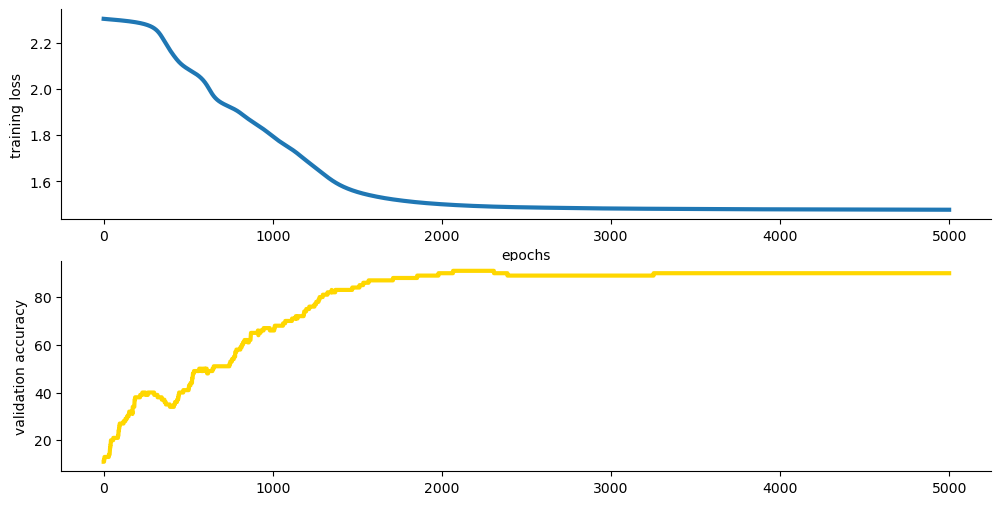

In [33]:
# Visualize training loss

plt.figure(figsize = (12, 6))

# Visualize training loss with respect to iterations (1 iteration -> single batch)
plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3)
plt.ylabel("training loss")
plt.xlabel("epochs")
sns.despine()

# Visualize validation accuracy with respect to epochs
plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
sns.despine()

In [34]:
# Compute the testing accuracy 

# YOUR CODE HERE
mnist_test_features = torch.from_numpy(mnist_test_features).float()
mnist_test_outputs = model(mnist_test_features).detach().numpy()
correct = (np.argmax(mnist_test_outputs, axis=1) == mnist_test_targets).sum()
print(correct/np.shape(mnist_test_outputs)[0]*100)


90.0


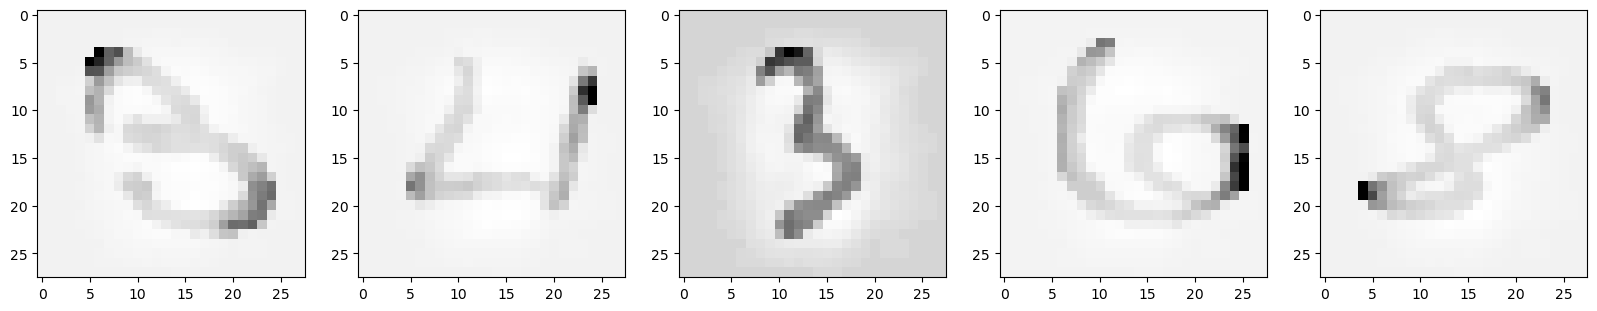

In [39]:
# Plot 5 incorrectly classified testing samples and print the model predictions for each of them
# You can use np.reshape() to convert flattened 1D array back to 2D array

curr = 0
plt.figure(figsize = (20, 20))
# YOUR CODE HERE
for i in range(100):
    if curr < 5:
        if np.argmax(mnist_test_outputs, axis=1)[i] != mnist_test_targets[i]:
            original = np.reshape(mnist_test_features[i], ((28, 28)))
            plt.subplot(1,5,curr+1)
            plt.imshow(original, cmap = 'Greys')
            curr += 1